# PM10 Forecasting Pipeline - Canton Ticino

**Authors:** Federico Alejandro Gritti, Alessandro Mecchia, 
Paolo Nicolet
**Course:** Time Series, Analytics and Forecasting (2025-26)  
**Dataset:** PM10 Air Quality, Canton Ticino (2016-2022)

---

## Project Overview

This notebook implements a complete time series analysis and forecasting pipeline for PM10 (particulate matter) levels across 9 monitoring stations in Canton Ticino, Switzerland. The goal is to predict **daily mean PM10 concentrations 1-6 days ahead** using historical measurements and meteorological forecasts.

Understanding the relationships between weather conditions and pollutants like PM10 is crucial for implementing effective air quality management strategies and public health interventions.

---

## Pipeline Structure


### 1. **Exploratory Data Analysis (EDA)**
   - Time series visualization and descriptive statistics
   - Correlation analysis (features vs. target, cross-location correlations)
   - FFT analysis for identifying dominant periodicities
   - Autocorrelation (ACF) analysis with confidence bands
   - Stationarity testing (Augmented Dickey-Fuller test)
   - Hierarchical clustering for location grouping

### 2. **Data Quality & Preprocessing**
   - Missing value analysis (measurements, forecasts, targets)
   - Spatial imputation using location-based grouping
   - Outlier detection (IQR and Z-score methods)
   - Feature engineering (daily mean aggregation, FFT-based lag selection)
   - Multicollinearity removal

### 3. **Model Building**
   - **Baseline Models:** Naive (persistent, seasonal, drift)
   - **Statistical Models:** SARIMA
   - **Machine Learning:** LightGBM with temporal features
   - All models trained on common features across locations

### 4. **Cross-Validation & Model Selection**
   - Time series CV with alternating train/validation splits (60-day folds)
   - Evaluation metrics: MAE, RMSE, MAPE
   - Probabilistic forecasting with conformal prediction
   - Performance comparison across models, locations, and horizons

### 5. **Results & Evaluation**
   - Performance tables and visualization (box plots, heatmaps)
   - Coverage and sharpness analysis for prediction intervals
   - Verification that best model outperforms naive baseline


## 1. Setup

### 1.1 Libraries and Functions Import

In [1]:
# Standard library
import warnings
from collections import defaultdict, Counter
from abc import ABC, abstractmethod


# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import seaborn as sns

# SciPy
from scipy import signal as scipy_signal, stats
from scipy.signal import find_peaks
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Statsmodels
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-learn
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, mean_squared_error

# LightGBM
import lightgbm as lgb

# Warnings configuration
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)


### 1.2 Constants and Global Configuration

Define all string constants used throughout the notebook to improve code modularity and maintainability.

In [2]:
# STRING CONSTANTS - Define all strings used throughout the notebook

# Column name separators and patterns
COL_SEPARATOR = '__'

# Measurement suffixes
MEASUREMENT_PREFIX = 'm'
MEASUREMENT_PATTERN = '__m'
M0_SUFFIX = '__m0'
DAILY_MEAN_SUFFIX = '__daily_mean'

# Forecast suffixes
FORECAST_SUFFIX = 'step'
FORECAST_PATTERN = '__step'
STEP0_SUFFIX = '__step0'

# Target/PM10 related
TARGET_SIGNAL = 'YPM10-dailymean'
PM10_SIGNAL = 'PM10'
PM10_LAG_PREFIX = 'PM10_lag'

# Day ahead patterns
DAY_AHEAD_PREFIX = 'd'
DAY_AHEAD_SUFFIX = '__d'

# Location identifiers
AVG_LOCATION = 'AVG'

# Signal names (from dataset)
SIGNAL_NAMES = {
    'WSgust': 'Wind Speed Gust',
    'O3': 'Ozone',
    'CN': 'Carbon Monoxide',
    'WDvect': 'Wind Direction Vector',
    'D_T_T': 'Temperature Difference',
    'Prec': 'Precipitation',
    'T': 'Temperature',
    'D_P_P': 'Pressure Difference',
    'RH': 'Relative Humidity',
    'WSvect': 'Wind Speed Vector',
    'NO': 'Nitrogen Monoxide',
    'NO2': 'Nitrogen Dioxide',
    'Gl': 'Global Radiation',
    'Tdew': 'Dew Point Temperature',
    'WS': 'Wind Speed',
    'WD': 'Wind Direction',
    'NOx': 'Nitrogen Oxides',
    'P': 'Atmospheric Pressure'
}

# Forecast signal suffixes (COSMO models)
COSMO2_SUFFIX = '_c2'
FORECAST_SIGNALS = {
    'T_2M': 'Temperature at 2 meters',
    'TD_2M': 'Dew Point Temperature at 2m',
    'RELHUM_2M': 'Relative Humidity at 2m',
    'FF_10M': 'Wind Speed at 10 meters',
    'DD_10M': 'Wind Direction at 10m',
    'PS': 'Surface Pressure',
    'GLOB': 'Global Solar Radiation',
    'TOT_PREC': 'Total Precipitation',
    'CLCT': 'Total Cloud Cover'
}

# Column name construction helpers
def make_measurement_col(location, signal, hour):
    """Construct measurement column name: LOCATION__SIGNAL__mHOUR"""
    return f"{location}{COL_SEPARATOR}{signal}{COL_SEPARATOR}{MEASUREMENT_PREFIX}{hour}"

def make_forecast_col(location, signal, step):
    """Construct forecast column name: LOCATION__SIGNAL__stepSTEP"""
    return f"{location}{COL_SEPARATOR}{signal}{COL_SEPARATOR}{FORECAST_SUFFIX}{step}"

def make_target_col(location, signal, day):
    """Construct target column name: LOCATION__SIGNAL__dDAY
    If day already starts with 'd', don't add another prefix"""
    if str(day).startswith('d'):
        return f"{location}{COL_SEPARATOR}{signal}{COL_SEPARATOR}{day}"
    else:
        return f"{location}{COL_SEPARATOR}{signal}{COL_SEPARATOR}{DAY_AHEAD_PREFIX}{day}"

def make_daily_mean_col(location, signal):
    """Construct daily mean column name: LOCATION__SIGNAL__daily_mean"""
    return f"{location}{COL_SEPARATOR}{signal}{COL_SEPARATOR}daily_mean"

def extract_location(col_name):
    """Extract location from column name"""
    return col_name.split(COL_SEPARATOR)[0]

def extract_signal(col_name):
    """Extract signal from column name"""
    return col_name.split(COL_SEPARATOR)[1]

def extract_suffix(col_name):
    """Extract suffix (hour/step/day) from column name"""
    return col_name.split(COL_SEPARATOR)[-1]

print("✓ Constants defined successfully")
print(f"  - Defined {len(SIGNAL_NAMES)} signal names")
print(f"  - Defined {len(FORECAST_SIGNALS)} forecast signals")
print(f"  - Defined helper functions for column name construction")

✓ Constants defined successfully
  - Defined 18 signal names
  - Defined 9 forecast signals
  - Defined helper functions for column name construction


1. **Data pre-processing and EDA**
2.  Seasonality and trend analysis
3.  Stationarity tests
4.  Correlation analysis between locations and signals

## 2. Data Loading & Overview

In [3]:
df = pd.read_csv('archive/data.csv', index_col='date', parse_dates=True)
print(f"Data shape: {df.shape}")
print(f"Columns: {len(df.columns)} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Data shape: (2557, 8536)
Columns: 8536 columns
Date range: 2016-01-01 00:00:00 to 2022-12-31 00:00:00


In [4]:
# Check unique HOUR values in the dataset
hour_cols = [col for col in df.columns if MEASUREMENT_PATTERN in col]  # columns with measurements (m0, m1, etc.)
if hour_cols:
    print("Sample measurement columns:", hour_cols[:5])
    # Extract the hour part from column names
    hours = set()
    for col in hour_cols:
        parts = col.split(COL_SEPARATOR)
        if len(parts) == 3:
            hour_part = parts[2]  # e.g., 'm0', 'm6', etc.
            if hour_part.startswith(MEASUREMENT_PREFIX):
                hours.add(hour_part)
    print(f"\nUnique HOUR values: {sorted(hours)}")
    print(f"Number of unique hours: {len(hours)}")
    
    # Extract base hour numbers (before decimal point if any)
    hour_numbers = []
    for h in hours:
        if h.startswith(MEASUREMENT_PREFIX):
            # Split by '.' to handle cases like 'm22.1'
            base_hour = h[1:].split('.')[0]
            try:
                hour_numbers.append(int(base_hour))
            except ValueError:
                pass
    
    unique_hour_numbers = sorted(set(hour_numbers))
    print(f"\nBase hour numbers: {unique_hour_numbers}")
    print(f"Range: {min(unique_hour_numbers)} to {max(unique_hour_numbers)}")
    print(f"\nSo HOUR ranges from {min(unique_hour_numbers)} to {max(unique_hour_numbers)} (24 hours total: 0-23)")

Sample measurement columns: ['BIO__PM10__m0', 'BIO__PM10__m1', 'BIO__PM10__m2', 'BIO__PM10__m3', 'BIO__PM10__m4']

Unique HOUR values: ['m0', 'm0.1', 'm1', 'm1.1', 'm10', 'm10.1', 'm11', 'm11.1', 'm12', 'm12.1', 'm13', 'm13.1', 'm14', 'm14.1', 'm15', 'm15.1', 'm16', 'm16.1', 'm17', 'm17.1', 'm18', 'm18.1', 'm19', 'm19.1', 'm2', 'm2.1', 'm20', 'm20.1', 'm21', 'm21.1', 'm22', 'm22.1', 'm23', 'm23.1', 'm3', 'm3.1', 'm4', 'm4.1', 'm5', 'm5.1', 'm6', 'm6.1', 'm7', 'm7.1', 'm8', 'm8.1', 'm9', 'm9.1']
Number of unique hours: 48

Base hour numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Range: 0 to 23

So HOUR ranges from 0 to 23 (24 hours total: 0-23)


### 2.1 Target and Features Extraction

In [5]:
target_cols = [col for col in df.columns if TARGET_SIGNAL in col]
features_cols = [col for col in df.columns if TARGET_SIGNAL not in col]
print(f"Target columns: {len(target_cols)}")
print(f"Feature columns: {len(features_cols)}")

Target columns: 48
Feature columns: 8488


### 2.2 Get Locations

In [6]:
locations = sorted(list(set([extract_location(c) for c in target_cols])))
print(f"Locations: {locations}")

Locations: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']


### 2.3 Calculate Average PM10

The challenge asked to predict the average PM10 levels across all locations. To do so, we calculate the mean of the PM10 values for each time step.

In [7]:
# Derive forecast horizons from raw (per-station) target columns in df
target_cols_raw = [col for col in df.columns if TARGET_SIGNAL in col]
target_cols_station = [c for c in target_cols_raw if extract_location(c) != AVG_LOCATION]
days_ahead = sorted(list(set([extract_suffix(c) for c in target_cols_station])))  # e.g., ['d0', 'd1', ..., 'd5']
print(f"Days ahead: {days_ahead}")

Days ahead: ['d0', 'd1', 'd2', 'd3', 'd4', 'd5']


In [8]:
# Recompute target columns from df to avoid relying on any mutated global variables
target_cols_raw = [col for col in df.columns if TARGET_SIGNAL in col]
target_cols_station = [c for c in target_cols_raw if extract_location(c) != AVG_LOCATION]

X_train = df[features_cols]
y_train_all = df[target_cols_station]  # per-station targets
y_avg = pd.DataFrame(index=y_train_all.index)

for day in days_ahead:
    day_cols = [col for col in target_cols_station if col.endswith(f'{COL_SEPARATOR}{day}')]
    avg_col_name = make_target_col(AVG_LOCATION, TARGET_SIGNAL, day)
    y_avg[avg_col_name] = y_train_all[day_cols].mean(axis=1)
    print(f"processed: {avg_col_name}")

# Combined target matrix: per-station + AVG (so we can evaluate both)
y_train = pd.concat([y_train_all, y_avg], axis=1)
print(f"y_train shape (stations + AVG): {y_train.shape}")
y_train.columns

processed: AVG__YPM10-dailymean__d0
processed: AVG__YPM10-dailymean__d1
processed: AVG__YPM10-dailymean__d2
processed: AVG__YPM10-dailymean__d3
processed: AVG__YPM10-dailymean__d4
processed: AVG__YPM10-dailymean__d5
y_train shape (stations + AVG): (2557, 54)


Index(['CHI__YPM10-dailymean__d0', 'CHI__YPM10-dailymean__d1',
       'CHI__YPM10-dailymean__d2', 'CHI__YPM10-dailymean__d3',
       'CHI__YPM10-dailymean__d4', 'CHI__YPM10-dailymean__d5',
       'MEN__YPM10-dailymean__d0', 'MEN__YPM10-dailymean__d1',
       'MEN__YPM10-dailymean__d2', 'MEN__YPM10-dailymean__d3',
       'MEN__YPM10-dailymean__d4', 'MEN__YPM10-dailymean__d5',
       'BIO__YPM10-dailymean__d0', 'BIO__YPM10-dailymean__d1',
       'BIO__YPM10-dailymean__d2', 'BIO__YPM10-dailymean__d3',
       'BIO__YPM10-dailymean__d4', 'BIO__YPM10-dailymean__d5',
       'LUG__YPM10-dailymean__d0', 'LUG__YPM10-dailymean__d1',
       'LUG__YPM10-dailymean__d2', 'LUG__YPM10-dailymean__d3',
       'LUG__YPM10-dailymean__d4', 'LUG__YPM10-dailymean__d5',
       'GIU__YPM10-dailymean__d0', 'GIU__YPM10-dailymean__d1',
       'GIU__YPM10-dailymean__d2', 'GIU__YPM10-dailymean__d3',
       'GIU__YPM10-dailymean__d4', 'GIU__YPM10-dailymean__d5',
       'NA-MAG__YPM10-dailymean__d0', 'NA-MAG__YPM10-da

In [9]:
# y_train is already built above as (stations + AVG)
print(f"y_train shape: {y_train.shape}")
y_train.columns

y_train shape: (2557, 54)


Index(['CHI__YPM10-dailymean__d0', 'CHI__YPM10-dailymean__d1',
       'CHI__YPM10-dailymean__d2', 'CHI__YPM10-dailymean__d3',
       'CHI__YPM10-dailymean__d4', 'CHI__YPM10-dailymean__d5',
       'MEN__YPM10-dailymean__d0', 'MEN__YPM10-dailymean__d1',
       'MEN__YPM10-dailymean__d2', 'MEN__YPM10-dailymean__d3',
       'MEN__YPM10-dailymean__d4', 'MEN__YPM10-dailymean__d5',
       'BIO__YPM10-dailymean__d0', 'BIO__YPM10-dailymean__d1',
       'BIO__YPM10-dailymean__d2', 'BIO__YPM10-dailymean__d3',
       'BIO__YPM10-dailymean__d4', 'BIO__YPM10-dailymean__d5',
       'LUG__YPM10-dailymean__d0', 'LUG__YPM10-dailymean__d1',
       'LUG__YPM10-dailymean__d2', 'LUG__YPM10-dailymean__d3',
       'LUG__YPM10-dailymean__d4', 'LUG__YPM10-dailymean__d5',
       'GIU__YPM10-dailymean__d0', 'GIU__YPM10-dailymean__d1',
       'GIU__YPM10-dailymean__d2', 'GIU__YPM10-dailymean__d3',
       'GIU__YPM10-dailymean__d4', 'GIU__YPM10-dailymean__d5',
       'NA-MAG__YPM10-dailymean__d0', 'NA-MAG__YPM10-da

In [10]:
forecast_features = [col for col in features_cols if FORECAST_PATTERN in col]
#extract only forecast features (step0, step1, etc.) and check uniqueness of signals
signals_in_forecasts = set()
for col in forecast_features:
    signal = extract_signal(col)
    signals_in_forecasts.add(signal)
print(f"Signals in forecast features: {signals_in_forecasts}")

Signals in forecast features: {'RELHUM_2M', 'TD_2M_c2', 'GLOB_c2', 'DD_10M', 'FF_10M', 'T_2M_c2', 'TD_2M', 'CLCT', 'TOT_PREC', 'PS_c2', 'GLOB', 'PS', 'RELHUM_2M_c2', 'TOT_PREC_c2', 'CLCT_c2', 'T_2M'}


### 2.4 Feature Explanations

The dataset's features include historical measurements and meteorological data across various locations in Canton Ticino. The "pollutants" (or signals) extracted from the features are a mix of air pollutants and weather variables, all with lagged versions (e.g., m0 for current, m1 for 1 step back) and forecast steps (step0 through step5). Below is an explanation of each signal based on standard air quality and meteorological conventions. 

**Important Note:** PM10 is our target variable and has been removed from X_train to prevent data leakage. PM10 only appears in y_train as the variable we're predicting.

| Signal | Full Name/Description |
|--------|-----------------------|
| WSgust | Wind Speed Gust – Maximum short-term wind speed, indicating potential for pollutant dispersion or advection. |
| O3     | Ozone – A secondary pollutant formed by chemical reactions; high levels can indicate photochemical smog and affect air quality. |
| CN     | Carbon Monoxide? (or possibly another carbon-based pollutant) – Likely a measure of carbon monoxide or a related compound; toxic gas from combustion. |
| WDvect | Wind Direction Vector – Vector representation of wind direction (e.g., x/y components), useful for modeling wind patterns. |
| D_T_T  | Temperature Difference (possibly dew point or gradient) – Difference in temperature values, potentially between surface and air or over time. |
| Prec   | Precipitation – Amount of rainfall or snow, which can wash out pollutants or influence humidity. |
| T      | Temperature – Air temperature, a key meteorological factor affecting pollutant formation and dispersion. |
| D_P_P  | Pressure Difference – Gradient or change in atmospheric pressure, influencing weather systems and pollutant transport. |
| RH     | Relative Humidity – Percentage of moisture in the air, impacting pollutant reactions and health effects. |
| WSvect | Wind Speed Vector – Vector representation of wind speed (e.g., u/v components), for directional wind modeling. |
| NO     | Nitrogen Monoxide – Primary pollutant from vehicle emissions; precursor to NO2 and ozone. |
| NO2    | Nitrogen Dioxide – Toxic gas from combustion; contributes to acid rain and respiratory issues. |
| Gl     | Global Radiation – Incoming solar radiation, influencing photochemical reactions like ozone formation. |
| Tdew   | Dew Point Temperature – Temperature at which air becomes saturated; indicates humidity levels. |
| WS     | Wind Speed – Average wind speed, affecting pollutant dilution and transport. |
| WD     | Wind Direction – Direction from which the wind blows, important for source attribution of pollutants. |
| NOx    | Nitrogen Oxides – Combined NO and NO2; indicator of traffic-related pollution. |
| P      | Atmospheric Pressure – Barometric pressure, influencing weather stability and pollutant accumulation. |

These features are available as lagged measurements (e.g., __m0 to __m20) and forecast steps (__step0 to __step5) to capture temporal dependencies. Meteorological signals (e.g., T, RH, WS) are often more complete and help predict PM10 by incorporating weather influences and historical pollutant trends.

### 2.5 Plot PM10 Time Series by Station

Plot the PM10 target values (daily mean) for each station across all prediction horizons (d0 through d5).

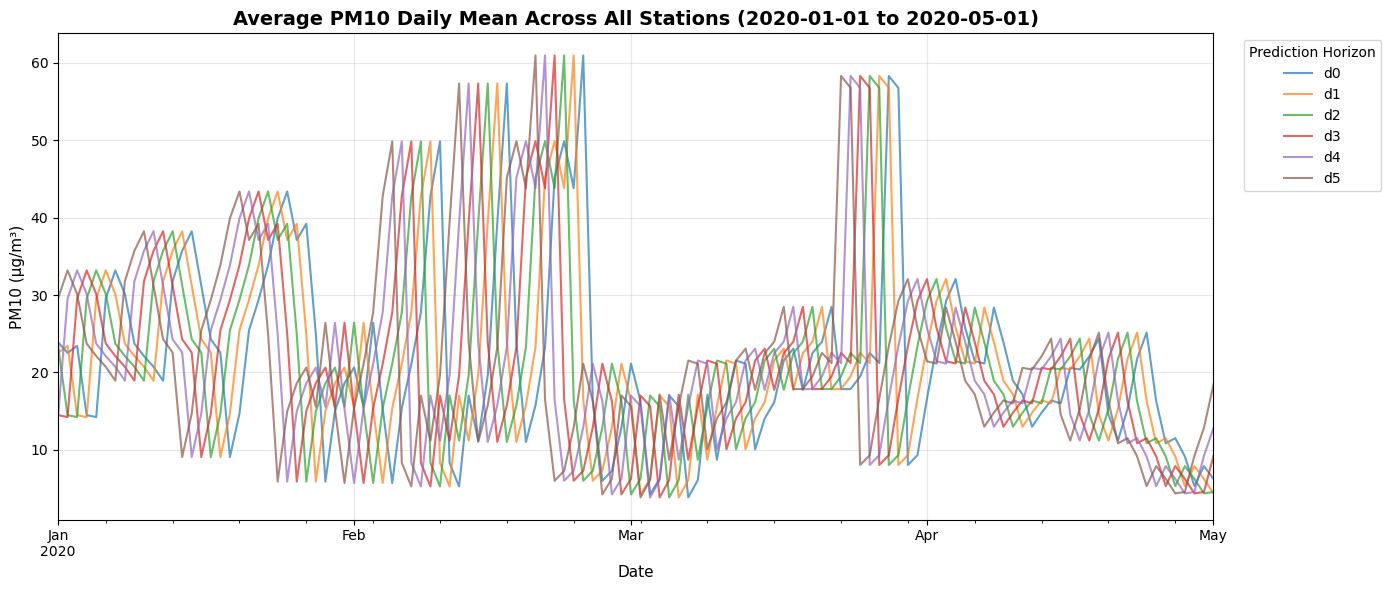

In [11]:
# Plot average PM10 time series across all stations for each prediction horizon
# Plot only a portion of the dataset (e.g., 2020-2021 for clearer visualization)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Select a portion of the data - modify dates as needed
start_date = '2020-01-01'
end_date = '2020-05-01'


y_avg_subset = y_avg.loc[start_date:end_date]

# Plot all prediction horizons from y_avg
y_avg_subset.plot(ax=ax, alpha=0.7, linewidth=1.5)

ax.set_title(f'Average PM10 Daily Mean Across All Stations ({start_date} to {end_date})', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('PM10 (µg/m³)', fontsize=11)
ax.legend(title='Prediction Horizon', labels=[col.split('__')[-1] for col in y_avg.columns], 
          bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

### 3.1 Feature Visualization

NA-MAG and LUG seems to be different stations with a different set of features, possibly due to their specific measurement setups or data availability and not all the stations have all the features listed above.

In [12]:
# Features per station - STEP 1: Identify common features from m0 measurements
# We need to identify which signals are common across all stations BEFORE creating daily means
m0_features = [col for col in features_cols if col.endswith(M0_SUFFIX)]

features_per_station = {}
for loc in locations:
    loc_features = [col for col in m0_features if col.startswith(f'{loc}{COL_SEPARATOR}')]
    signals = sorted([extract_signal(col) for col in loc_features])
    features_per_station[loc] = signals

for loc, signals in features_per_station.items():
    print(f"{loc}: {signals}")

#common features across all stations (from m0 columns)
common_features = set(features_per_station[locations[0]])
for loc in locations[1:]:
    common_features.intersection_update(set(features_per_station[loc]))
print(f"Common features across all stations: {sorted(common_features)}")
print(f"\n→ Next: Create daily_mean aggregations for these {len(common_features)} common features")

BIO: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSvect']
BRI: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSvect']
CHI: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'Tdew', 'WD', 'WS', 'WSgust']
GIU: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'RH', 'T', 'Tdew', 'WSgust']
LOC: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'Tdew', 'WSgust']
LUG: ['NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5']
MEN: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSgust', 'WSvect']
NA-MAG: ['NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5']
Common features across all stations: ['NO', 'NO2', 'NOx', 'O3', 'PM10']

→ Next: Create daily_mean aggregations for these 5 common features


In [13]:
# Create daily mean values from hourly measurements for ALL signals (not just common features)

print("CREATING DAILY MEAN VALUES FROM HOURLY MEASUREMENTS:")
print("")
# First, extract all unique signals from measurement columns
measurement_cols = [col for col in df.columns if MEASUREMENT_PATTERN in col]
all_measurement_signals = set()
for col in measurement_cols:
    signal = extract_signal(col)
    all_measurement_signals.add(signal)

print(f"Found {len(all_measurement_signals)} unique signals in measurement columns")
print(f"Signals: {sorted(all_measurement_signals)}")

# For each location and each signal, aggregate hourly measurements (m0-m23)
daily_mean_cols = {}

for loc in locations:
    for signal in sorted(all_measurement_signals):
        # Skip PM10_lag1 as it's not a raw measurement signal
        if '_lag' in signal:
            continue
            
        # Find all hourly measurement columns for this location and signal
        # Pattern: LOCATION__SIGNAL__m0, LOCATION__SIGNAL__m1, ..., LOCATION__SIGNAL__m23
        hourly_cols = []
        for hour in range(24):  # Hours 0-23
            col_name = make_measurement_col(loc, signal, hour)
            if col_name in df.columns:
                hourly_cols.append(col_name)
        
        # If we have hourly measurements, compute the daily mean
        if len(hourly_cols) > 0:
            daily_mean_col_name = make_daily_mean_col(loc, signal)
            X_train.loc[:, daily_mean_col_name] = df[hourly_cols].mean(axis=1, skipna=True)
            daily_mean_cols[daily_mean_col_name] = len(hourly_cols)
            
print(f"\nCreated {len(daily_mean_cols)} daily mean columns")
print(f"Example columns created:")
for i, (col_name, n_hours) in enumerate(list(daily_mean_cols.items())[:10]):
    print(f"  {col_name} (aggregated from {n_hours} hourly measurements)")

# Show statistics about the daily mean columns
if daily_mean_cols:
    # Count signals per location
    signals_per_location = {}
    for loc in locations:
        signals_per_location[loc] = sum(1 for col in daily_mean_cols.keys() if col.startswith(f'{loc}{COL_SEPARATOR}'))
    
    print(f"\nDaily mean features statistics:")
    print(f"  Total daily mean columns: {len(daily_mean_cols)}")
    print(f"  Locations covered: {len(locations)}")
    print(f"  Total unique signals: {len(all_measurement_signals)}")
    print(f"  Signals per location:")
    for loc, count in sorted(signals_per_location.items()):
        print(f"    {loc}: {count} signals")
    
    # Check missingness in newly created columns
    daily_mean_missing = (X_train[list(daily_mean_cols.keys())].isnull().sum() / len(X_train)) * 100
    print(f"\n  Average missingness: {daily_mean_missing.mean():.2f}%")
    print(f"  Columns with <5% missing: {(daily_mean_missing < 5).sum()}/{len(daily_mean_cols)}")
    print(f"  Columns with >50% missing: {(daily_mean_missing > 50).sum()}/{len(daily_mean_cols)}")

CREATING DAILY MEAN VALUES FROM HOURLY MEASUREMENTS:

Found 20 unique signals in measurement columns
Signals: ['CN', 'D_P_P', 'D_T_T', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'PM2.5', 'Prec', 'RH', 'T', 'Tdew', 'WD', 'WDvect', 'WS', 'WSgust', 'WSvect']

Created 92 daily mean columns
Example columns created:
  BIO__CN__daily_mean (aggregated from 24 hourly measurements)
  BIO__Gl__daily_mean (aggregated from 24 hourly measurements)
  BIO__NO__daily_mean (aggregated from 24 hourly measurements)
  BIO__NO2__daily_mean (aggregated from 24 hourly measurements)
  BIO__NOx__daily_mean (aggregated from 24 hourly measurements)
  BIO__O3__daily_mean (aggregated from 24 hourly measurements)
  BIO__P__daily_mean (aggregated from 24 hourly measurements)
  BIO__PM10__daily_mean (aggregated from 24 hourly measurements)
  BIO__Prec__daily_mean (aggregated from 24 hourly measurements)
  BIO__RH__daily_mean (aggregated from 24 hourly measurements)

Daily mean features statistics:
  Total daily mean

Total signals with daily_mean data: 18
Signals: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'PM2.5', 'Prec', 'RH', 'T', 'Tdew', 'WD', 'WDvect', 'WS', 'WSgust', 'WSvect']


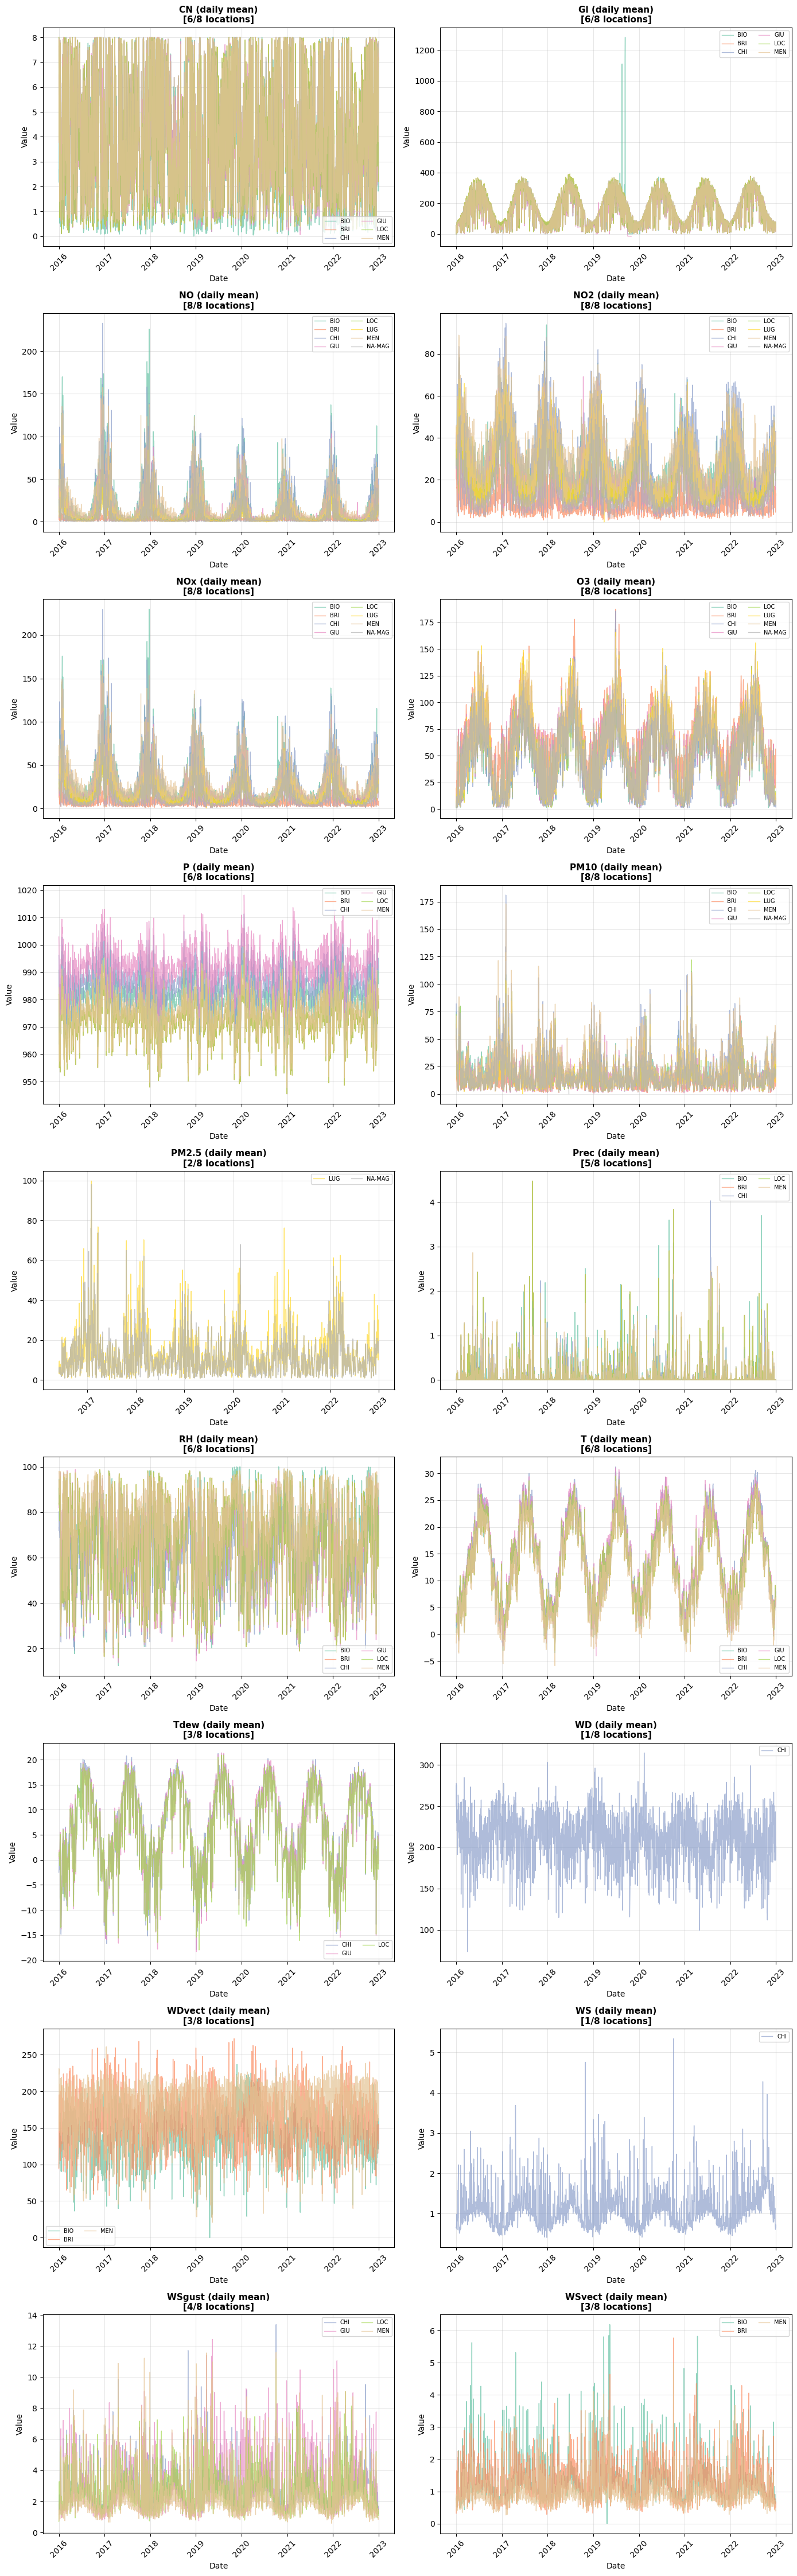

In [14]:
# Time series plots of daily mean for ALL measurement signals (including non-common features)
# Plot daily mean values over time for each signal, showing which locations have it
daily_mean_features = [col for col in X_train.columns if DAILY_MEAN_SUFFIX in col]

# Get all unique signals across all locations (not just common ones)
all_signals = sorted(set([extract_signal(col) for col in daily_mean_features]))

print(f"Total signals with daily_mean data: {len(all_signals)}")
print(f"Signals: {all_signals}")

# Define consistent color palette for locations
location_palette = {loc: color for loc, color in zip(sorted(locations), sns.color_palette('Set2', len(locations)))}

# Adjust grid size based on number of signals
n_signals = len(all_signals)
n_cols = 2
n_rows = (n_signals + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

for i, signal in enumerate(all_signals):
    ax = axes[i]
    
    # Track which locations have this signal
    locations_with_signal = []
    
    # Plot time series for each location that has this signal
    for loc in locations:
        col_name = make_daily_mean_col(loc, signal)
        if col_name in X_train.columns:
            data = X_train[col_name]
            if not data.dropna().empty:
                ax.plot(df.index, data, label=loc, color=location_palette[loc], alpha=0.7, linewidth=1)
                locations_with_signal.append(loc)
    
    # Add info about which locations have this signal
    title = f'{signal} (daily mean)\n[{len(locations_with_signal)}/{len(locations)} locations]'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    
    if locations_with_signal:
        ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(n_signals, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**Interpretation – daily mean signals:** Seasonal cycles are evident in several signals (e.g., T, Gl, RH) across locations, confirming consistent yearly patterns. Coverage varies by signal: core pollutants (PM10, NOx family, O3) and meteorological basics are available at most stations, while PM2.5 and wind direction/speed vectors are limited to a few sites. This uneven availability will constrain cross-location feature sharing for rarer signals.

#### 3.1.1 FFT Analysis for Optimal Lag Selection

Before creating lag features, we use Fast Fourier Transform (FFT) to analyze the frequency components of PM10 time series and identify the most important periodicities. This helps us select lag values that capture the dominant temporal patterns in the data.

FFT ANALYSIS FOR OPTIMAL LAG SELECTION:

Analyzing 8 PM10 station time series
Stations: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']

Station BIO:
  - Data points: 2557
  - Top 5 dominant periods (days): [365.29  30.44 182.64 121.76  23.25]
  - Corresponding powers: [75911104.79  9411981.38  8640531.96  5755493.61  5263138.84]
  - Detected dominant periods: [365, 30, 183, 122, 23]

Station BRI:
  - Data points: 2554
  - Top 5 dominant periods (days): [ 30.4  121.62 182.43 364.86  67.21]
  - Corresponding powers: [4891030.86 4636683.08 4542934.11 4334651.27 3796250.5 ]
  - Detected dominant periods: [30, 122, 182, 365, 67]

Station CHI:
  - Data points: 2557
  - Top 5 dominant periods (days): [365.29 182.64  30.44  23.25  23.68]
  - Corresponding powers: [2.18793354e+08 1.57835197e+07 1.36124668e+07 8.67925448e+06
 8.30423537e+06]
  - Detected dominant periods: [365, 183, 30, 23, 24]

Station GIU:
  - Data points: 2552
  - Top 5 dominant periods (days): [364.57   6.97  30

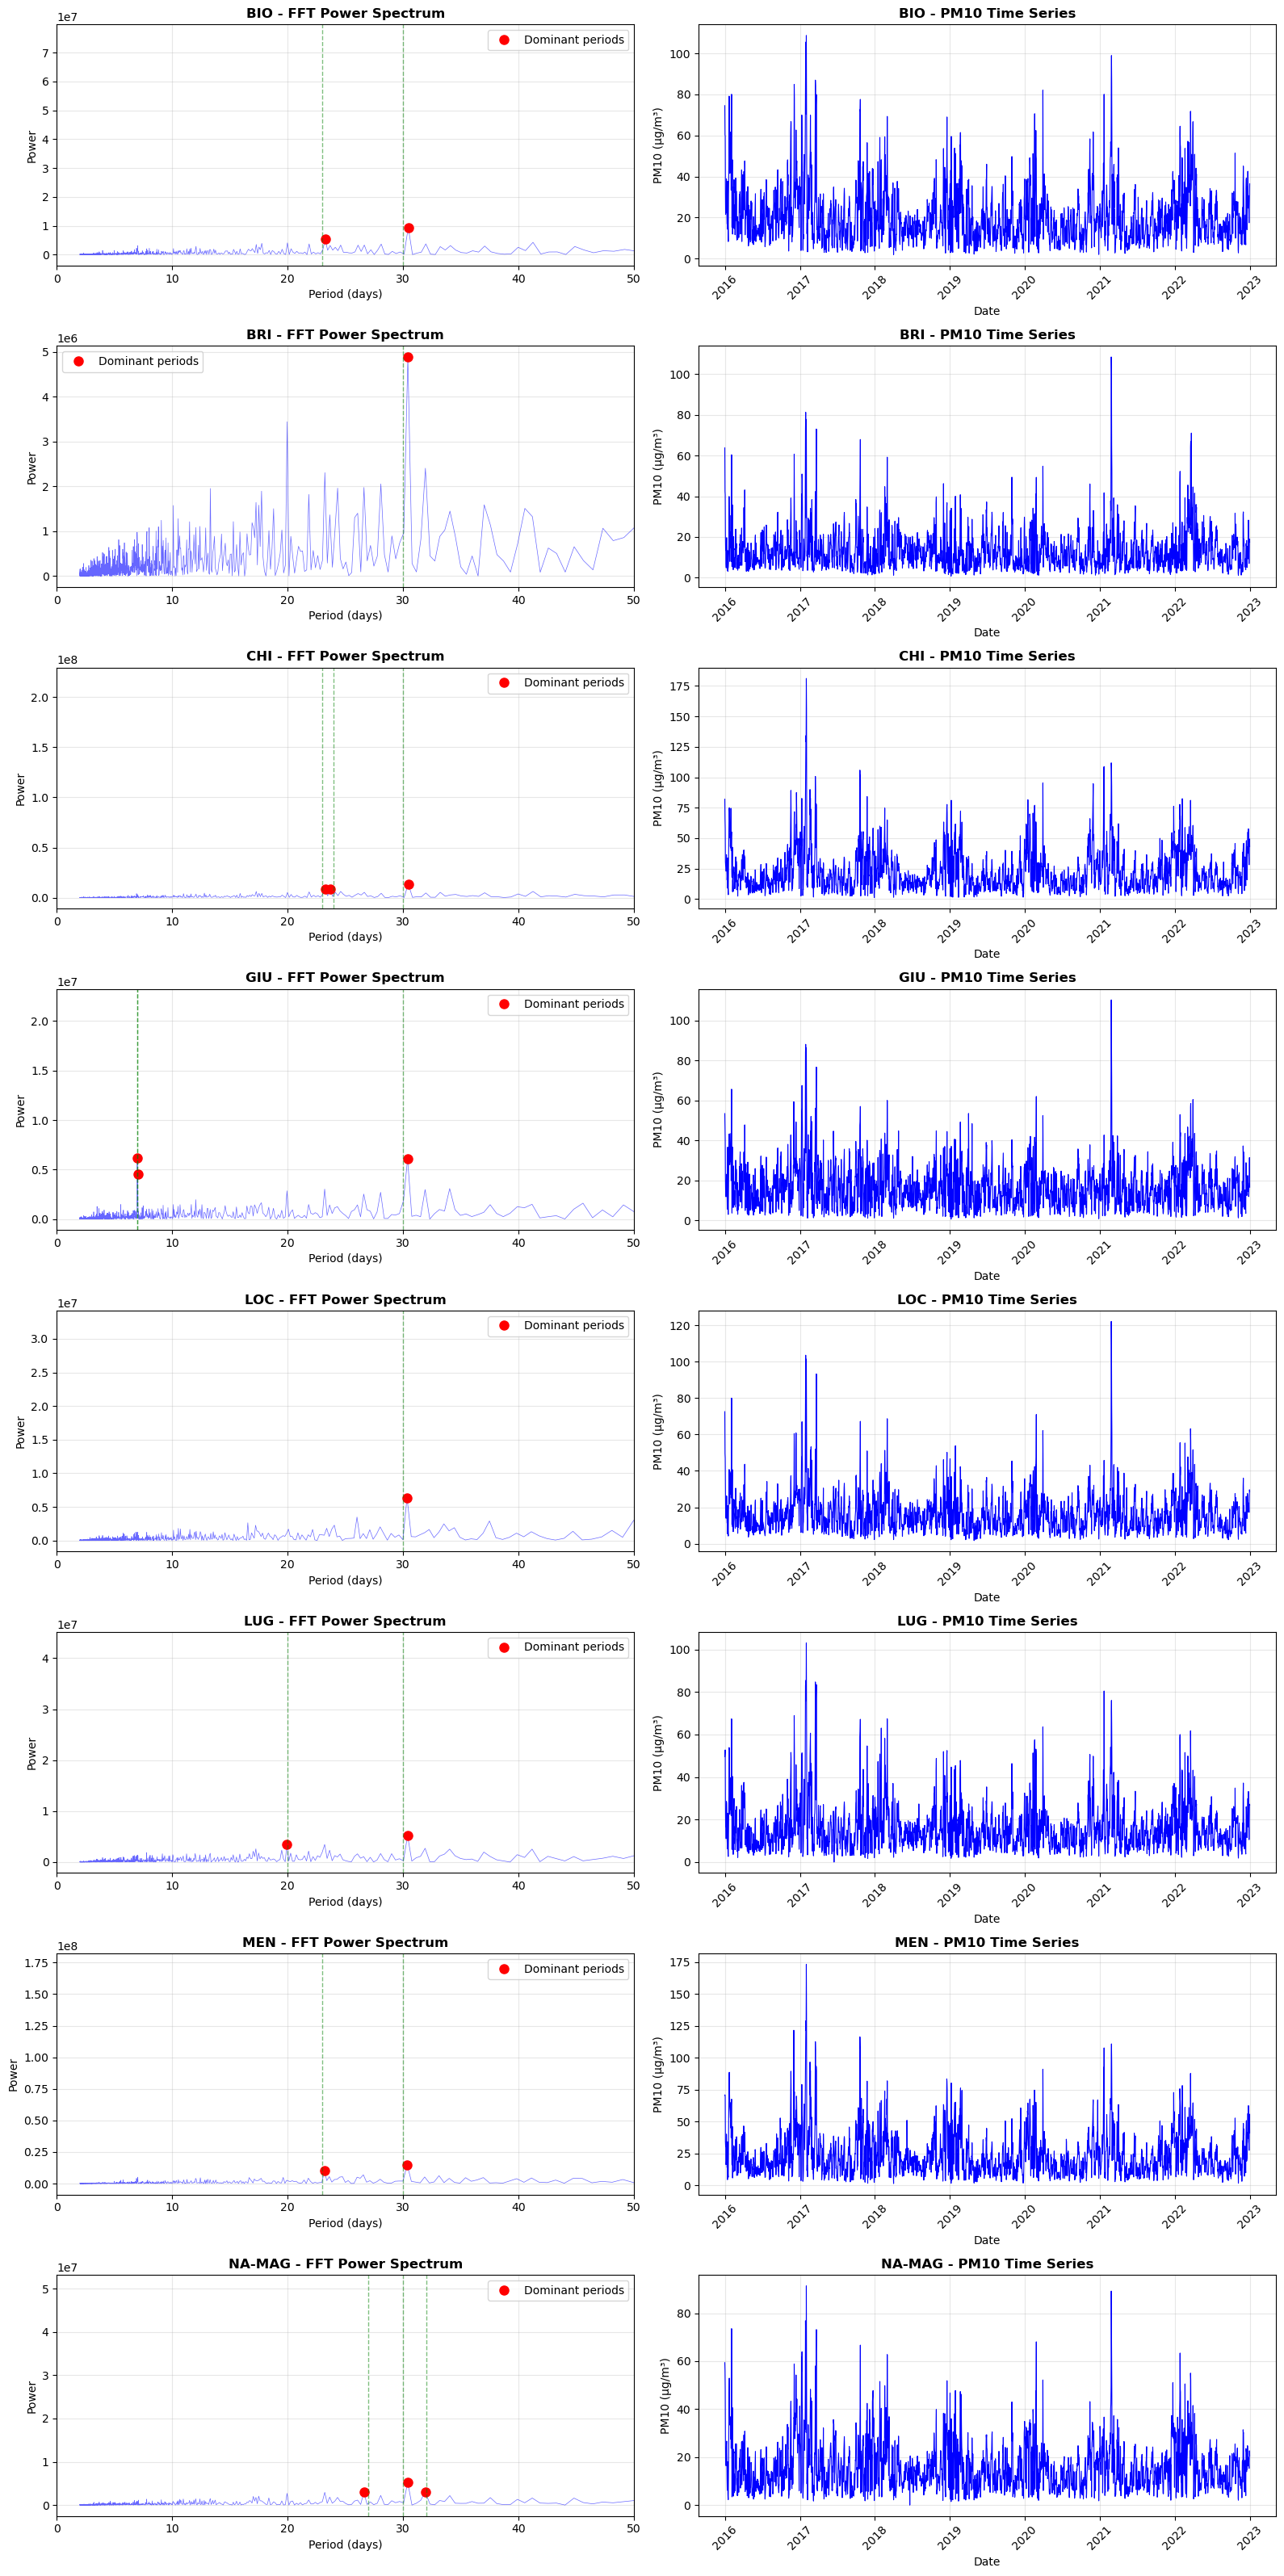

FFT ANALYSIS SUMMARY - BINNED PEAK DETECTION:
BIO: [365, 30, 183, 122, 23]
BRI: [30, 122, 182, 365, 67]
CHI: [365, 183, 30, 23, 24]
GIU: [365, 7, 30, 7, 122]
LOC: [364, 182, 30, 102]
LUG: [365, 182, 122, 30, 20]
MEN: [364, 30, 182, 23, 121]
NA-MAG: [365, 182, 30, 32, 27]

All detected periods across stations: [7, 20, 23, 24, 27, 30, 32, 67, 102, 121, 122, 182, 183, 364, 365]

Binned periods:
  Weekly (5-10d): [7, 7] (count: 2)
  Monthly (25-35d): [30, 30, 30, 30, 30, 30, 30, 30, 32, 27] (count: 10)
  Bi-monthly (55-70d): [67] (count: 1)
  Semi-annual (160-200d): [183, 182, 183, 182, 182, 182, 182] (count: 7)
  Annual (350-380d): [365, 365, 365, 365, 364, 365, 364, 365] (count: 8)

Selected representative lags:
  Weekly (5-10d) → lag 7 days
  Monthly (25-35d) → lag 30 days
  Bi-monthly (55-70d) → lag 67 days
  Semi-annual (160-200d) → lag 182 days
  Annual (350-380d) → lag 365 days

✓ Final recommended lags (binned peaks): [7, 30, 67, 182, 365]
  Total lag features per station: 5
  This

In [15]:
# FFT Analysis to determine optimal lags for PM10 time series
print("FFT ANALYSIS FOR OPTIMAL LAG SELECTION:")

# Get PM10 daily_mean columns for each station (exclude AVG)
pm10_daily_mean_cols = [col for col in X_train.columns if f'{COL_SEPARATOR}{PM10_SIGNAL}{DAILY_MEAN_SUFFIX}' in col and not col.startswith(AVG_LOCATION)]

print(f"\nAnalyzing {len(pm10_daily_mean_cols)} PM10 station time series")
print(f"Stations: {[extract_location(col) for col in pm10_daily_mean_cols]}\n")

# Store FFT results per station
fft_results = {}
recommended_lags_per_station = {}

# Plot setup
n_stations = len(pm10_daily_mean_cols)
fig, axes = plt.subplots(n_stations, 2, figsize=(16, 4*n_stations))
if n_stations == 1:
    axes = axes.reshape(1, -1)

for idx, pm10_col in enumerate(pm10_daily_mean_cols):
    loc = extract_location(pm10_col)
    
    # Get PM10 time series and remove NaNs
    pm10_series = X_train[pm10_col].dropna()
    
    print(f"Station {loc}:")
    print(f"  - Data points: {len(pm10_series)}")
    
    # Detrend the series (remove linear trend)
    detrended = scipy_signal.detrend(pm10_series.values)
    
    # Apply FFT
    fft_values = np.fft.fft(detrended)
    fft_freq = np.fft.fftfreq(len(detrended), d=1)  # d=1 for daily data
    
    # Get positive frequencies only
    positive_freq_idx = fft_freq > 0
    frequencies = fft_freq[positive_freq_idx]
    power = np.abs(fft_values[positive_freq_idx])**2
    
    # Convert frequencies to periods (in days)
    periods = 1 / frequencies
    
    # Find dominant periods (peaks in power spectrum)

    peaks, properties = find_peaks(power, prominence=np.percentile(power, 75))
    
    # Get top 5 dominant periods
    peak_periods = periods[peaks]
    peak_powers = power[peaks]
    
    # Sort by power and get top periods
    sorted_idx = np.argsort(peak_powers)[::-1]
    top_periods = peak_periods[sorted_idx][:5]
    top_powers = peak_powers[sorted_idx][:5]
    
    print(f"  - Top 5 dominant periods (days): {np.round(top_periods, 2)}")
    print(f"  - Corresponding powers: {np.round(top_powers, 2)}")
    
    # Store results
    fft_results[loc] = {
        'frequencies': frequencies,
        'power': power,
        'periods': periods,
        'top_periods': top_periods,
        'top_powers': top_powers
    }
    
    # Store all dominant periods for this station (rounded to integers)
    station_periods = [int(round(p)) for p in top_periods if 1 <= p <= 400]
    recommended_lags_per_station[loc] = station_periods
    print(f"  - Detected dominant periods: {station_periods}\n")
    
    # Plot 1: Power Spectrum
    ax1 = axes[idx, 0]
    ax1.plot(periods, power, 'b-', alpha=0.6, linewidth=0.5)
    ax1.plot(top_periods, top_powers, 'ro', markersize=8, label='Dominant periods')
    ax1.set_xlabel('Period (days)', fontsize=10)
    ax1.set_ylabel('Power', fontsize=10)
    ax1.set_title(f'{loc} - FFT Power Spectrum', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 50)  # Focus on periods up to 50 days
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add vertical lines for detected periods
    for period in station_periods:
        ax1.axvline(x=period, color='green', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot 2: Time Series (original)
    ax2 = axes[idx, 1]
    ax2.plot(pm10_series.index, pm10_series.values, 'b-', linewidth=0.8)
    ax2.set_xlabel('Date', fontsize=10)
    ax2.set_ylabel('PM10 (µg/m³)', fontsize=10)
    ax2.set_title(f'{loc} - PM10 Time Series', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Smart binning: Group similar periods and recommend peak lag values
print("FFT ANALYSIS SUMMARY - BINNED PEAK DETECTION:")

# Collect all detected periods from all stations
all_periods = []
for loc, periods in recommended_lags_per_station.items():
    all_periods.extend(periods)
    print(f"{loc}: {periods}")

print(f"\nAll detected periods across stations: {sorted(set(all_periods))}")

# Define temporal bins with tolerance
bins = {
    'Daily (1-2d)': (1, 2),
    'Weekly (5-10d)': (5, 10),
    'Bi-weekly (12-18d)': (12, 18),
    'Monthly (25-35d)': (25, 35),
    'Bi-monthly (55-70d)': (55, 70),
    'Quarterly (80-100d)': (80, 100),
    'Semi-annual (160-200d)': (160, 200),
    'Annual (350-380d)': (350, 380)
}

# Bin the periods
binned_periods = {bin_name: [] for bin_name in bins.keys()}
for period in all_periods:
    for bin_name, (bin_min, bin_max) in bins.items():
        if bin_min <= period <= bin_max:
            binned_periods[bin_name].append(period)
            break

# Show binning results
print(f"\nBinned periods:")
for bin_name, periods in binned_periods.items():
    if periods:
        print(f"  {bin_name}: {periods} (count: {len(periods)})")

# Select representative lag from each bin (use median or most common)
recommended_lags = []
print(f"\nSelected representative lags:")
for bin_name, periods in binned_periods.items():
    if periods:
        # Use median of the bin as representative
        representative = int(np.median(periods))
        recommended_lags.append(representative)
        print(f"  {bin_name} → lag {representative} days")

# Sort lags
recommended_lags = sorted(recommended_lags)

print(f"\n✓ Final recommended lags (binned peaks): {recommended_lags}")
print(f"  Total lag features per station: {len(recommended_lags)}")
print(f"  This captures the key temporal patterns: daily, weekly, monthly, seasonal, annual")

**Interpretation – FFT on PM10:** Dominant periods cluster around weekly (~7d), monthly (~30d), 2–3 month (≈67d), semi-annual (~182d), and annual (~365d) cycles. These peaks justify the selected lag set [7, 30, 67, 182, 365] and indicate that PM10 dynamics mix short-term buildup with strong seasonal components across stations.

#### 3.1.2 Drop PM10 from Features

Since PM10 is our target variable (we're predicting the average PM10 across locations), we must remove all PM10 features from X_train to avoid data leakage. PM10 values should only exist in y_train.

#### 3.1.3 Create Lagged PM10 Features Before Dropping

Before dropping PM10, we create lagged features from each station's PM10 measurements. These will be used in hierarchical clustering and modeling.

In [16]:
# Create lagged PM10 features for each station from their PM10 daily_mean columns
print("="*80)
print("CREATING LAGGED PM10 FEATURES FOR EACH STATION (FFT-BASED SELECTION)")
print("="*80)

# Get PM10 daily_mean columns for each location
pm10_daily_mean_cols = [col for col in X_train.columns if f'{COL_SEPARATOR}{PM10_SIGNAL}{DAILY_MEAN_SUFFIX}' in col and not col.startswith(AVG_LOCATION)]

lag_columns_to_add = {}
# Use FFT-recommended lags (computed in previous cell)
# If FFT analysis wasn't run, fall back to default
if 'recommended_lags' not in locals() or recommended_lags is None:
    print("Warning: FFT analysis not found. Using default lags.")
    lags_to_create = [1, 7, 14]
else:
    lags_to_create = recommended_lags
    print(f"Using FFT-recommended lags: {lags_to_create}")

for pm10_col in pm10_daily_mean_cols:
    # Extract location from column name
    loc = extract_location(pm10_col)
    
    # Get the PM10 values for this location
    pm10_values = X_train[pm10_col]
    
    # Create lagged features for this location
    for lag in lags_to_create:
        lag_col_name = make_daily_mean_col(loc, f'{PM10_SIGNAL}_lag{lag}')
        lag_columns_to_add[lag_col_name] = pm10_values.shift(lag)

# Add all lagged columns to X_train
if lag_columns_to_add:
    lag_df = pd.DataFrame(lag_columns_to_add, index=X_train.index)
    X_train = pd.concat([X_train, lag_df], axis=1)
    
    print(f"✓ Created {len(lag_columns_to_add)} lagged PM10 features across {len(pm10_daily_mean_cols)} stations")
    print(f"  Sample columns: {list(lag_columns_to_add.keys())[:5]}...")
    print(f"  New X_train shape: {X_train.shape}")
    
    # Impute missing values in lagged features
    missing_before = lag_df.isnull().sum().sum()
    print(f"  Missing values in lagged features (before imputation): {missing_before}")
    
    # Fill with day mean of PM10 across all stations (mean of PM10 daily_mean columns for that specific day)
    pm10_day_means = X_train[pm10_daily_mean_cols].mean(axis=1)
    for lag_col in lag_columns_to_add.keys():
        X_train[lag_col] = X_train[lag_col].fillna(pm10_day_means)
    
    missing_after = X_train[[col for col in lag_columns_to_add.keys()]].isnull().sum().sum()
    print(f"  Missing values in lagged features (after imputation): {missing_after}")
else:
    print("Warning: No PM10 daily_mean columns found in X_train")

print("="*80)

CREATING LAGGED PM10 FEATURES FOR EACH STATION (FFT-BASED SELECTION)
Using FFT-recommended lags: [7, 30, 67, 182, 365]
✓ Created 40 lagged PM10 features across 8 stations
  Sample columns: ['BIO__PM10_lag7__daily_mean', 'BIO__PM10_lag30__daily_mean', 'BIO__PM10_lag67__daily_mean', 'BIO__PM10_lag182__daily_mean', 'BIO__PM10_lag365__daily_mean']...
  New X_train shape: (2557, 8620)
  Missing values in lagged features (before imputation): 5378
  Missing values in lagged features (after imputation): 0


In [17]:
# Drop PM10 features from X_train but KEEP the lagged PM10 features
pm10_features = [col for col in X_train.columns if PM10_SIGNAL in col and PM10_LAG_PREFIX not in col]
X_train = X_train.drop(columns=pm10_features)
print(f"Dropped {len(pm10_features)} PM10 columns from X_train (keeping lagged PM10)")
print(f"X_train shape after dropping PM10: {X_train.shape}")
print(f"Remaining PM10_lag columns: {len([col for col in X_train.columns if PM10_LAG_PREFIX in col])}")
X_train.columns

Dropped 200 PM10 columns from X_train (keeping lagged PM10)
X_train shape after dropping PM10: (2557, 8420)
Remaining PM10_lag columns: 40


Index(['BIO__NO__m0', 'BIO__NO__m1', 'BIO__NO__m2', 'BIO__NO__m3',
       'BIO__NO__m4', 'BIO__NO__m5', 'BIO__NO__m6', 'BIO__NO__m7',
       'BIO__NO__m8', 'BIO__NO__m9',
       ...
       'MEN__PM10_lag7__daily_mean', 'MEN__PM10_lag30__daily_mean',
       'MEN__PM10_lag67__daily_mean', 'MEN__PM10_lag182__daily_mean',
       'MEN__PM10_lag365__daily_mean', 'NA-MAG__PM10_lag7__daily_mean',
       'NA-MAG__PM10_lag30__daily_mean', 'NA-MAG__PM10_lag67__daily_mean',
       'NA-MAG__PM10_lag182__daily_mean', 'NA-MAG__PM10_lag365__daily_mean'],
      dtype='object', length=8420)

In [18]:
# Recalculate common features after dropping PM10
# Get remaining daily_mean features (PM10 has been dropped, but PM10_lag1 remains)
daily_mean_features_after_drop = [col for col in X_train.columns if DAILY_MEAN_SUFFIX in col]

print(f"Total daily_mean features remaining: {len(daily_mean_features_after_drop)}")
print(f"Sample columns: {daily_mean_features_after_drop[:5]}")

# Calculate which daily_mean signals each station has
features_per_station = {}
for loc in locations:
    # Get all daily_mean columns for this location
    loc_daily_mean_cols = [col for col in daily_mean_features_after_drop if col.startswith(f'{loc}{COL_SEPARATOR}')]
    # Extract signal names from the column names (e.g., "BIO__NO__daily_mean" -> "NO")
    signals = sorted([extract_signal(col) for col in loc_daily_mean_cols])
    features_per_station[loc] = signals
    print(f"  {loc}: {len(signals)} signals")

# Find common daily_mean signals across ALL stations
common_features = set(features_per_station[locations[0]])
for loc in locations[1:]:
    common_features.intersection_update(set(features_per_station[loc]))

print(f"\nCommon daily_mean signals across all stations (after dropping PM10): {sorted(common_features)}")

Total daily_mean features remaining: 124
Sample columns: ['BIO__CN__daily_mean', 'BIO__Gl__daily_mean', 'BIO__NO__daily_mean', 'BIO__NO2__daily_mean', 'BIO__NOx__daily_mean']
  BIO: 17 signals
  BRI: 17 signals
  CHI: 19 signals
  GIU: 16 signals
  LOC: 17 signals
  LUG: 10 signals
  MEN: 18 signals
  NA-MAG: 10 signals

Common daily_mean signals across all stations (after dropping PM10): ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag182', 'PM10_lag30', 'PM10_lag365', 'PM10_lag67', 'PM10_lag7']


### 3.2 Correlation Analysis

#### 3.2.1 Correlation with AVG PM10 Target at d0

In [19]:
# Correlation analysis for AVG target at d0
target_horizon = 'd0'
target_col = make_target_col(AVG_LOCATION, TARGET_SIGNAL, target_horizon)

# Create AVG features by averaging daily_mean features across all stations for each signal
print("Creating AVG features by averaging across all stations...")
avg_features_dict = {}

# Get all daily_mean features
daily_mean_features = [col for col in X_train.columns if DAILY_MEAN_SUFFIX in col]

# Group by signal and average across locations
for signal in common_features:
    signal_cols = [col for col in daily_mean_features if extract_signal(col) == signal]
    if len(signal_cols) > 0:
        avg_col_name = make_daily_mean_col(AVG_LOCATION, signal)
        avg_features_dict[avg_col_name] = X_train[signal_cols].mean(axis=1)

# Create DataFrame with AVG features
X_train_avg = pd.DataFrame(avg_features_dict, index=X_train.index)
print(f"Created {len(X_train_avg.columns)} AVG features")

# Calculate correlations with AVG target at d0
correlations = {}
for feat_col in X_train_avg.columns:
    signal = extract_signal(feat_col)
    corr = X_train_avg[feat_col].corr(y_train[target_col])
    if not pd.isna(corr):
        correlations[signal] = corr

# Sort by absolute correlation value
correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))
station_correlations = {AVG_LOCATION: correlations}

print(f"\nTop 10 features correlated with {target_col}:")
for i, (signal, corr) in enumerate(list(correlations.items())[:10]):
    print(f"  {i+1}. {signal}: {corr:.3f}")

Creating AVG features by averaging across all stations...
Created 9 AVG features

Top 10 features correlated with AVG__YPM10-dailymean__d0:
  1. NO2: 0.566
  2. NOx: 0.495
  3. NO: 0.430
  4. O3: -0.261
  5. PM10_lag365: 0.252
  6. PM10_lag7: 0.201
  7. PM10_lag30: 0.139
  8. PM10_lag67: 0.118
  9. PM10_lag182: -0.053


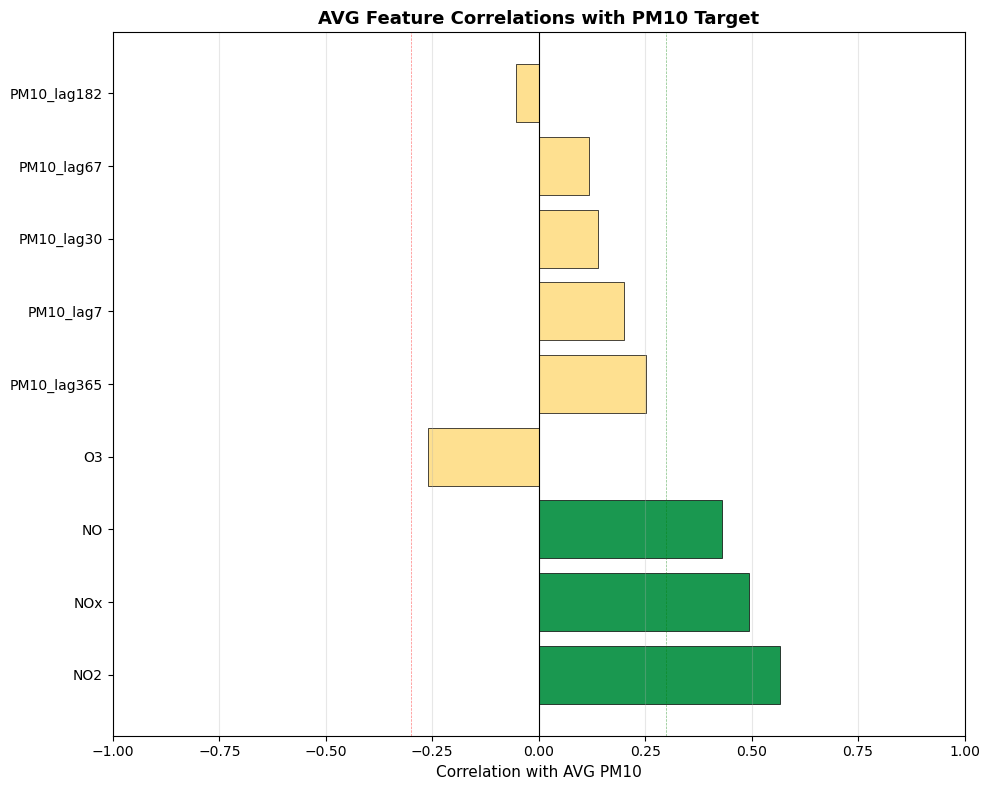

In [20]:
# Visualization of AVG feature correlations
corrs = station_correlations[AVG_LOCATION]

if len(corrs) == 0:
    print("No correlations to display. Please run the previous cell first and check for AVG features.")
else:
    signals = list(corrs.keys())
    values = list(corrs.values())
    
    fig, ax = plt.subplots(figsize=(10, max(8, len(signals) * 0.3)))
    
    colors = ['#d73027' if v < -0.3 else '#fee090' if abs(v) < 0.3 else '#1a9850' for v in values]
    y_pos = np.arange(len(signals))
    ax.barh(y_pos, values, color=colors, edgecolor='black', linewidth=0.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signals, fontsize=10)
    ax.set_xlabel('Correlation with AVG PM10', fontsize=11)
    ax.set_title(f'{AVG_LOCATION} Feature Correlations with PM10 Target', fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.axvline(x=0.3, color='green', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(x=-0.3, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xlim(-1, 1)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

**Interpretation – AVG feature correlations (d0):** Traffic-related gases lead: NO2 and NOx show the strongest positive association with average PM10 (|corr|≈0.57/0.50), followed by NO (0.43). O3 is moderately negative (–0.26), consistent with different photochemical regimes. Long lags add mild signal (best from 365d and 7d), while intermediate lags contribute less, suggesting seasonality plus short recency effects are most informative.

The common features might be enough to have a good predictive performance, if we find some heavy missingness in some of the uncommon features we might consider dropping them altogether, and impute only the common ones.

#### 3.2.2 Forecast Feature Correlation Analysis

#### 3.2.3 Forecast Feature Explanations

The forecast features come from **COSMO meteorological models** (COSMO and COSMO-2), which provide weather predictions for the Alpine region. These are **multi-day ahead forecasts** (step0 to step5) that can be used to predict future PM10 levels.

**Base COSMO Model Features**

| Signal | Full Name/Description | Relevance to PM10 |
|--------|----------------------|-------------------|
| **T_2M** | Temperature at 2 meters | Higher temperatures can increase PM10 through resuspension and secondary aerosol formation |
| **TD_2M** | Dew Point Temperature at 2m | Indicates humidity; high humidity can trap pollutants near ground level |
| **RELHUM_2M** | Relative Humidity at 2m | High RH reduces dispersion; low RH increases dust resuspension |
| **FF_10M** | Wind Speed at 10 meters | Higher wind speeds disperse pollutants; calm conditions trap PM10 |
| **DD_10M** | Wind Direction at 10m | Indicates pollutant transport direction from source regions |
| **PS** | Surface Pressure | High pressure = stable conditions = poor dispersion; low pressure = better mixing |
| **GLOB** | Global Solar Radiation | Strong radiation drives photochemistry and vertical mixing |
| **TOT_PREC** | Total Precipitation | Rain washes out PM10 (wet deposition); reduces concentrations |
| **CLCT** | Total Cloud Cover | Affects radiation, temperature gradients, and mixing layer height |

**COSMO-2 High-Resolution Features (`_c2` suffix)**

The features with **`_c2`** suffix come from the **COSMO-2 model**, which provides:
- **Higher spatial resolution** (~2.2 km vs ~7 km for COSMO)
- **Better representation of Alpine topography** (mountains, valleys)
- **More accurate forecasts for complex terrain**

Examples:
- `T_2M_c2`: High-resolution temperature forecast
- `TOT_PREC_c2`: Fine-scale precipitation patterns
- `PS_c2`: Localized pressure systems

**Key Meteorological Relationships**

**Temperature (T_2M, TD_2M)**
- ↑ Temperature → ↑ PM10 (resuspension, secondary formation)
- Large T_2M - TD_2M gap → Low humidity → More dust

**Wind (FF_10M, DD_10M)**
- ↑ Wind speed → ↓ PM10 (dispersion)
- Wind direction determines if pollution arrives from industrial/urban areas

**Pressure (PS)**
- High pressure systems → Temperature inversions → Trapped pollutants
- Low pressure → Vertical mixing → Better air quality

**Precipitation (TOT_PREC)**
- Rain → Washout effect → ↓ PM10
- Most effective PM10 removal mechanism

**Radiation & Clouds (GLOB, CLCT)**
- Strong radiation → Convective mixing → Disperses PM10
- Clouds → Reduced mixing → Can trap pollutants

**Forecast Horizons (step0 to step5)**

- **step0**: Current day forecast (0 days ahead)
- **step1**: Tomorrow's forecast (1 day ahead)
- **step2-step5**: 2-5 days ahead forecasts

FORECAST FEATURE CORRELATION ANALYSIS - IDENTIFYING MOST RELEVANT FEATURES:

Analyzing 16 forecast signals:
['CLCT', 'CLCT_c2', 'DD_10M', 'FF_10M', 'GLOB', 'GLOB_c2', 'PS', 'PS_c2', 'RELHUM_2M', 'RELHUM_2M_c2', 'TD_2M', 'TD_2M_c2', 'TOT_PREC', 'TOT_PREC_c2', 'T_2M', 'T_2M_c2']


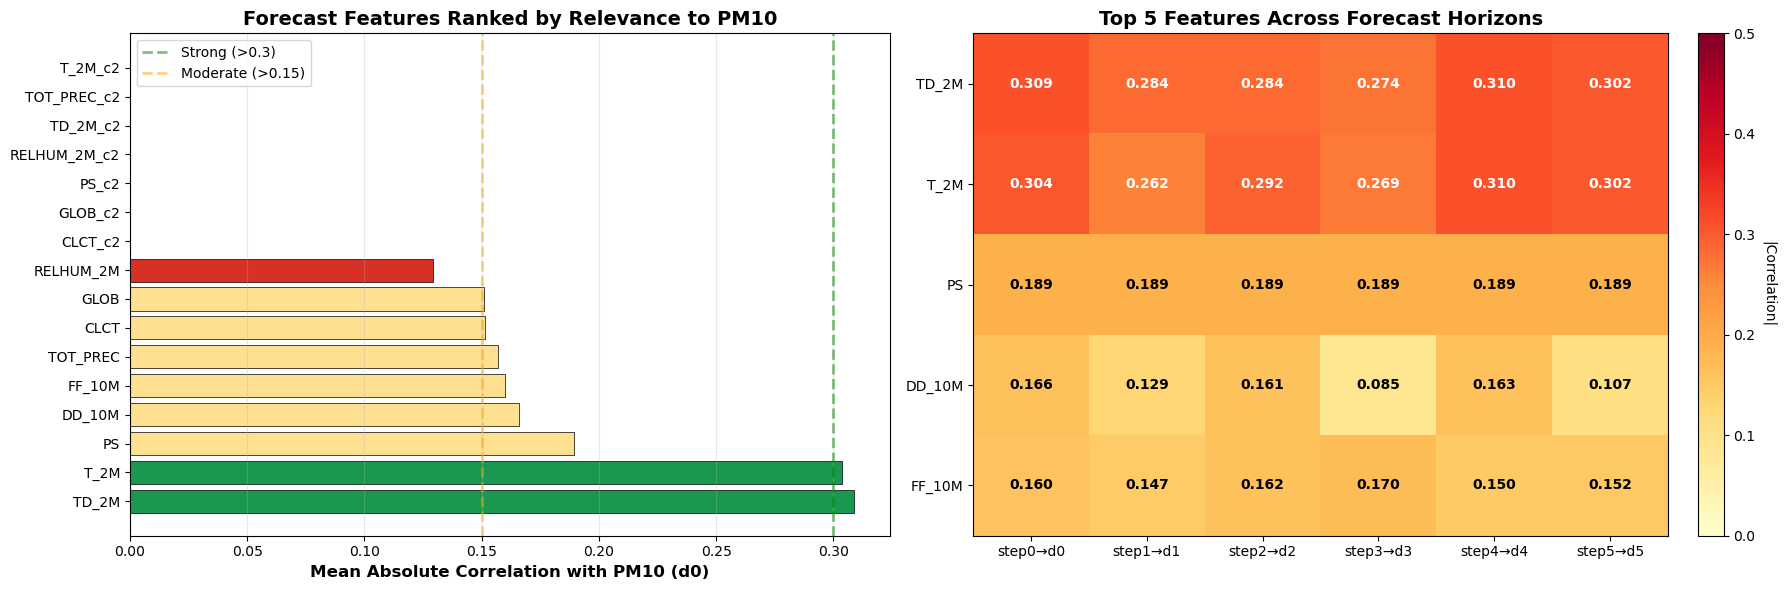

FORECAST FEATURE RANKING (step0→d0 correlation with PM10):
 1. TD_2M           → 0.3088 (STRONG)
 2. T_2M            → 0.3036 (STRONG)
 3. PS              → 0.1893 (MODERATE)
 4. DD_10M          → 0.1657 (MODERATE)
 5. FF_10M          → 0.1599 (MODERATE)
 6. TOT_PREC        → 0.1570 (MODERATE)
 7. CLCT            → 0.1515 (MODERATE)
 8. GLOB            → 0.1512 (MODERATE)
 9. RELHUM_2M       → 0.1291 (WEAK)
10. CLCT_c2         → 0.0000 (WEAK)
11. GLOB_c2         → 0.0000 (WEAK)
12. PS_c2           → 0.0000 (WEAK)
13. RELHUM_2M_c2    → 0.0000 (WEAK)
14. TD_2M_c2        → 0.0000 (WEAK)
15. TOT_PREC_c2     → 0.0000 (WEAK)
16. T_2M_c2         → 0.0000 (WEAK)
KEY INSIGHTS:

Top 5 most predictive forecast features: TD_2M, T_2M, PS, DD_10M, FF_10M
✓ Features with correlation > 0.3 are strongly relevant
✓ Consider feature selection based on these correlations
✓ COSMO-2 (_c2) vs base COSMO comparison available



In [21]:
print("FORECAST FEATURE CORRELATION ANALYSIS - IDENTIFYING MOST RELEVANT FEATURES:")

# Get all forecast signals
forecast_cols = [col for col in X_train.columns if FORECAST_PATTERN in col]
all_forecast_signals = sorted(set([extract_signal(col) for col in forecast_cols]))

print(f"\nAnalyzing {len(all_forecast_signals)} forecast signals:")
print(all_forecast_signals)

# Calculate correlation for each forecast signal with PM10 targets
# We'll use step0 → d0 (most direct relationship)
forecast_correlations = {}

for feat_signal in all_forecast_signals:
    # Get step0 forecast columns for this signal
    step0_cols = [col for col in X_train.columns if f'{COL_SEPARATOR}{feat_signal}{COL_SEPARATOR}{FORECAST_SUFFIX}0' in col]
    
    # Get d0 target columns (excluding average)
    d0_target_cols = [col for col in y_train.columns if AVG_LOCATION in col]
    
    if step0_cols and d0_target_cols:
        corrs = []
        for scol in step0_cols:
            for tcol in d0_target_cols:
                corr = X_train[scol].corr(y_train[tcol])
                if not pd.isna(corr):
                    corrs.append(abs(corr))
        
        if corrs:
            forecast_correlations[feat_signal] = np.mean(corrs)
        else:
            forecast_correlations[feat_signal] = 0
    else:
        forecast_correlations[feat_signal] = 0

# Sort by correlation strength
sorted_correlations = dict(sorted(forecast_correlations.items(), key=lambda x: x[1], reverse=True))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
signals = list(sorted_correlations.keys())
values = list(sorted_correlations.values())
colors = ['#1a9850' if v > 0.3 else '#fee090' if v > 0.15 else '#d73027' for v in values]

ax1.barh(signals, values, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Mean Absolute Correlation with PM10 (d0)', fontsize=12, fontweight='bold')
ax1.set_title('Forecast Features Ranked by Relevance to PM10', fontsize=14, fontweight='bold')
ax1.axvline(x=0.3, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Strong (>0.3)')
ax1.axvline(x=0.15, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Moderate (>0.15)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Correlation heatmap across all horizons for top features
top_n = 5
top_features = list(sorted_correlations.keys())[:top_n]

corr_matrix = np.zeros((top_n, 6))
for i, feat_signal in enumerate(top_features):
    for j, (step, horizon) in enumerate(zip([f'{FORECAST_SUFFIX}0', f'{FORECAST_SUFFIX}1', f'{FORECAST_SUFFIX}2', f'{FORECAST_SUFFIX}3', f'{FORECAST_SUFFIX}4', f'{FORECAST_SUFFIX}5'],
                                             ['d0', 'd1', 'd2', 'd3', 'd4', 'd5'])):
        step_cols = [col for col in X_train.columns if f'{COL_SEPARATOR}{feat_signal}{COL_SEPARATOR}{step}' in col]
        target_cols = [col for col in y_train.columns if AVG_LOCATION in col]
        
        if step_cols and target_cols:
            corrs = []
            for scol in step_cols:
                for tcol in target_cols:
                    corr = X_train[scol].corr(y_train[tcol])
                    if not pd.isna(corr):
                        corrs.append(abs(corr))
            if corrs:
                corr_matrix[i, j] = np.mean(corrs)

im = ax2.imshow(corr_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.5)
ax2.set_xticks(np.arange(6))
ax2.set_yticks(np.arange(top_n))
ax2.set_xticklabels([f'{FORECAST_SUFFIX}0→d0', f'{FORECAST_SUFFIX}1→d1', f'{FORECAST_SUFFIX}2→d2', f'{FORECAST_SUFFIX}3→d3', f'{FORECAST_SUFFIX}4→d4', f'{FORECAST_SUFFIX}5→d5'])
ax2.set_yticklabels(top_features)
ax2.set_title(f'Top {top_n} Features Across Forecast Horizons', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(top_n):
    for j in range(6):
        text = ax2.text(j, i, f'{corr_matrix[i, j]:.3f}',
                       ha="center", va="center",
                       color="white" if corr_matrix[i, j] > 0.25 else "black",
                       fontsize=10, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('|Correlation|', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print summary
print("FORECAST FEATURE RANKING (step0→d0 correlation with PM10):")
for i, (signal, corr) in enumerate(sorted_correlations.items(), 1):
    strength = "STRONG" if corr > 0.3 else "MODERATE" if corr > 0.15 else "WEAK"
    print(f"{i:2d}. {signal:<15} → {corr:.4f} ({strength})")

print("KEY INSIGHTS:")
print(f"""
Top {top_n} most predictive forecast features: {', '.join(top_features)}
✓ Features with correlation > 0.3 are strongly relevant
✓ Consider feature selection based on these correlations
✓ COSMO-2 ({COSMO2_SUFFIX}) vs base COSMO comparison available
""")

**Interpretation – forecast feature relevance:** Temperature forecasts (T_2M, TD_2M) are the only strongly correlated predictors (~0.30) across horizons; pressure has modest value (~0.19), while wind and precipitation signals are weak to moderate. The heatmap shows stable, low correlations beyond temperature, implying forecast inputs add limited incremental power versus measurement-based features and PM10 lags.

For the moment we will use only the common features across all the locations to reduce the amount of missing data we have to impute and the complexity of the model. Moreover forecast features are less correlated with the target than the measurements at m0, so we can expect a smaller contribution to the predictive power of the model.

## 4. Data Quality & Preprocessing

### 4.1 Missing Values Analysis

#### 4.1.1 Missing Values by Feature Type

In [22]:
missing_features_perc = (X_train.isnull().sum() / len(X_train)) * 100
missing_targets_perc = (y_train.isnull().sum() / len(y_train)) * 100
missing_features_perc = missing_features_perc[missing_features_perc > 0].sort_values(ascending=False)
missing_targets_perc = missing_targets_perc[missing_targets_perc > 0].sort_values(ascending=False)


#### 4.1.2 Measurement Features Missingness

In [23]:
# Analyze daily mean measurement features (not forecasts)
daily_mean_missing = missing_features_perc[missing_features_perc.index.str.contains(DAILY_MEAN_SUFFIX)]
print(f"Daily mean measurement features with missing values: {len(daily_mean_missing)}")

#top n missing features
n = 30
print(f"Top {n} missing daily mean feature columns:")
print(daily_mean_missing.head(n))

Daily mean measurement features with missing values: 34
Top 30 missing daily mean feature columns:
LUG__PM2.5__daily_mean       6.140008
NA-MAG__PM2.5__daily_mean    6.100899
GIU__Tdew__daily_mean        1.955417
GIU__RH__daily_mean          1.955417
GIU__WSgust__daily_mean      0.821275
GIU__Gl__daily_mean          0.743058
GIU__O3__daily_mean          0.430192
BIO__WDvect__daily_mean      0.234650
MEN__Prec__daily_mean        0.234650
GIU__T__daily_mean           0.195542
NA-MAG__NO2__daily_mean      0.156433
NA-MAG__NOx__daily_mean      0.156433
NA-MAG__NO__daily_mean       0.156433
CHI__WS__daily_mean          0.117325
CHI__WD__daily_mean          0.117325
BIO__WSvect__daily_mean      0.117325
BIO__RH__daily_mean          0.117325
BIO__O3__daily_mean          0.117325
LUG__NO__daily_mean          0.117325
LUG__NO2__daily_mean         0.117325
LUG__NOx__daily_mean         0.117325
LUG__O3__daily_mean          0.117325
NA-MAG__O3__daily_mean       0.078217
MEN__NOx__daily_mean       

**Interpretation – daily mean missingness:** Most daily-mean features are nearly complete (30/34 with <1% missing); only 2 features exceed 5%. Imputation should be lightweight and unlikely to distort distributions.

In [24]:
# Summary statistics for daily mean features
print(f"\nDaily mean features missingness summary:")
print(f"  Total daily mean features: {len(daily_mean_missing)}")
print(f"  Features with <1% missing: {(daily_mean_missing < 1).sum()}")
print(f"  Features with 1-5% missing: {((daily_mean_missing >= 1) & (daily_mean_missing < 5)).sum()}")
print(f"  Features with >5% missing: {(daily_mean_missing >= 5).sum()}")


Daily mean features missingness summary:
  Total daily mean features: 34
  Features with <1% missing: 30
  Features with 1-5% missing: 2
  Features with >5% missing: 2


**Interpretation – forecast missingness:** Forecast inputs have many columns but low per-column gaps (worst ≈2.1%). Systematic, shallow missingness suggests simple imputation (per-feature temporal fill or station mean) will recover most signals without heavy bias.

#### 4.1.3 Forecast Features Missingness

In [25]:
forecast_missing = missing_features_perc[missing_features_perc.index.str.contains(FORECAST_PATTERN)]
print(f"Forecast features with missing values: {len(forecast_missing)}")
print(forecast_missing.head(10))

Forecast features with missing values: 1848
TIGIU__RELHUM_2M__step30    2.150958
TIGIU__RELHUM_2M__step6     2.150958
TIGIU__TD_2M__step6         2.150958
TIGIU__TD_2M__step30        2.150958
TIGIU__TD_2M__step1         2.111850
TIGIU__TD_2M__step5         2.111850
TIGIU__TD_2M__step3         2.111850
TIGIU__TD_2M__step2         2.111850
TIGIU__TD_2M__step25        2.111850
TIGIU__TD_2M__step26        2.111850
dtype: float64


**Interpretation – target missingness:** PM10 targets are very complete; only two stations (LOC, MEN) show ~0.35% gaps across horizons. Dropping those timestamps or light interpolation will have negligible impact on training size.

#### 4.1.4 Target Missingness

In [26]:
target_missing = missing_targets_perc
print(f"Target columns with missing values: {len(target_missing)}")
print(target_missing.head(10))
# these are going to be recreated using imputed values later

Target columns with missing values: 36
LOC__YPM10-dailymean__d5    0.351975
LOC__YPM10-dailymean__d4    0.351975
LOC__YPM10-dailymean__d1    0.351975
LOC__YPM10-dailymean__d0    0.351975
LOC__YPM10-dailymean__d2    0.351975
LOC__YPM10-dailymean__d3    0.351975
MEN__YPM10-dailymean__d1    0.312867
MEN__YPM10-dailymean__d0    0.312867
MEN__YPM10-dailymean__d3    0.312867
MEN__YPM10-dailymean__d2    0.312867
dtype: float64


### 4.2 Missing Value Imputation Strategy

Potential strategies for missing value imputation include:
- Simple methods: mean, median, mode imputation
- Advanced methods: KNN imputation, MICE, Time series specific methods (e.g., forward fill, interpolation)

If we want to use forward fill or interpolation, we need to ensure that there are no large gaps in the time index.

In [27]:
#checks for gaps in time index
time_diffs = df.index.to_series().diff().dropna()
gap_threshold = pd.Timedelta(hours=24) #we check for daily gaps since data is daily
gaps = time_diffs[time_diffs > gap_threshold]
if not gaps.empty:
    print("Gaps detected in time index:")
    print(gaps)
else:
    print("No gaps detected in time index.")


No gaps detected in time index.


**Interpretation – time index:** No gaps detected in the daily index, so resampling is unnecessary and rolling/lag features remain aligned without further correction.

We will focus on imputing common features across all locations to maintain consistency and reduce complexity in the imputation process.

In [28]:
#check the amount of consecutive missing values per column
#only for the daily_mean features not considering the forecasts
def max_consecutive_nans(series):
    return series.isnull().astype(int).groupby(series.notnull().astype(int).cumsum()).sum().max()

#look only the common daily_mean features across all stations
common_daily_mean_cols = [make_daily_mean_col(loc, feat) for feat in common_features for loc in locations if make_daily_mean_col(loc, feat) in X_train.columns]
consecutive_nans_measurements = X_train[common_daily_mean_cols].apply(max_consecutive_nans)
consecutive_nans_forecasts = X_train[[col for col in features_cols if FORECAST_PATTERN in col]].apply(max_consecutive_nans)
consecutive_nans_targets = y_train.apply(max_consecutive_nans)

print("Top 10 measurement features with highest consecutive missing values:")
print(consecutive_nans_measurements.sort_values(ascending=False).head(10))
print("Top 10 forecast features with highest consecutive missing values:")
print(consecutive_nans_forecasts.sort_values(ascending=False).head(10))
print("Top 10 target features with highest consecutive missing values:")
print(consecutive_nans_targets.sort_values(ascending=False).head(10))

Top 10 measurement features with highest consecutive missing values:
GIU__O3__daily_mean        9
NA-MAG__NOx__daily_mean    2
BIO__O3__daily_mean        2
LUG__NOx__daily_mean       2
NA-MAG__NO2__daily_mean    2
NA-MAG__NO__daily_mean     2
LUG__NO2__daily_mean       2
LUG__NO__daily_mean        2
LUG__O3__daily_mean        2
MEN__NO__daily_mean        1
dtype: int64
Top 10 forecast features with highest consecutive missing values:
TIGIU__RELHUM_2M_c2__step81    46
TIGIU__RELHUM_2M__step25       46
TIGIU__RELHUM_2M__step26       46
TIGIU__RELHUM_2M__step27       46
TIGIU__TD_2M__step7            46
TIGIU__TD_2M__step6            46
TIGIU__TD_2M__step5            46
TIGIU__RELHUM_2M__step28       46
TIGIU__RELHUM_2M__step29       46
TIGIU__TD_2M__step4            46
dtype: int64
Top 10 target features with highest consecutive missing values:
LOC__YPM10-dailymean__d4    9
LOC__YPM10-dailymean__d5    9
LOC__YPM10-dailymean__d2    9
LOC__YPM10-dailymean__d3    9
LOC__YPM10-dailymean__d0 

#### 4.2.1 Spatial Imputation Using Location Grouping

We will use spatial imputation by grouping by similar location and imputing missing values.

In [29]:
print(common_features)

{'NOx', 'PM10_lag182', 'PM10_lag30', 'NO2', 'PM10_lag365', 'NO', 'O3', 'PM10_lag67', 'PM10_lag7'}


**Interpretation – common feature set:** After cleaning, nine robust features remain shared across all stations (NO, NO2, NOx, O3, and five PM10 lag variants). This ensures consistent modeling inputs for clustering and cross-location training.

LOCATION GROUPING - HIERARCHICAL CLUSTERING APPROACH
Analyzing 9 common features: ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag182', 'PM10_lag30', 'PM10_lag365', 'PM10_lag67', 'PM10_lag7']


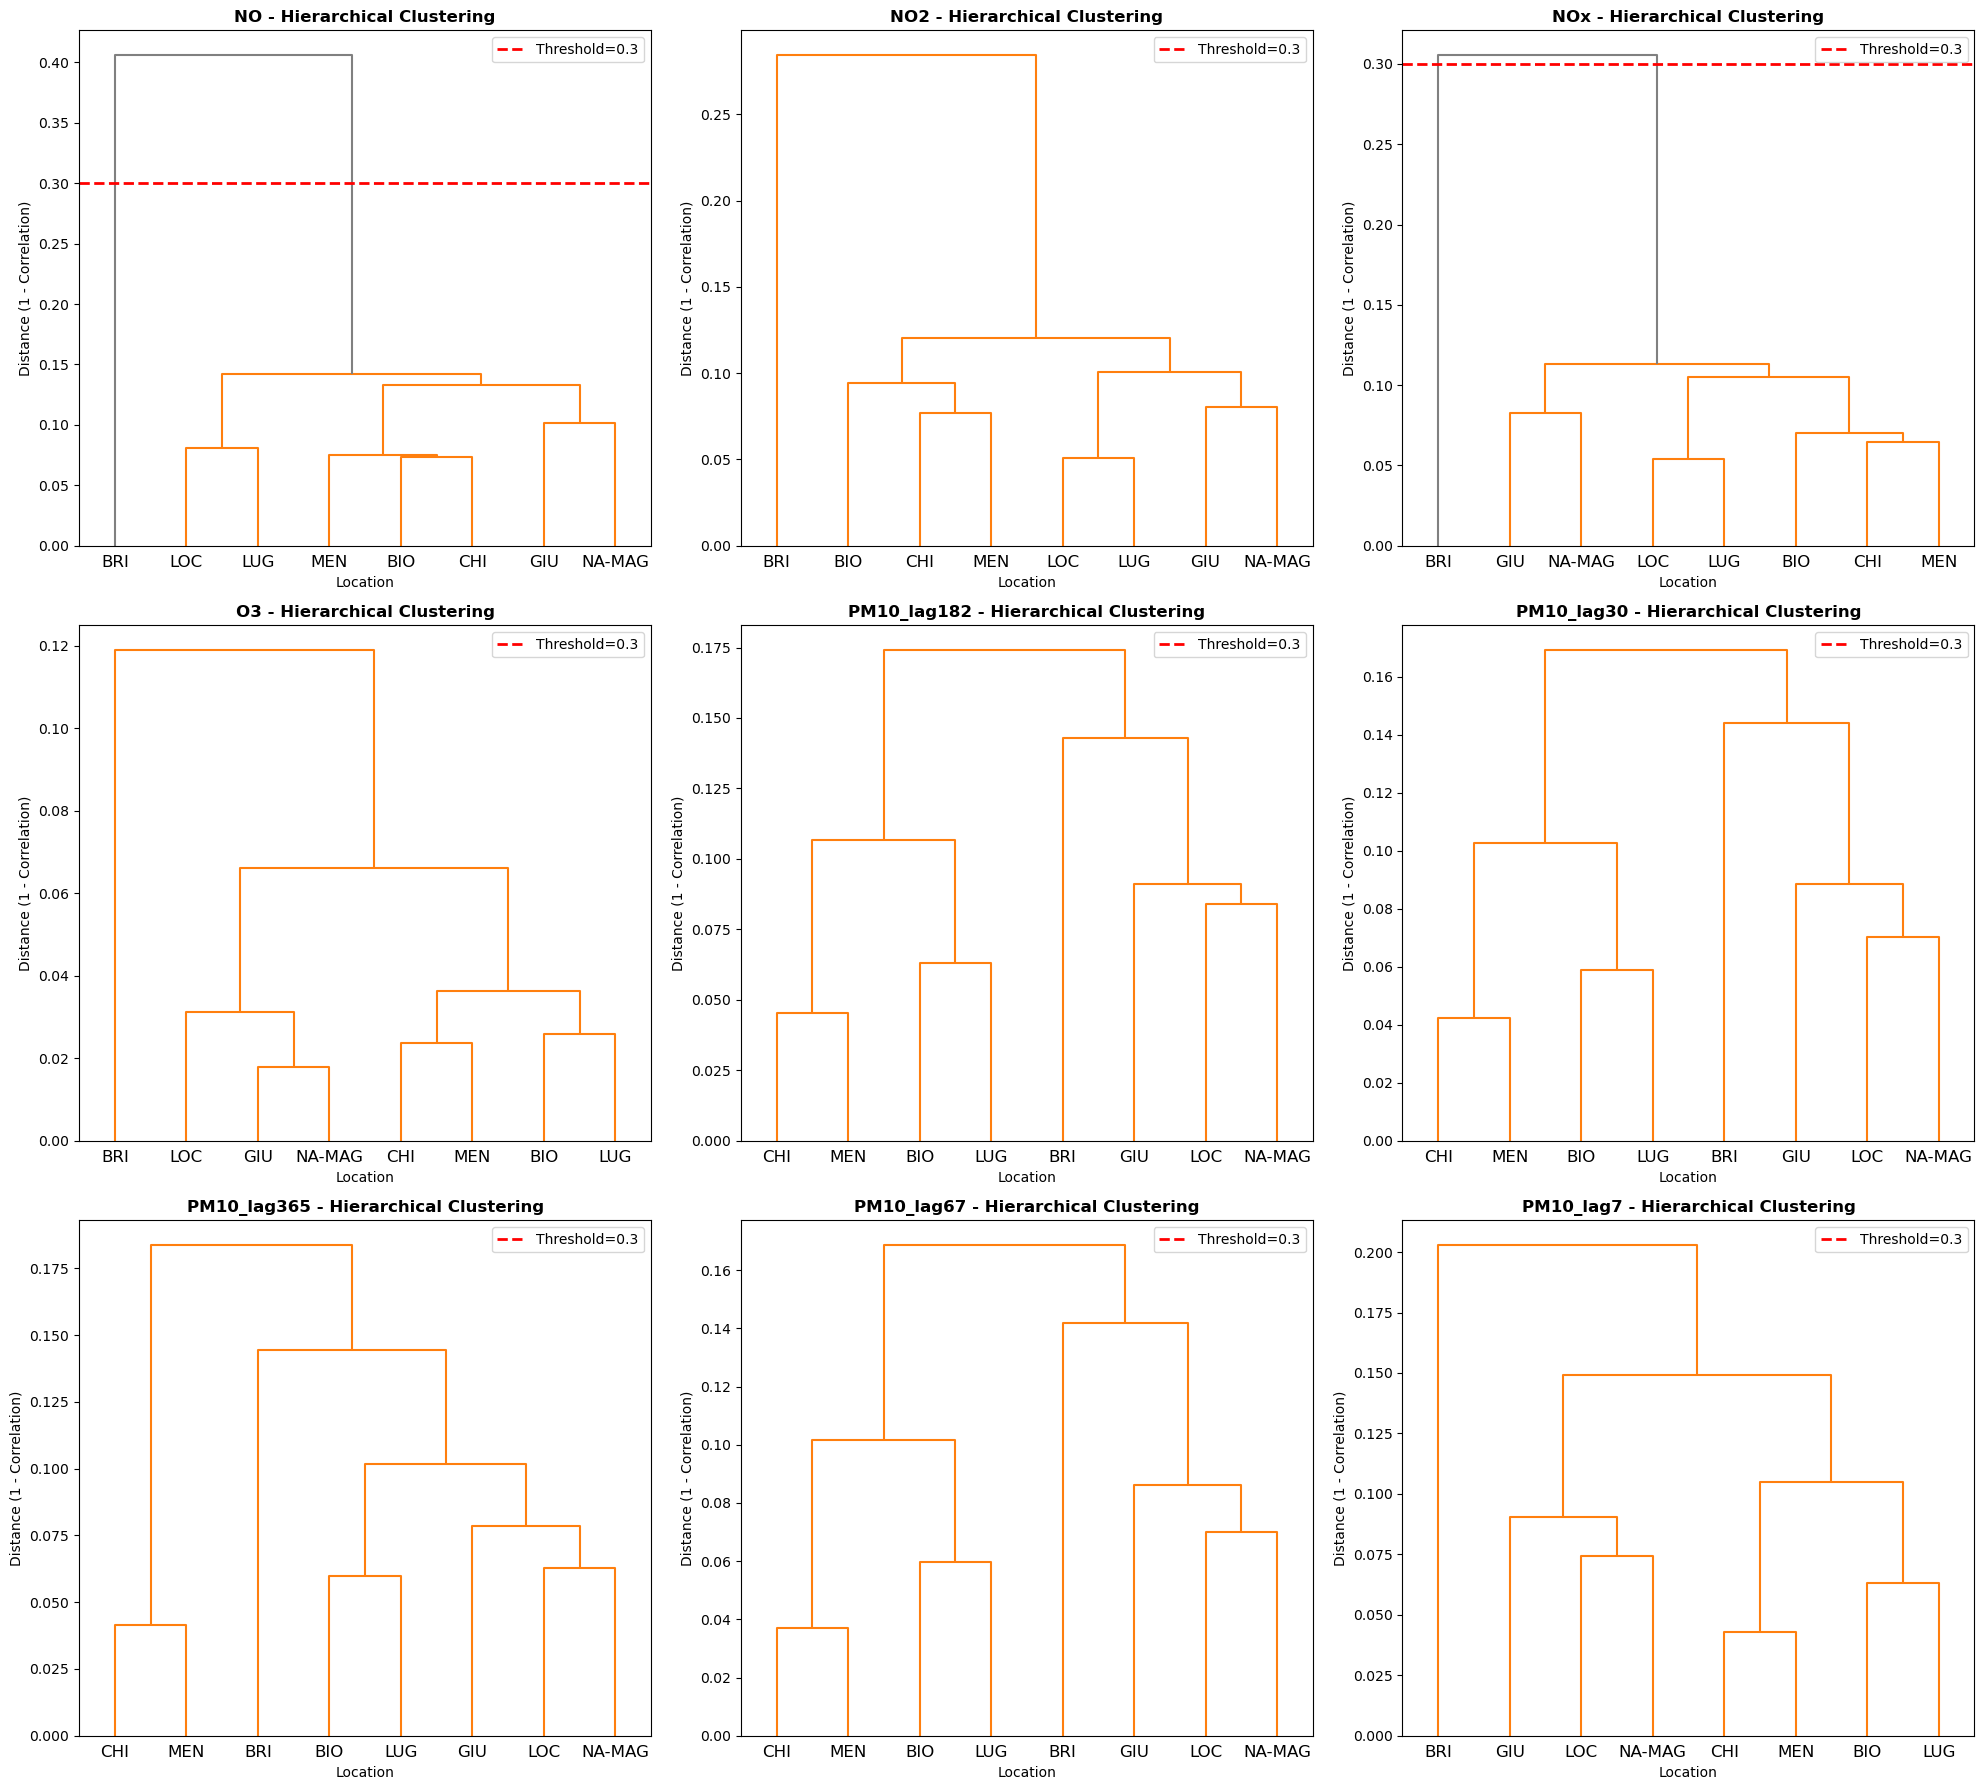

IDENTIFIED CLUSTERS (forced into 2 groups):

NO:
  Cluster 1: ['BIO', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
  Cluster 2: ['BRI']

NO2:
  Cluster 1: ['BIO', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
  Cluster 2: ['BRI']

NOx:
  Cluster 1: ['BIO', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
  Cluster 2: ['BRI']

O3:
  Cluster 1: ['BIO', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
  Cluster 2: ['BRI']

PM10_lag182:
  Cluster 1: ['BIO', 'CHI', 'LUG', 'MEN']
  Cluster 2: ['BRI', 'GIU', 'LOC', 'NA-MAG']

PM10_lag30:
  Cluster 1: ['BIO', 'CHI', 'LUG', 'MEN']
  Cluster 2: ['BRI', 'GIU', 'LOC', 'NA-MAG']

PM10_lag365:
  Cluster 1: ['CHI', 'MEN']
  Cluster 2: ['BIO', 'BRI', 'GIU', 'LOC', 'LUG', 'NA-MAG']

PM10_lag67:
  Cluster 1: ['BIO', 'CHI', 'LUG', 'MEN']
  Cluster 2: ['BRI', 'GIU', 'LOC', 'NA-MAG']

PM10_lag7:
  Cluster 1: ['BIO', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
  Cluster 2: ['BRI']
CONSENSUS ANALYSIS ACROSS FEATURES:

Location pairs co-occurring in same cluster:
  B

In [30]:
# Justify location grouping using hierarchical clustering
print("LOCATION GROUPING - HIERARCHICAL CLUSTERING APPROACH")

# Use all common features for clustering analysis
features_to_analyze = sorted(list(common_features))
print(f"Analyzing {len(features_to_analyze)} common features: {features_to_analyze}")

# Calculate grid size for subplots
n_features = len(features_to_analyze)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Store cluster assignments for each feature
all_cluster_assignments = {}

for idx, feat in enumerate(features_to_analyze):
    ax = axes[idx]
    
    # Get columns for this feature across all locations (using daily_mean)
    # Ensure consistent ordering by sorting locations
    sorted_locs = sorted(locations)
    feat_cols = [make_daily_mean_col(loc, feat) for loc in sorted_locs if make_daily_mean_col(loc, feat) in X_train.columns]
    
    if not feat_cols:
        ax.set_visible(False)
        continue
    
    # Calculate correlation matrix
    corr_matrix = X_train[feat_cols].corr()
    
    # Convert correlation to distance (1 - correlation) because linkage expects a distance matrix
    distance_matrix = 1 - corr_matrix
    condensed_dist = squareform(distance_matrix)
    
    # Perform hierarchical clustering with no optimal ordering
    linkage_matrix = linkage(condensed_dist, method='average', optimal_ordering=False)
    
    # Create dendrogram - extract labels in consistent order
    loc_labels = [extract_location(col) for col in feat_cols]
    dendrogram(linkage_matrix, labels=loc_labels, ax=ax, 
               color_threshold=0.3, above_threshold_color='gray',
               no_plot=False)
    
    ax.set_title(f'{feat} - Hierarchical Clustering', fontsize=12, fontweight='bold')
    ax.set_xlabel('Location', fontsize=10)
    ax.set_ylabel('Distance (1 - Correlation)', fontsize=10)
    ax.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold=0.3')
    ax.legend()
    
    # Extract clusters for this feature (force exactly 2 clusters)
    n_clusters = 2
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    # Map back to sorted location order to maintain consistency
    all_cluster_assignments[feat] = dict(zip(loc_labels, clusters))

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Print identified clusters per feature
print("IDENTIFIED CLUSTERS (forced into 2 groups):")

for feat in features_to_analyze:
    if feat not in all_cluster_assignments:
        continue
    
    print(f"\n{feat}:")
    cluster_dict = {}
    for loc, cluster_id in all_cluster_assignments[feat].items():
        if cluster_id not in cluster_dict:
            cluster_dict[cluster_id] = []
        cluster_dict[cluster_id].append(loc)
    
    for cluster_id, locs in sorted(cluster_dict.items()):
        print(f"  Cluster {cluster_id}: {locs}")

# Find consensus grouping: count how often each pair co-occurs
print("CONSENSUS ANALYSIS ACROSS FEATURES:")

# Initialize pair counts such that we can count co-occurrences
# Use sorted locations to ensure consistent ordering
sorted_locs = sorted(locations)
location_pairs = {}
for loc1 in sorted_locs:
    for loc2 in sorted_locs:
        if loc1 < loc2:
            location_pairs[(loc1, loc2)] = 0

# Count co-occurrences
# For each feature, for each cluster, increment pair counts
# if two locations are in the same cluster for a feature, increment their pair count
for feat, assignments in all_cluster_assignments.items():
    cluster_dict = {}
    for loc, cluster_id in assignments.items():
        if cluster_id not in cluster_dict:
            cluster_dict[cluster_id] = []
        cluster_dict[cluster_id].append(loc)
    
    for locs in cluster_dict.values():
        for i, loc1 in enumerate(locs):
            for loc2 in locs[i+1:]:
                pair = tuple(sorted([loc1, loc2]))
                if pair in location_pairs:
                    location_pairs[pair] += 1

# Show pairs that cluster together consistently
print("\nLocation pairs co-occurring in same cluster:")
for pair, count in sorted(location_pairs.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"  {pair[0]}-{pair[1]}: {count}/{len(features_to_analyze)} features")

# Derive final groups using majority voting
# For each location, count which cluster (1 or 2) it appears in most often
# Use sorted locations for consistent ordering
sorted_locs = sorted(locations)
location_cluster_votes = {loc: [] for loc in sorted_locs}

for feat, assignments in all_cluster_assignments.items():
    for loc, cluster_id in assignments.items():
        location_cluster_votes[loc].append(cluster_id)

# Assign each location to the cluster it appears in most frequently
final_cluster_assignment = {}
for loc, votes in location_cluster_votes.items():
    if votes:
        # Get most common cluster
        most_common_cluster = Counter(votes).most_common(1)[0][0]
        final_cluster_assignment[loc] = most_common_cluster

# Group locations by final cluster
final_groups = defaultdict(list)
for loc, cluster_id in final_cluster_assignment.items():
    final_groups[cluster_id].append(loc)

# Convert to sorted list
final_groups = [sorted(locs) for locs in final_groups.values()]

print("FINAL PROPOSED GROUPING (2 groups via majority voting):")
for i, group in enumerate(final_groups, 1):
    print(f"  Group {i}: {group}")

# Save for later use
location_groups = {f'group{i+1}': group for i, group in enumerate(final_groups)}

**Interpretation – clustering rationale:** With the nine common features, dendrograms split stations into two coherent groups with high within-group similarity (correlations mostly >0.8) and modest between-group links. This supports using grouped imputation/modeling to share strength while respecting location differences.
Given that the the groups are not perfectly balanced (3 vs 6 stations), we might consider re-evaluating the grouping using geographic proximity or domain knowledge to ensure optimal imputation and modeling performance.

Lower Ticino (Sottoceneri)	LUG, CHI, MEN, BIO	Lugano and Mendrisio districts.

Lake Maggiore (Locarnese)	LOC, BRI, NA-MAG	The Locarno basin and lakeside towns.

Bellinzona Gate	GIU	The transition point between North and South Ticino.


Validating grouping with 7 common features


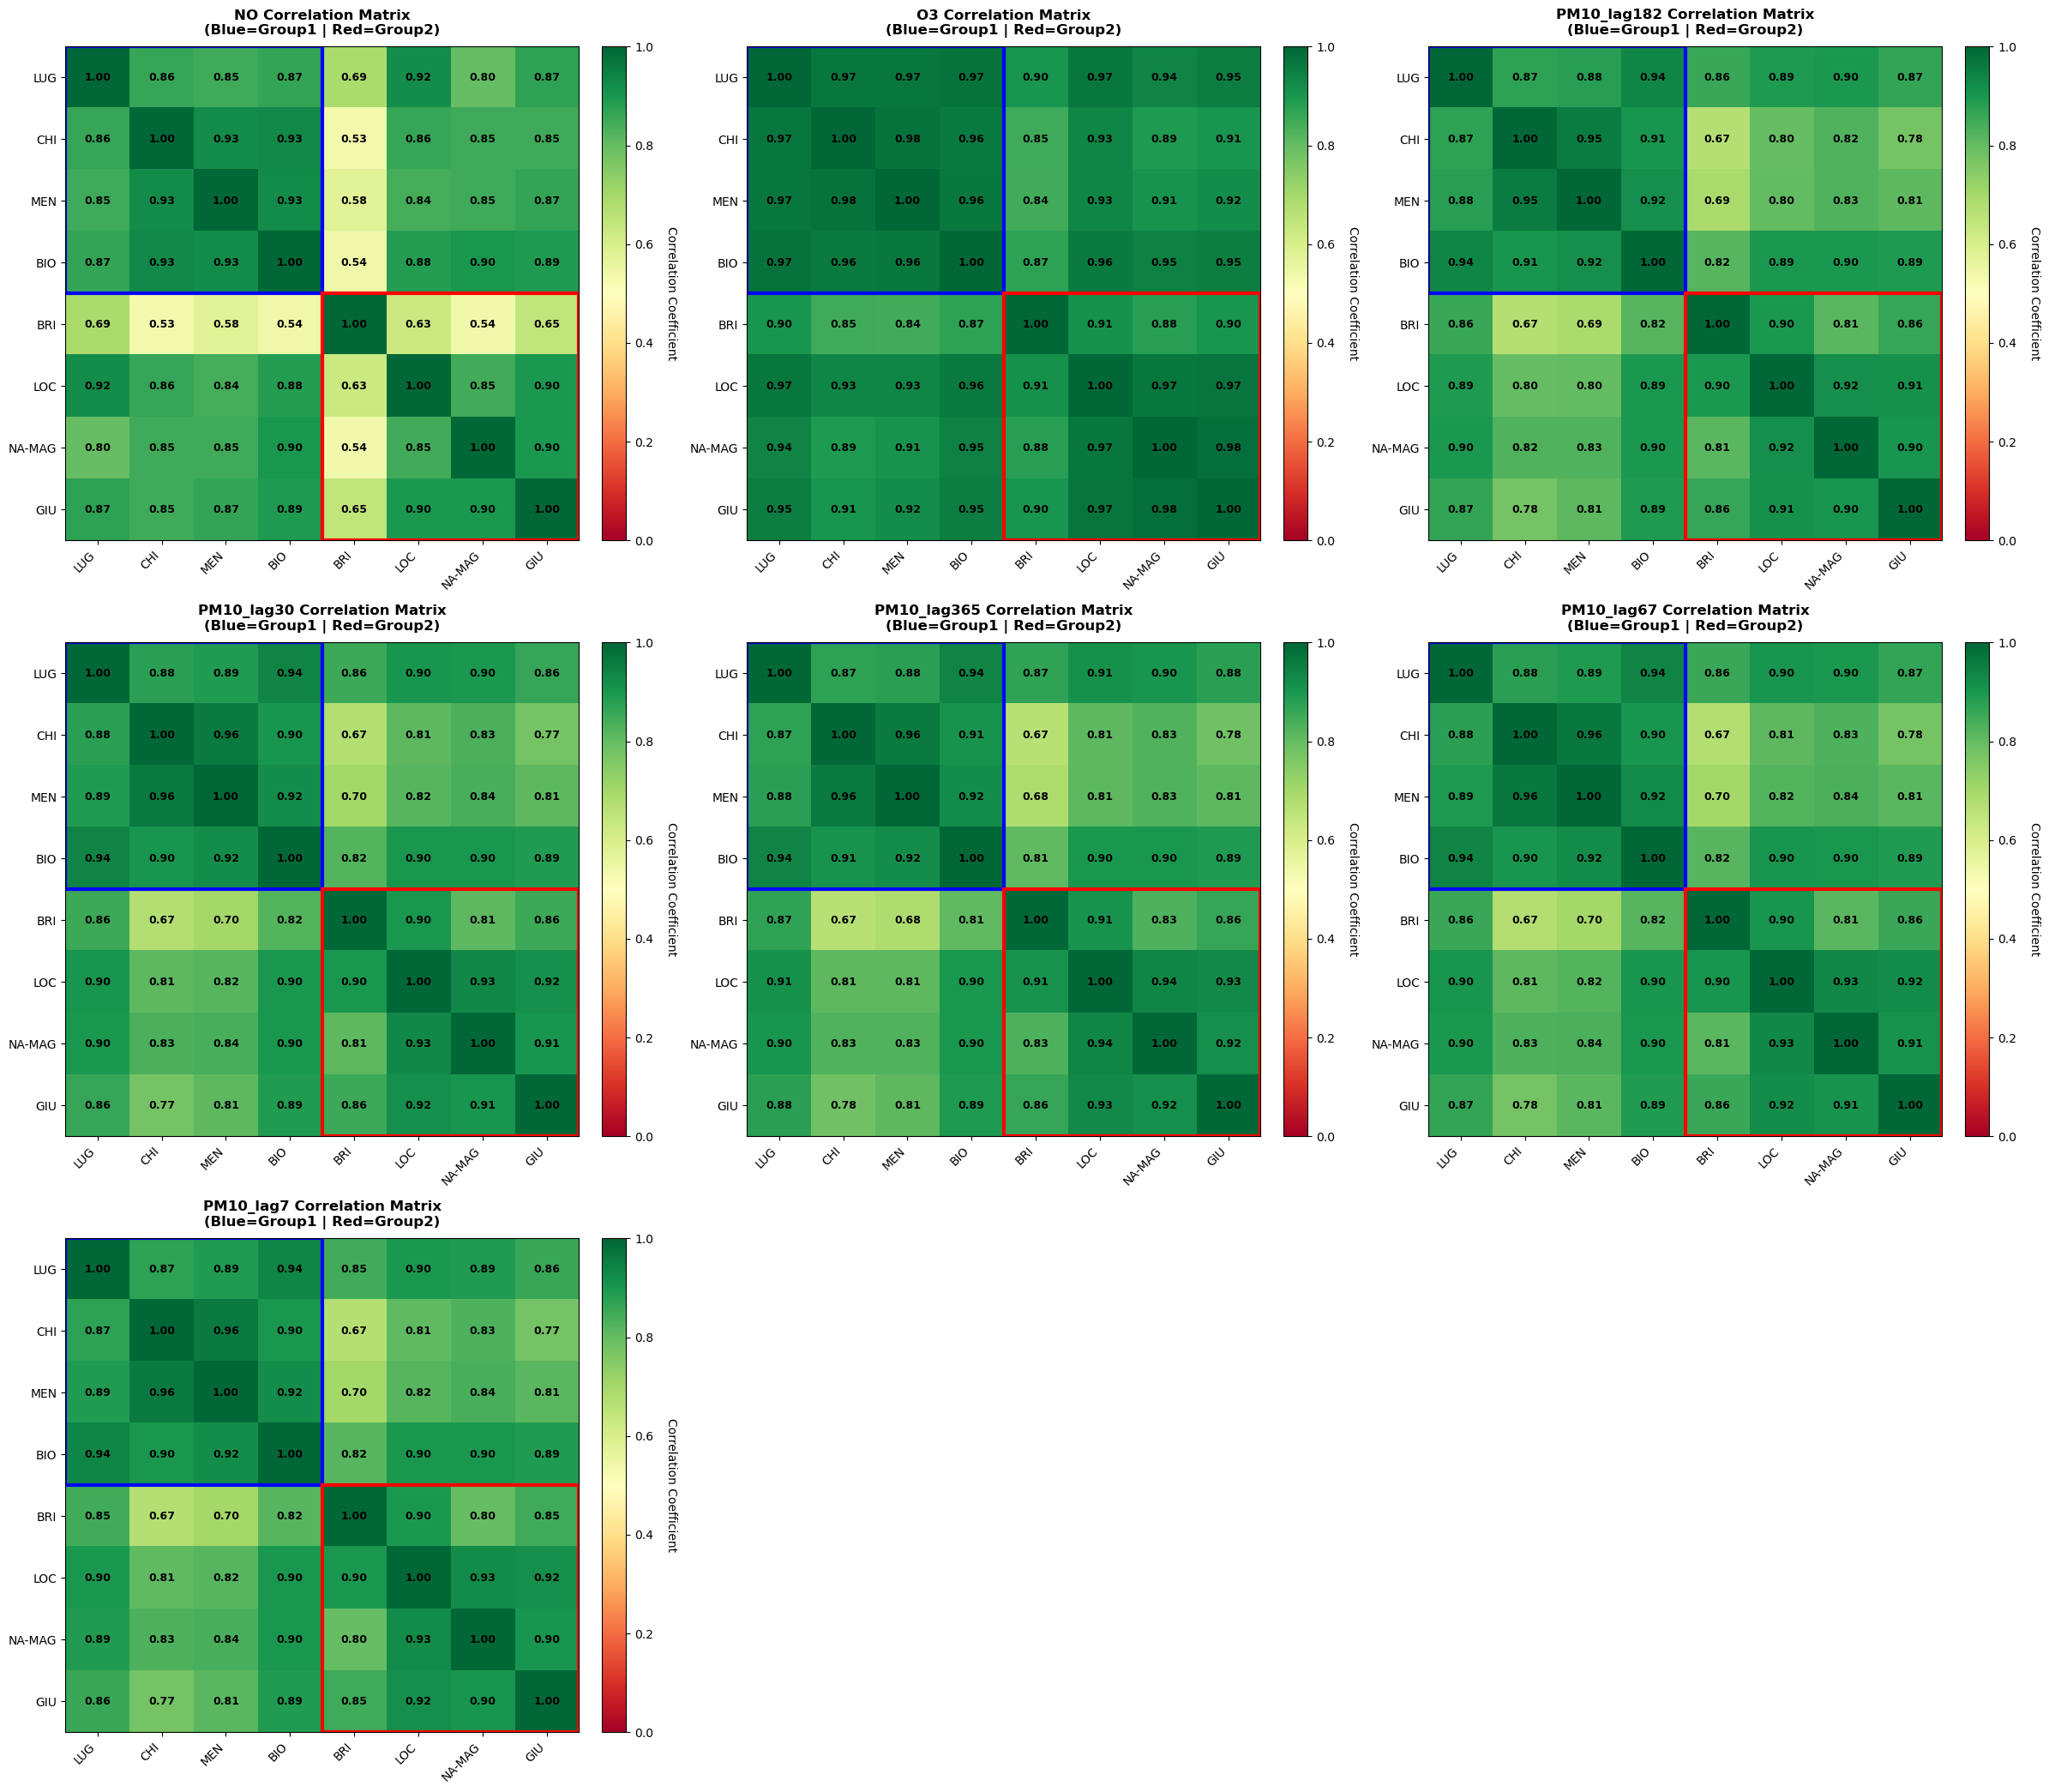

In [64]:
# Verify grouping with heatmaps showing correlation within/across groups

# Use the groups derived from clustering (or define manually if needed)
# Note: location_groups should already be defined from the previous cell
# If not, uncomment the following:
location_groups = {
    'group1': ['LUG', 'CHI', 'MEN', 'BIO'], # these are the locations 
    'group2': ['BRI', 'LOC', 'NA-MAG', 'GIU']
}

# Create heatmaps for all common features
features_for_validation = sorted(list(common_features))
print(f"Validating grouping with {len(features_for_validation)} common features")

# Calculate grid size for subplots
n_features = len(features_for_validation)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 7 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feat in enumerate(features_for_validation):
    ax = axes[idx]
    
    # Get feature columns for all locations (using daily_mean)
    feat_cols = [make_daily_mean_col(loc, feat) for loc in locations if make_daily_mean_col(loc, feat) in X_train.columns]
    
    if not feat_cols:
        ax.set_visible(False)
        continue
    
    # Calculate correlation matrix
    corr_matrix = X_train[feat_cols].corr()
    
    # Reorder to group locations together
    ordered_locs = location_groups['group1'] + location_groups['group2']
    ordered_cols = [make_daily_mean_col(loc, feat) for loc in ordered_locs if make_daily_mean_col(loc, feat) in feat_cols]
    corr_matrix = corr_matrix.loc[ordered_cols, ordered_cols]
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Set ticks
    loc_labels = [extract_location(col) for col in ordered_cols]
    ax.set_xticks(np.arange(len(ordered_cols)))
    ax.set_yticks(np.arange(len(ordered_cols)))
    ax.set_xticklabels(loc_labels, fontsize=10, rotation=45, ha='right')
    ax.set_yticklabels(loc_labels, fontsize=10)
    
    # Add text annotations
    for i in range(len(ordered_cols)):
        for j in range(len(ordered_cols)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", 
                          color="white" if corr_matrix.iloc[i, j] < 0.5 else "black",
                          fontsize=9, fontweight='bold')
    
    # Draw rectangles around groups
    n_group1 = len([loc for loc in location_groups['group1'] if make_daily_mean_col(loc, feat) in feat_cols])
    
    # Group 1 rectangle (top-left)
    rect1 = Rectangle((-0.5, -0.5), n_group1, n_group1, 
                      linewidth=3, edgecolor='blue', facecolor='none', label='Group 1')
    ax.add_patch(rect1)
    
    # Group 2 rectangle (bottom-right)
    rect2 = Rectangle((n_group1-0.5, n_group1-0.5), 
                      len(ordered_cols)-n_group1, len(ordered_cols)-n_group1,
                      linewidth=3, edgecolor='red', facecolor='none', label='Group 2')
    ax.add_patch(rect2)
    
    ax.set_title(f'{feat} Correlation Matrix\n(Blue=Group1 | Red=Group2)', 
                 fontsize=12, fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

**Interpretation – correlation validation:** Heatmaps confirm strong intra-group correlations (>0.8) across all common features and lags, with slightly lower cross-group links. The grouping is therefore stable and feature-agnostic, making it suitable for imputation and model pooling.

In [32]:
# Create copies to avoid modifying original data
X_train_imputed = X_train.copy()
y_train_imputed = y_train.copy()


In [33]:
# At the top of the imputation cell
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [34]:
# Step 1: Impute common features (daily_mean) using spatial grouping with daily mean
print("IMPUTING COMMON FEATURES (daily_mean) WITH SPATIAL GROUPING - DAILY MEAN APPROACH:")

for feat in sorted(common_features):
    print(f"\nProcessing {feat}...")
    
    # All available daily mean columns for this feature across stations
    feature_cols = [
        make_daily_mean_col(loc, feat)
        for loc in locations
        if make_daily_mean_col(loc, feat) in X_train_imputed.columns
    ]
    
    if not feature_cols:
        print("  No columns found for this feature")
        continue
    
    for group_name, group_locs in location_groups.items():
        # Get columns for this feature and group (using daily_mean)
        group_cols = [make_daily_mean_col(loc, feat) for loc in group_locs
                     if make_daily_mean_col(loc, feat) in X_train_imputed.columns]
        
        if not group_cols:
            continue
        
        # Count missing values before imputation
        missing_before = X_train_imputed[group_cols].isnull().sum().sum()
        
        if missing_before == 0:
            print(f"  {group_name}: No missing values")
            continue
        
        print(f"  {group_name}: {missing_before} missing values to impute")
        
        # For each day, calculate mean across available stations in the group
        # and use it to fill missing values
        for col in group_cols:
            # Get the column data
            col_data = X_train_imputed[col].copy()
            
            # Find rows where this column is missing
            missing_mask = col_data.isnull()
            
            if not missing_mask.any():
                continue
            
            # For each missing value, calculate mean of other stations on that day
            for idx in col_data[missing_mask].index:
                # Get values from all other stations in the group on this day
                other_cols = [c for c in group_cols if c != col]
                day_values = X_train_imputed.loc[idx, other_cols]
                
                # Calculate mean (ignoring NaNs)
                if day_values.notna().any():
                    col_data.loc[idx] = day_values.mean()
            
            # Update the column
            X_train_imputed[col] = col_data
        
        missing_after = X_train_imputed[group_cols].isnull().sum().sum()
        print(f"  {group_name}: {missing_after} missing values remaining after group imputation")
    
    # Replace any remaining NaNs with the mean for that day across all stations
    # This keeps the fill intra-day and avoids temporal leakage from forward/backward fill
    feature_daily_mean = X_train_imputed[feature_cols].mean(axis=1, skipna=True)
    remaining_missing_before = X_train_imputed[feature_cols].isnull().sum().sum()
    if remaining_missing_before > 0:
        X_train_imputed[feature_cols] = X_train_imputed[feature_cols].apply(
            lambda col: col.fillna(feature_daily_mean)
        )
        remaining_missing_after = X_train_imputed[feature_cols].isnull().sum().sum()
        resolved = remaining_missing_before - remaining_missing_after
        print(f"  Daily mean fill resolved {resolved} additional missing values")
    else:
        print("  No remaining missing values after group imputation")

IMPUTING COMMON FEATURES (daily_mean) WITH SPATIAL GROUPING - DAILY MEAN APPROACH:

Processing NO...
  group1: 1 missing values to impute
  group1: 0 missing values remaining after group imputation
  group2: 7 missing values to impute
  group2: 0 missing values remaining after group imputation
  No remaining missing values after group imputation

Processing NO2...
  group1: 1 missing values to impute
  group1: 0 missing values remaining after group imputation
  group2: 7 missing values to impute
  group2: 0 missing values remaining after group imputation
  No remaining missing values after group imputation

Processing NOx...
  group1: 1 missing values to impute
  group1: 0 missing values remaining after group imputation
  group2: 7 missing values to impute
  group2: 0 missing values remaining after group imputation
  No remaining missing values after group imputation

Processing O3...
  group1: 1 missing values to impute
  group1: 0 missing values remaining after group imputation
  gro

In [35]:
# Check ONLY common daily_mean features after imputation
print("CHECKING COMMON DAILY_MEAN FEATURES AFTER IMPUTATION")

# Only get daily_mean columns for COMMON features
common_daily_mean_cols = [make_daily_mean_col(loc, feat) for feat in common_features for loc in locations 
                          if make_daily_mean_col(loc, feat) in X_train_imputed.columns]

missing_daily_mean = X_train_imputed[common_daily_mean_cols].isnull().sum().sum()

print(f"\nCommon features: {sorted(common_features)}")
print(f"Total common daily_mean columns: {len(common_daily_mean_cols)}")
print(f"Missing values in COMMON daily_mean features: {missing_daily_mean}")

CHECKING COMMON DAILY_MEAN FEATURES AFTER IMPUTATION

Common features: ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag182', 'PM10_lag30', 'PM10_lag365', 'PM10_lag67', 'PM10_lag7']
Total common daily_mean columns: 72
Missing values in COMMON daily_mean features: 0


**Interpretation – post-imputation check:** All 72 common daily-mean columns are now fully imputed (0 missing). Feature completeness is ready for downstream clustering and modeling.

### 4.3 Outlier Detection Analysis

We'll detect outliers using multiple aggregation strategies:
1. **IQR method** within each group
2. **Z-score method** across all stations
3. **Group comparison** to detect systematic differences between groups

In [36]:
def detect_outliers_iqr(data, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(data, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data.dropna()))
    outliers = pd.Series(False, index=data.index)
    outliers.loc[data.dropna().index] = z_scores > threshold
    return outliers, threshold


# Store outlier statistics
outlier_stats = {
    'feature': [],
    'location': [],
    'group': [],
    'n_outliers_iqr': [],
    'pct_outliers_iqr': [],
    'n_outliers_zscore': [],
    'pct_outliers_zscore': []
}

for feat in sorted(common_features):
    
    for group_name, group_locs in location_groups.items():
        
        for loc in group_locs:
            col_name = f"{loc}__{feat}__m0"
            
            if col_name not in X_train_imputed.columns:
                continue
            
            data = X_train_imputed[col_name]
            
            # IQR method
            outliers_iqr, lower_iqr, upper_iqr = detect_outliers_iqr(data)
            n_outliers_iqr = outliers_iqr.sum()
            pct_outliers_iqr = (n_outliers_iqr / len(data)) * 100
            
            # Z-score method
            outliers_zscore, threshold = detect_outliers_zscore(data)
            n_outliers_zscore = outliers_zscore.sum()
            pct_outliers_zscore = (n_outliers_zscore / len(data)) * 100
            
            # Store statistics
            outlier_stats['feature'].append(feat)
            outlier_stats['location'].append(loc)
            outlier_stats['group'].append(group_name)
            outlier_stats['n_outliers_iqr'].append(n_outliers_iqr)
            outlier_stats['pct_outliers_iqr'].append(pct_outliers_iqr)
            outlier_stats['n_outliers_zscore'].append(n_outliers_zscore)
            outlier_stats['pct_outliers_zscore'].append(pct_outliers_zscore)
            

# Convert to DataFrame for easier analysis
outlier_df = pd.DataFrame(outlier_stats)


# Group-level aggregation
group_summary = outlier_df.groupby(['feature', 'group']).agg({
    'n_outliers_iqr': 'sum',
    'pct_outliers_iqr': 'mean',
    'n_outliers_zscore': 'sum',
    'pct_outliers_zscore': 'mean'
}).round(2)


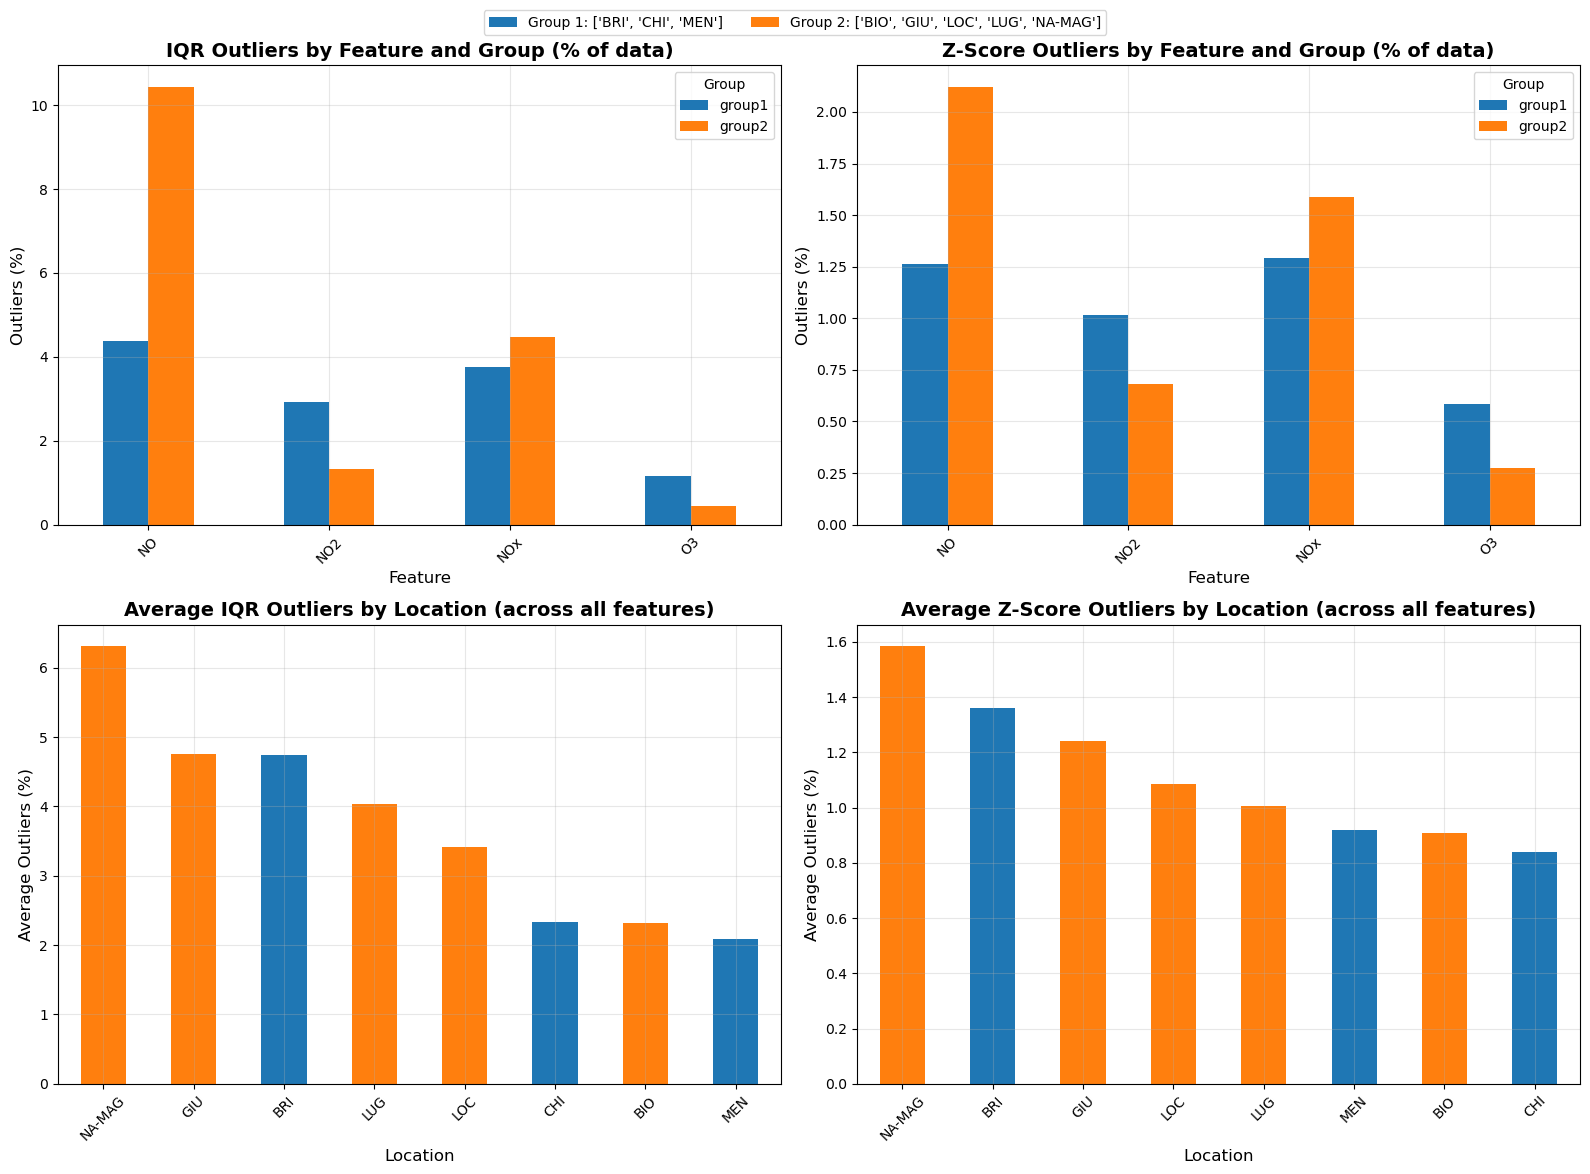

KEY FINDINGS:
1. Locations with most outliers (IQR): {'NA-MAG': 6.306218224481815, 'GIU': 4.751662104028157, 'BRI': 4.741885021509582}
2. Locations with most outliers (Z-score): {'NA-MAG': 1.5838873680093861, 'BRI': 1.3590144700821276, 'GIU': 1.24168947985921}
3. Features with most outliers:
   NO: 8.15%
   NO2: 1.93%
   NOx: 4.20%
   O3: 0.71%
   PM10_lag182: nan%
   PM10_lag30: nan%
   PM10_lag365: nan%
   PM10_lag67: nan%
   PM10_lag7: nan%


In [37]:
# Visualize outlier percentages by feature and group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# IQR outliers by feature and group
ax1 = axes[0, 0]
pivot_iqr = outlier_df.pivot_table(
    values='pct_outliers_iqr', 
    index='feature', 
    columns='group', 
    aggfunc='mean'
)
pivot_iqr.plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('IQR Outliers by Feature and Group (% of data)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Outliers (%)', fontsize=12)
ax1.set_xlabel('Feature', fontsize=12)
ax1.legend(title='Group', fontsize=10)
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Z-score outliers by feature and group
ax2 = axes[0, 1]
pivot_zscore = outlier_df.pivot_table(
    values='pct_outliers_zscore', 
    index='feature', 
    columns='group', 
    aggfunc='mean'
)
pivot_zscore.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Z-Score Outliers by Feature and Group (% of data)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Outliers (%)', fontsize=12)
ax2.set_xlabel('Feature', fontsize=12)
ax2.legend(title='Group', fontsize=10)
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# IQR outliers by location
ax3 = axes[1, 0]
outlier_by_loc_iqr = outlier_df.groupby('location')['pct_outliers_iqr'].mean().sort_values(ascending=False)
colors_loc = ['#1f77b4' if loc in location_groups['group1'] else '#ff7f0e' 
              for loc in outlier_by_loc_iqr.index]
outlier_by_loc_iqr.plot(kind='bar', ax=ax3, color=colors_loc)
ax3.set_title('Average IQR Outliers by Location (across all features)', 
              fontsize=14, fontweight='bold')
ax3.set_ylabel('Average Outliers (%)', fontsize=12)
ax3.set_xlabel('Location', fontsize=12)
ax3.grid(alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Z-score outliers by location
ax4 = axes[1, 1]
outlier_by_loc_zscore = outlier_df.groupby('location')['pct_outliers_zscore'].mean().sort_values(ascending=False)
colors_loc = ['#1f77b4' if loc in location_groups['group1'] else '#ff7f0e' 
              for loc in outlier_by_loc_zscore.index]
outlier_by_loc_zscore.plot(kind='bar', ax=ax4, color=colors_loc)
ax4.set_title('Average Z-Score Outliers by Location (across all features)', 
              fontsize=14, fontweight='bold')
ax4.set_ylabel('Average Outliers (%)', fontsize=12)
ax4.set_xlabel('Location', fontsize=12)
ax4.grid(alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Add legend for group colors
legend_elements = [
    Patch(facecolor='#1f77b4', label=f"Group 1: {location_groups['group1']}"),
    Patch(facecolor='#ff7f0e', label=f"Group 2: {location_groups['group2']}")
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=2, fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("KEY FINDINGS:")
print(f"1. Locations with most outliers (IQR): {outlier_by_loc_iqr.head(3).to_dict()}")
print(f"2. Locations with most outliers (Z-score): {outlier_by_loc_zscore.head(3).to_dict()}")
print(f"3. Features with most outliers:")
for feat in sorted(common_features):
    feat_outliers = outlier_df[outlier_df['feature'] == feat]['pct_outliers_iqr'].mean()
    print(f"   {feat}: {feat_outliers:.2f}%")

**Interpretation – outlier analysis:** NO shows the highest outlier rates (IQR and Z-score), especially in group2 stations (GIU, LOC, LUG, NA-MAG), while O3 is least affected. NA-MAG and GIU are the most outlier-prone locations. Consider winsorizing NO (and possibly NOx) per group or using robust-scaled inputs for models sensitive to extremes.

In [38]:
# Define columns to KEEP: only common features as daily_mean (NO FORECASTS, NO individual hourly m0-m23)
cols_to_keep = [make_daily_mean_col(loc, feat) for feat in common_features for loc in locations 
                if make_daily_mean_col(loc, feat) in X_train_imputed.columns]

# Drop everything else (forecasts, lags, non-common features, hourly measurements)
X_train_imputed = X_train_imputed[cols_to_keep]

# Display kept features
print(f"\nKept features: {sorted(common_features)}")
print(f"Locations: {locations}")
print(f"Total features columns: {len(cols_to_keep)} = {len(common_features)} features × {len(locations)} locations")
print(f"\n✓ Using daily mean aggregations instead of individual hourly measurements")


Kept features: ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag182', 'PM10_lag30', 'PM10_lag365', 'PM10_lag67', 'PM10_lag7']
Locations: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
Total features columns: 72 = 9 features × 8 locations

✓ Using daily mean aggregations instead of individual hourly measurements


To do:   This cell is optional - for recalculating the lags after imputation, which might not be necessary since we want clean features for the moment and we will add lags later.

In [39]:
# # Step 2: Drop existing lagged features and recalculate from imputed m0 values
# print("="*80)
# print("STEP 2: DROPPING OLD LAGS AND RECALCULATING FROM IMPUTED m0 VALUES")
# print("="*80)

# # Collect all new lag columns in a list, then concat once
# new_lag_columns = {}

# for feat in sorted(common_features):
#     print(f"\nProcessing {feat}...")
    
#     for loc in locations:
#         # Get the m0 column for this location/feature
#         m0_col = f"{loc}__{feat}__m0"
        
#         if m0_col not in X_train_imputed.columns:
#             continue
        
#         # Drop old lagged columns (m1 to m20)
#         old_lag_cols = [f"{loc}__{feat}__m{lag}" for lag in range(1, 21) 
#                        if f"{loc}__{feat}__m{lag}" in X_train_imputed.columns]
        
#         if old_lag_cols:
#             X_train_imputed.drop(columns=old_lag_cols, inplace=True)
#             print(f"  {loc}: Dropped {len(old_lag_cols)} old lag columns")
        
#         # Get imputed m0 values
#         m0_values = X_train_imputed[m0_col]
        
#         # Create all lags for this feature/location at once
#         for lag in range(1, 21):
#             lag_col = f"{loc}__{feat}__m{lag}"
#             new_lag_columns[lag_col] = m0_values.shift(lag)
                
#         print(f"  {loc}: Recalculated m1-m20 from imputed m0")

# # Concatenate all new lag columns at once (much faster!)
# print("\nAdding all recalculated lag columns to dataframe...")
# X_train_imputed = pd.concat([X_train_imputed, pd.DataFrame(new_lag_columns, index=X_train_imputed.index)], axis=1)

# print(f"\nTotal missing in features after step 2: {X_train_imputed.isnull().sum().sum()}")
# print("(Remaining NaNs are expected at the beginning due to lag creation)")

In [40]:
# STEP 3: Impute targets using spatial grouping - same strategy as features
print("STEP 3: IMPUTING TARGETS WITH SPATIAL GROUPING - DAILY MEAN APPROACH")

# Use the original targets
y_train_imputed = y_train.copy()

# Count missing values before imputation
missing_before = y_train_imputed.isnull().sum().sum()
print(f"\nTotal missing values in targets before imputation: {missing_before}")

if missing_before > 0:
    # Impute for each day ahead (d0 to d5)
    for day in days_ahead:
        print(f"\nProcessing day ahead: {day}")
        
        for group_name, group_locs in location_groups.items():
            # Get target columns for this day and group
            group_target_cols = [make_target_col(loc, TARGET_SIGNAL, day) for loc in group_locs 
                                if make_target_col(loc, TARGET_SIGNAL, day) in y_train_imputed.columns]
            
            if not group_target_cols:
                continue
            
            # Count missing values before imputation for this group
            missing_group_before = y_train_imputed[group_target_cols].isnull().sum().sum()
            
            if missing_group_before == 0:
                print(f"  {group_name}: No missing values")
                continue
            
            print(f"  {group_name}: {missing_group_before} missing values to impute")
            
            # For each target column, impute using daily mean across stations in the group
            for col in group_target_cols:
                col_data = y_train_imputed[col].copy()
                
                # Find rows where this column is missing
                missing_mask = col_data.isnull()
                
                if not missing_mask.any():
                    continue
                
                # For each missing value, calculate mean of other stations on that day
                for idx in col_data[missing_mask].index:
                    # Get values from all other stations in the group on this day
                    other_cols = [c for c in group_target_cols if c != col]
                    day_values = y_train_imputed.loc[idx, other_cols]
                    
                    # Calculate mean (ignoring NaNs)
                    if day_values.notna().any():
                        col_data.loc[idx] = day_values.mean()
                
                # Update the column
                y_train_imputed[col] = col_data
            
            
            missing_group_after = y_train_imputed[group_target_cols].isnull().sum().sum()
            print(f"  {group_name}: {missing_group_after} missing values remaining")
        
        # Also handle the average columns (AVG__YPM10-dailymean__dX)
        avg_col = make_target_col(AVG_LOCATION, TARGET_SIGNAL, day)
        if avg_col in y_train_imputed.columns:
            # Recalculate average from imputed individual locations
            location_cols = [make_target_col(loc, TARGET_SIGNAL, day) for loc in locations 
                           if make_target_col(loc, TARGET_SIGNAL, day) in y_train_imputed.columns]
            y_train_imputed[avg_col] = y_train_imputed[location_cols].mean(axis=1)
            print(f"  Recalculated: {avg_col}")

print("TARGET IMPUTATION COMPLETE:")
print(f"Total missing values in targets after imputation: {y_train_imputed.isnull().sum().sum()}")

print(f"\nShape: {y_train_imputed.shape}")
print("\n✓ Data preprocessing complete!")
print(f"Features shape: {X_train_imputed.shape}")
print(f"Targets shape: {y_train_imputed.shape}")

# Check consecutive missing values AFTER imputation
print("VERIFYING IMPUTATION SUCCESS - CHECKING IMPUTED DATA:")

# Filter out PM10_lag1 from common_features for this check (it doesn't follow the location pattern)
features_for_check = [feat for feat in common_features if feat != f'{PM10_SIGNAL}_lag1']
consecutive_nans_measurements = X_train_imputed[[make_daily_mean_col(loc, feat) for feat in features_for_check for loc in locations]].apply(max_consecutive_nans)
consecutive_nans_targets = y_train_imputed.apply(max_consecutive_nans)

print("\nTop 10 IMPUTED measurement features with highest consecutive missing values:")
print(consecutive_nans_measurements.sort_values(ascending=False).head(10))
print(f"\nTotal missing in imputed features: {X_train_imputed.isnull().sum().sum()}")

print("\nTop 10 target features with highest consecutive missing values:")
print(consecutive_nans_targets.sort_values(ascending=False).head(10))
print(f"\nTotal missing in targets: {y_train_imputed.isnull().sum().sum()}")

STEP 3: IMPUTING TARGETS WITH SPATIAL GROUPING - DAILY MEAN APPROACH

Total missing values in targets before imputation: 192

Processing day ahead: d0
  group1: 11 missing values to impute
  group1: 0 missing values remaining
  group2: 21 missing values to impute
  group2: 0 missing values remaining
  Recalculated: AVG__YPM10-dailymean__d0

Processing day ahead: d1
  group1: 11 missing values to impute
  group1: 0 missing values remaining
  group2: 21 missing values to impute
  group2: 0 missing values remaining
  Recalculated: AVG__YPM10-dailymean__d1

Processing day ahead: d2
  group1: 11 missing values to impute
  group1: 0 missing values remaining
  group2: 21 missing values to impute
  group2: 0 missing values remaining
  Recalculated: AVG__YPM10-dailymean__d2

Processing day ahead: d3
  group1: 11 missing values to impute
  group1: 0 missing values remaining
  group2: 21 missing values to impute
  group2: 0 missing values remaining
  Recalculated: AVG__YPM10-dailymean__d3

Proces

## 5. Temporal Pattern Analysis

### 5.1 PM10 Calendar Heatmap by Location Groups

Visualize monthly and yearly PM10 patterns for each location group to identify seasonal trends and differences between groups.

PM10 CALENDAR HEATMAP - MONTHLY & YEARLY PATTERNS:


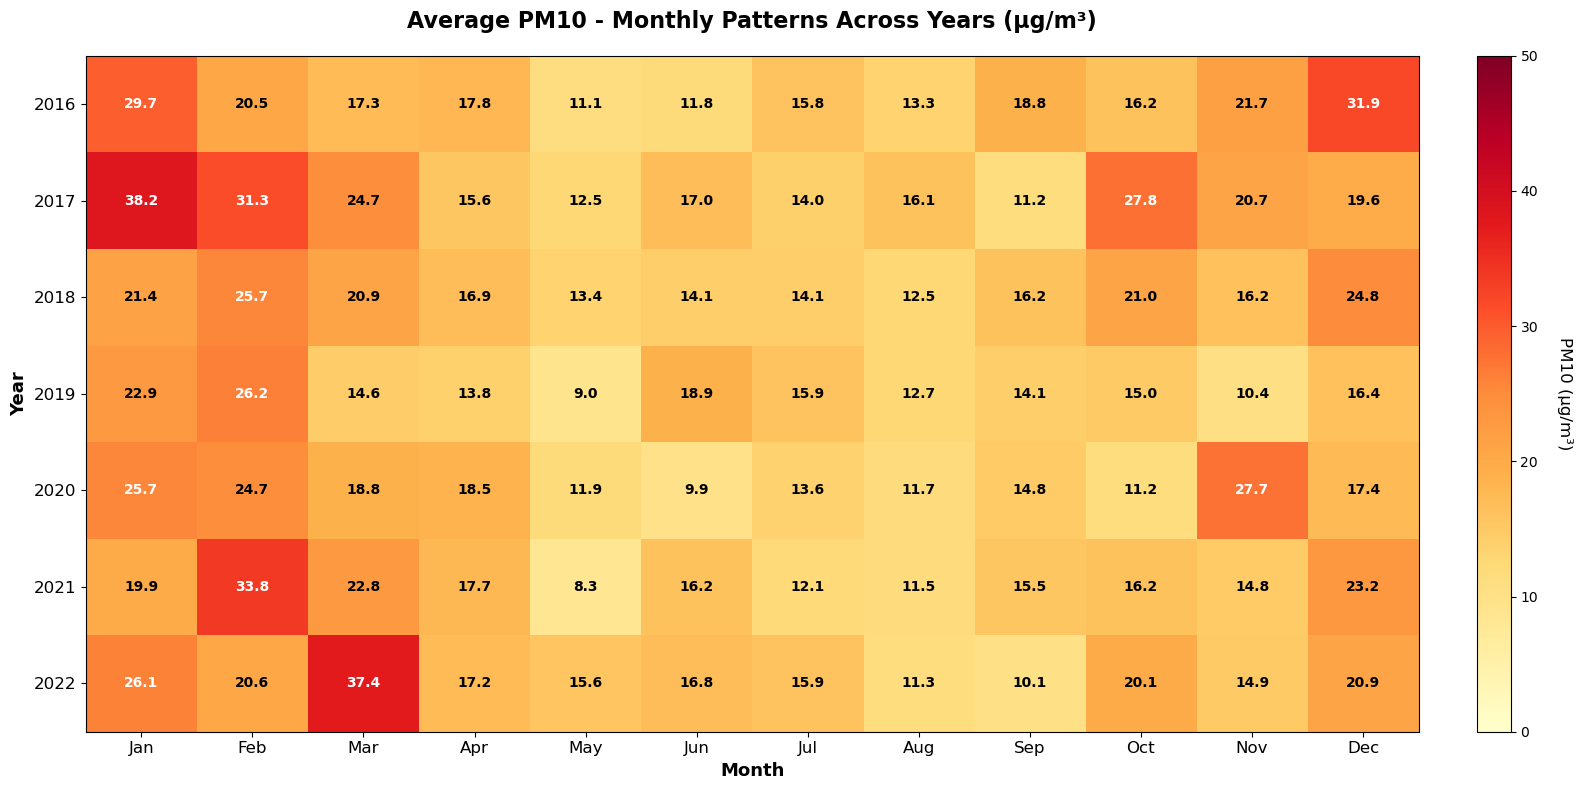


Summary Statistics:
  Overall mean PM10: 18.14 μg/m³
  Overall std PM10: 11.63 μg/m³
  Highest monthly average: 38.16 μg/m³
  Lowest monthly average: 8.26 μg/m³


In [41]:
# Create monthly/yearly PM10 heatmap for AVG target
print("PM10 CALENDAR HEATMAP - MONTHLY & YEARLY PATTERNS:")

# Get AVG PM10 d0 column (current day PM10 target)
avg_pm10_col = make_target_col(AVG_LOCATION, TARGET_SIGNAL, 'd0')

if avg_pm10_col not in y_train_imputed.columns:
    print(f"Error: {avg_pm10_col} not found in y_train_imputed")
else:
    # Create DataFrame with PM10 and temporal columns
    pm10_data = pd.DataFrame({
        'pm10': y_train_imputed[avg_pm10_col],
        'year': y_train_imputed.index.year,
        'month': y_train_imputed.index.month
    })
    
    # Aggregate by year-month
    monthly_avg = pm10_data.groupby(['year', 'month'])['pm10'].mean().reset_index()
    
    # Pivot to create heatmap structure (years as rows, months as columns)
    heatmap_data = monthly_avg.pivot(index='year', columns='month', values='pm10')
    
    # Create the heatmap visualization
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    im = ax.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=50)
    ax.set_xticks(np.arange(len(month_labels)))
    ax.set_yticks(np.arange(len(heatmap_data.index)))
    ax.set_xticklabels(month_labels, fontsize=12)
    ax.set_yticklabels(heatmap_data.index, fontsize=12)
    ax.set_title('Average PM10 - Monthly Patterns Across Years (μg/m³)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Month', fontsize=13, fontweight='bold')
    ax.set_ylabel('Year', fontsize=13, fontweight='bold')
    
    # Add text annotations
    for i in range(len(heatmap_data.index)):
        for j in range(len(month_labels)):
            if j < heatmap_data.shape[1] and not np.isnan(heatmap_data.values[i, j]):
                text_color = 'white' if heatmap_data.values[i, j] > 25 else 'black'
                text = ax.text(j, i, f'{heatmap_data.values[i, j]:.1f}',
                              ha="center", va="center", color=text_color, 
                              fontsize=10, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('PM10 (μg/m³)', rotation=270, labelpad=25, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"  Overall mean PM10: {pm10_data['pm10'].mean():.2f} μg/m³")
    print(f"  Overall std PM10: {pm10_data['pm10'].std():.2f} μg/m³")
    print(f"  Highest monthly average: {heatmap_data.max().max():.2f} μg/m³")
    print(f"  Lowest monthly average: {heatmap_data.min().min():.2f} μg/m³")

**Interpretation – PM10 seasonality:** Winter peaks dominate (notably Jan–Feb and occasional Nov) with troughs in late spring/summer (May–Aug). Variability across years is modest except for elevated 2017 and 2022 winters. Models should capture strong annual cycles and winter-specific effects.

### 5.2 Average Correlation Heatmap Across All Stations

This heatmap shows the average correlation between common features across all stations. It helps identify which features are generally correlated regardless of location.

AVERAGE FEATURE CORRELATION ACROSS ALL STATIONS
Added correlation matrix for BIO
Added correlation matrix for BRI
Added correlation matrix for CHI
Added correlation matrix for GIU
Added correlation matrix for LOC
Added correlation matrix for LUG
Added correlation matrix for MEN
Added correlation matrix for NA-MAG

Averaged across 8 stations
Matrix size: 9 features × 9 features


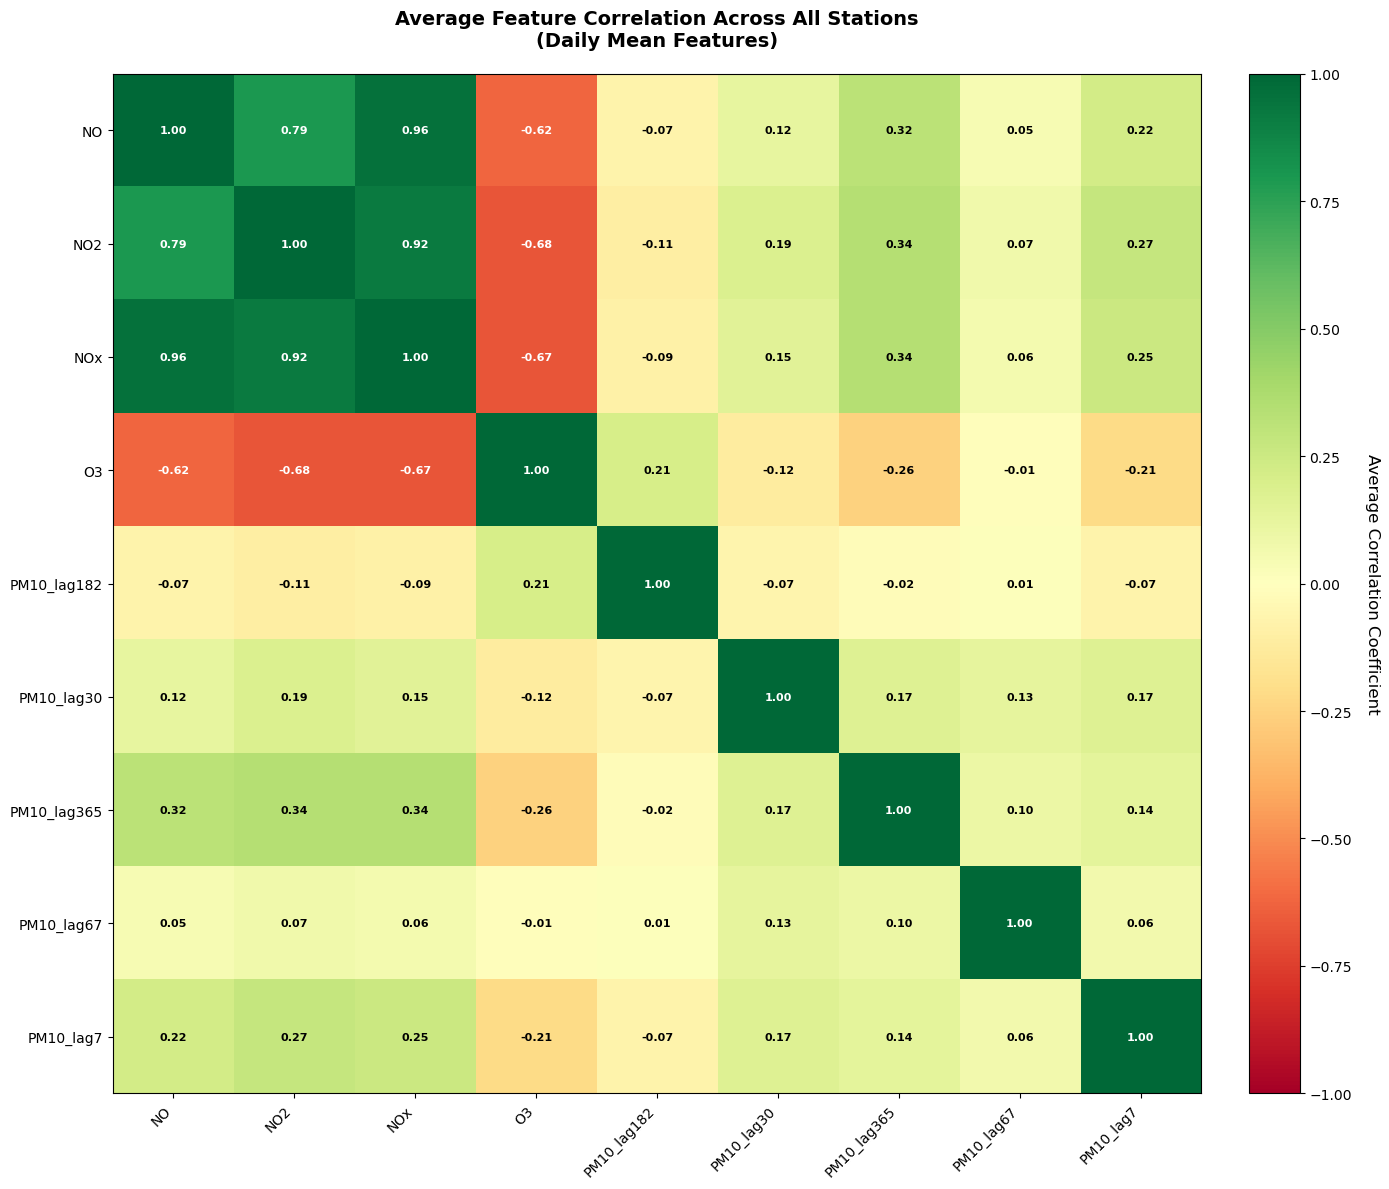

CORRELATION SUMMARY

Highly correlated feature pairs (|r| > 0.7):
  NO <-> NOx: 0.961
  NO2 <-> NOx: 0.920
  NO <-> NO2: 0.791

Total pairs with |r| > 0.7: 3


In [42]:
print("AVERAGE FEATURE CORRELATION ACROSS ALL STATIONS")

# Collect correlation matrices from each station
correlation_matrices = []

for loc in locations:
    # Get daily_mean columns for this location's common features
    loc_cols = [make_daily_mean_col(loc, feat) for feat in sorted(common_features) 
                if make_daily_mean_col(loc, feat) in X_train_imputed.columns]
    
    if not loc_cols:
        continue
    
    # Calculate correlation matrix for this station
    station_corr = X_train_imputed[loc_cols].corr()
    
    # Rename columns/index to just feature names for averaging
    station_corr.columns = [extract_signal(col) for col in station_corr.columns]
    station_corr.index = [extract_signal(col) for col in station_corr.index]
    
    correlation_matrices.append(station_corr)
    print(f"Added correlation matrix for {loc}")

# Calculate average correlation matrix across all stations
avg_correlation = sum(correlation_matrices) / len(correlation_matrices)

print(f"\nAveraged across {len(correlation_matrices)} stations")
print(f"Matrix size: {avg_correlation.shape[0]} features × {avg_correlation.shape[1]} features")

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(avg_correlation, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
features_sorted = sorted(common_features)
ax.set_xticks(np.arange(len(features_sorted)))
ax.set_yticks(np.arange(len(features_sorted)))
ax.set_xticklabels(features_sorted, fontsize=10, rotation=45, ha='right')
ax.set_yticklabels(features_sorted, fontsize=10)

# Add text annotations
for i in range(len(features_sorted)):
    for j in range(len(features_sorted)):
        text_color = "white" if abs(avg_correlation.iloc[i, j]) > 0.5 else "black"
        text = ax.text(j, i, f'{avg_correlation.iloc[i, j]:.2f}',
                      ha="center", va="center", color=text_color, 
                      fontsize=8, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Average Correlation Coefficient', rotation=270, labelpad=20, fontsize=12)

# Title and layout
ax.set_title('Average Feature Correlation Across All Stations\n(Daily Mean Features)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print summary statistics
print("CORRELATION SUMMARY")

# Find highly correlated pairs (excluding diagonal)
high_corr_pairs = []
for i in range(len(features_sorted)):
    for j in range(i+1, len(features_sorted)):
        corr_val = avg_correlation.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((features_sorted[i], features_sorted[j], corr_val))

high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"\nHighly correlated feature pairs (|r| > 0.7):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

print(f"\nTotal pairs with |r| > 0.7: {len(high_corr_pairs)}")

### 5.3 Remove Multicollinear Features

Since NOx = NO + NO2, it's redundant and causes multicollinearity (r > 0.85 with both). We'll remove it from our feature set.

In [43]:
# NOx is the sum of NO + NO2, so it's redundant
# Remove it from common_features set
nox_signal = 'NOx'
if nox_signal in common_features:
    common_features.remove(nox_signal)
    print(f"✓ Removed {nox_signal} from common_features")
else:
    print(f"{nox_signal} not found in common_features")

#also drop NO2
nox2_signal = 'NO2'
if nox2_signal in common_features:
    common_features.remove(nox2_signal)
    print(f"✓ Removed {nox2_signal} from common_features")
else:
    print(f"{nox2_signal} not found in common_features")

# Remove NOx columns from X_train_imputed
nox_cols = [col for col in X_train_imputed.columns if f'{COL_SEPARATOR}{nox_signal}{COL_SEPARATOR}' in col]
if nox_cols:
    X_train_imputed = X_train_imputed.drop(columns=nox_cols)
    print(f"✓ Dropped {len(nox_cols)} {nox_signal} columns from X_train_imputed")
else:
    print(f"No {nox_signal} columns found in X_train_imputed")

print(f"\nUpdated common features ({len(common_features)}): {sorted(common_features)}")
print(f"X_train_imputed shape: {X_train_imputed.shape}")

✓ Removed NOx from common_features
✓ Removed NO2 from common_features
✓ Dropped 8 NOx columns from X_train_imputed

Updated common features (7): ['NO', 'O3', 'PM10_lag182', 'PM10_lag30', 'PM10_lag365', 'PM10_lag67', 'PM10_lag7']
X_train_imputed shape: (2557, 64)


**Interpretation – feature correlation pruning:** NO, NO2, and NOx are highly collinear (|r|>0.9). Removing NOx and NO2 reduces redundancy, leaving 7 features (NO, O3, and PM10 lags) and shrinks the matrix to 64 columns. This should stabilize models while retaining key signal diversity.

### 5.4 Average Autocorrelation Analysis Across Stations

This section analyzes the autocorrelation of each common feature by averaging across all stations and displaying confidence bands.

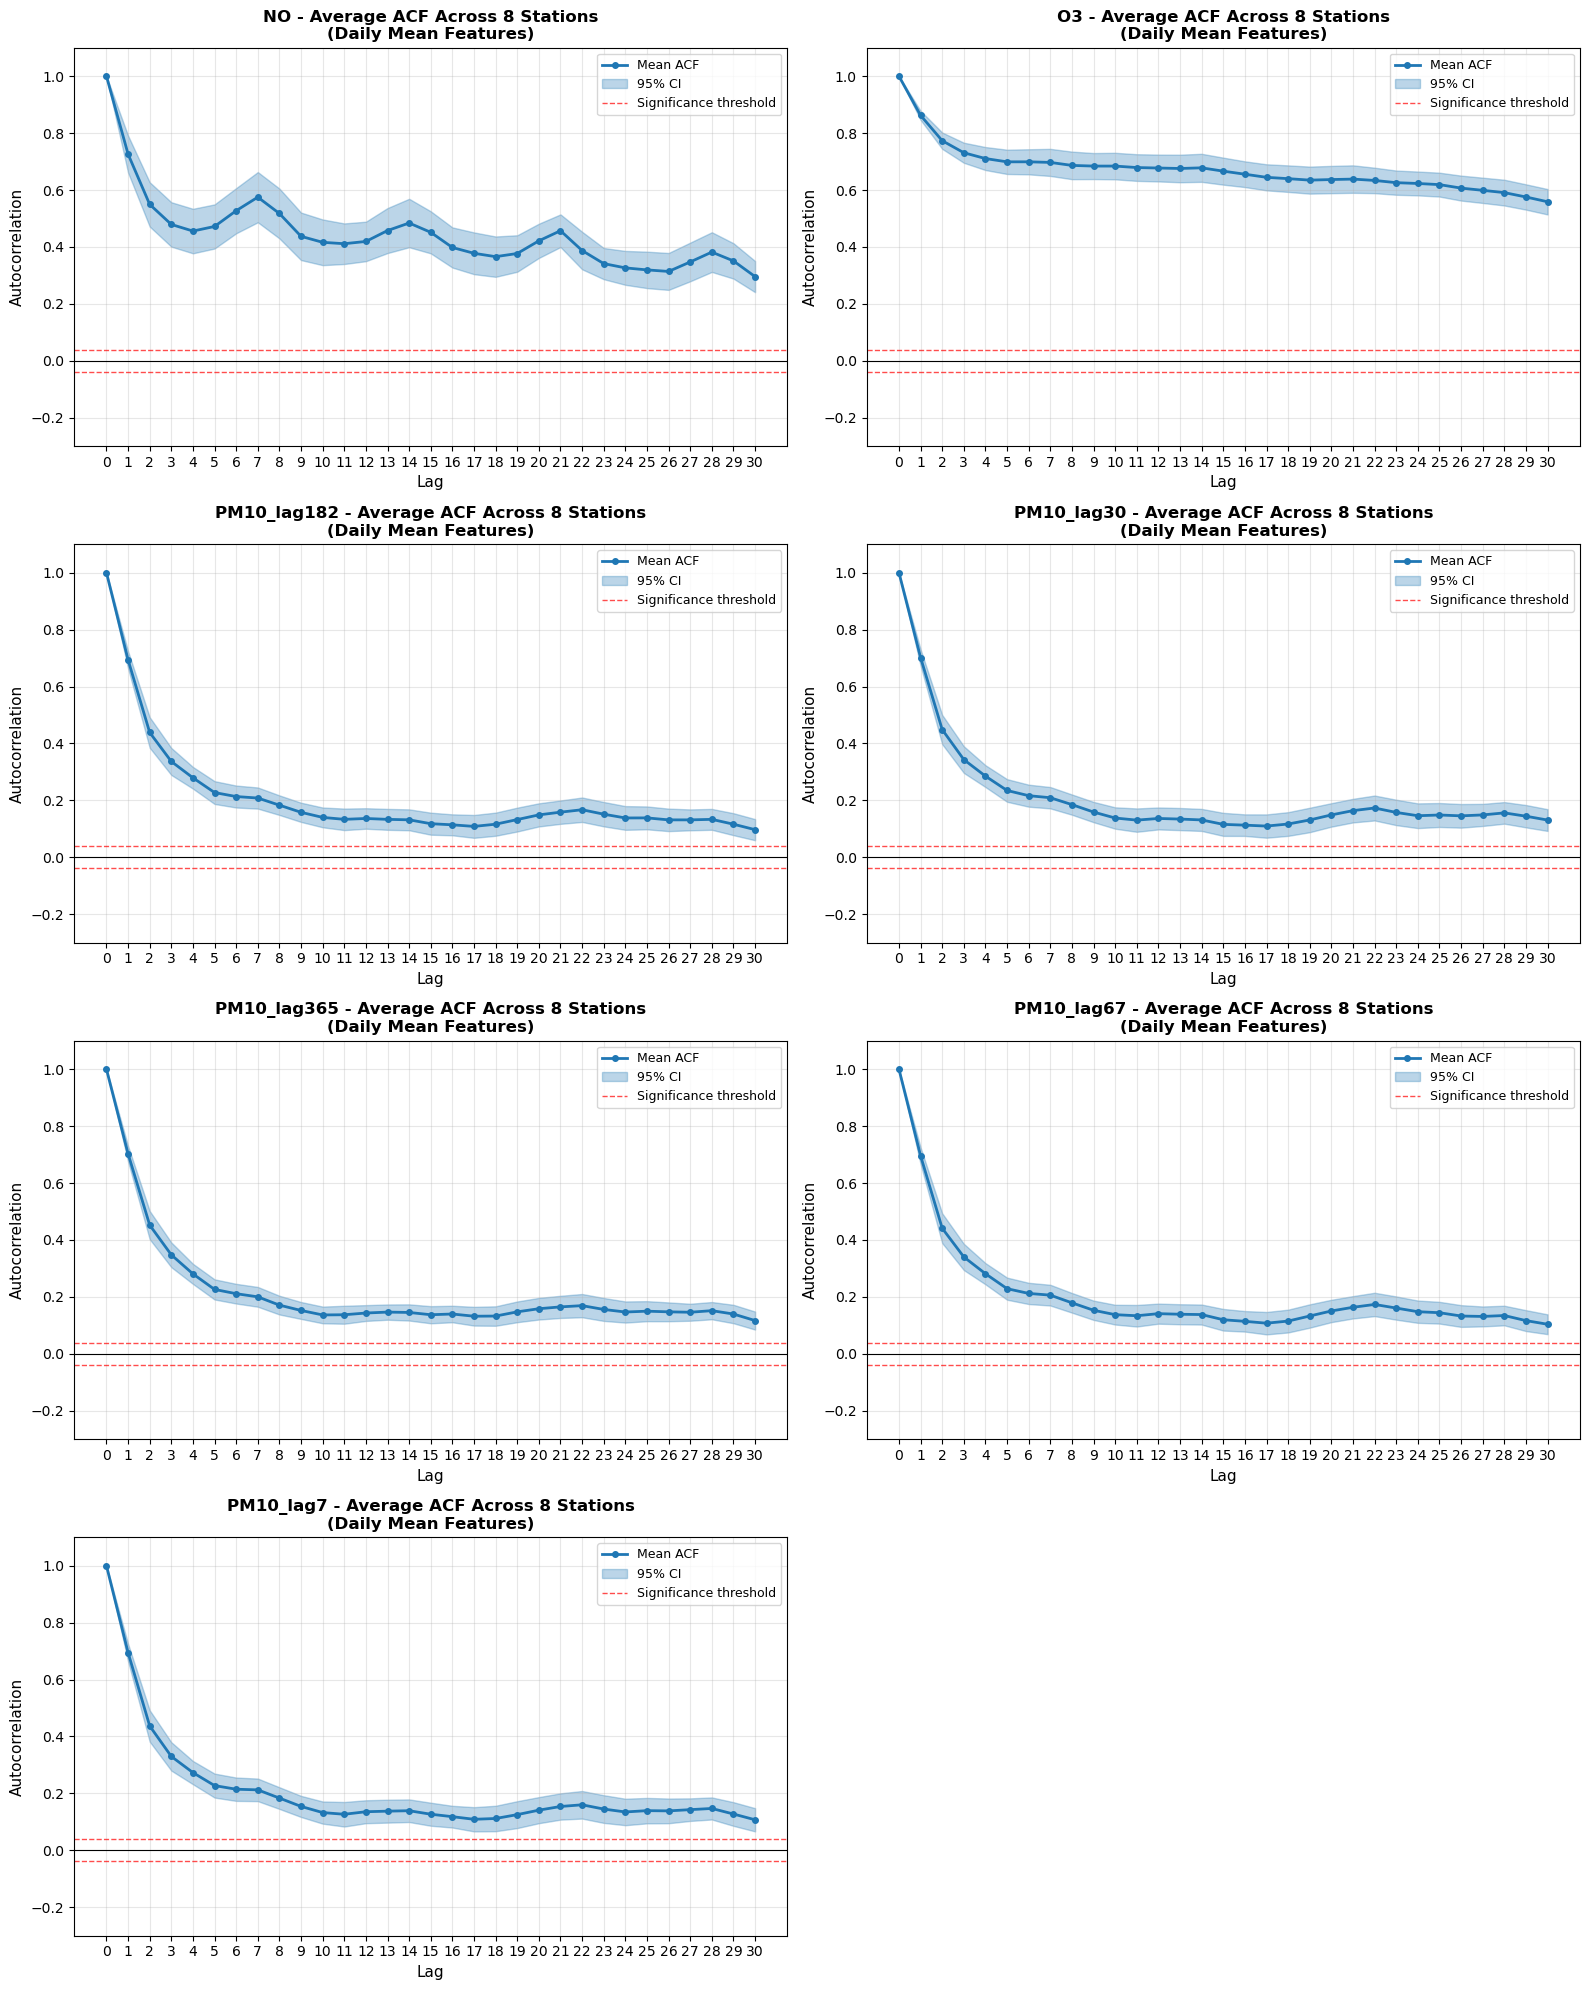

AUTOCORRELATION ANALYSIS SUMMARY (Daily Mean Features)

NO:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.726 at lag 1

O3:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.862 at lag 1

PM10_lag182:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.694 at lag 1

PM10_lag30:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.702 at lag 1

PM10_lag365:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.703 at lag 1

PM10_lag67:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.696 at lag 1

PM10_lag7:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.695 at lag 1


In [44]:
def plot_average_autocorrelation(data, features, locations, max_lags=40):
    
    # Calculate grid size
    n_features = len(features)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, feat in enumerate(sorted(features)):
        ax = axes[idx]
        
        # Collect ACF values for this feature across all stations
        acf_values = []
        
        for loc in locations:
            col_name = make_daily_mean_col(loc, feat)
            
            if col_name not in data.columns:
                continue
            
            # Get the time series and drop NaN values
            series = data[col_name].dropna()
            
            if len(series) < max_lags + 1:
                continue
            
            # Compute ACF with specified number of lags
            acf_result = acf(series, nlags=max_lags, fft=True)
            acf_values.append(acf_result)
        
        if not acf_values:
            ax.set_visible(False)
            continue
        
        # Convert to numpy array for easier computation
        acf_array = np.array(acf_values)  # Shape: (n_stations, n_lags+1)
        
        # Calculate mean and standard error across stations
        mean_acf = np.mean(acf_array, axis=0)
        std_acf = np.std(acf_array, axis=0)
        se_acf = std_acf / np.sqrt(len(acf_values))  # Standard error
        
        # 95% confidence interval
        ci_95 = 1.96 * se_acf
        
        # Lags
        lags = np.arange(len(mean_acf))
        
        # Plot mean ACF
        ax.plot(lags, mean_acf, 'o-', color='#1f77b4', linewidth=2, 
                markersize=4, label='Mean ACF', zorder=3)
        
        # Plot confidence band
        ax.fill_between(lags, mean_acf - ci_95, mean_acf + ci_95, 
                        alpha=0.3, color='#1f77b4', label='95% CI')
        
        # Add significance threshold (1.96/sqrt(n))
        first_col = make_daily_mean_col(locations[0], feat)
        n_obs = len(data[first_col].dropna())
        significance_level = 1.96 / np.sqrt(n_obs)
        ax.axhline(y=significance_level, color='red', linestyle='--', 
                   linewidth=1, alpha=0.7, label='Significance threshold')
        ax.axhline(y=-significance_level, color='red', linestyle='--', 
                   linewidth=1, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # Formatting
        ax.set_xlabel('Lag', fontsize=11)
        ax.set_ylabel('Autocorrelation', fontsize=11)
        ax.set_title(f'{feat} - Average ACF Across {len(acf_values)} Stations\n(Daily Mean Features)', 
                     fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(fontsize=9, loc='upper right')
        ax.set_ylim(-0.3, 1.1)
        
        # Increase x-axis granulation with more frequent ticks
        ax.set_xticks(np.arange(0, len(lags), 1))  # Tick every lag
        ax.set_xticklabels(np.arange(0, len(lags), 1))
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("AUTOCORRELATION ANALYSIS SUMMARY (Daily Mean Features)")
    
    # Analyze significant lags for each feature
    for feat in sorted(features):
        acf_values = []
        
        for loc in locations:
            col_name = make_daily_mean_col(loc, feat)
            if col_name in data.columns:
                series = data[col_name].dropna()
                if len(series) >= max_lags + 1:
                    acf_result = acf(series, nlags=max_lags, fft=True)
                    acf_values.append(acf_result)
        
        if not acf_values:
            continue
        
        acf_array = np.array(acf_values)
        mean_acf = np.mean(acf_array, axis=0)
        
        # Find significant lags (beyond lag 0)
        first_col = make_daily_mean_col(locations[0], feat)
        n_obs = len(data[first_col].dropna())
        significance_level = 1.96 / np.sqrt(n_obs)
        significant_lags = np.where(np.abs(mean_acf[1:]) > significance_level)[0] + 1
        
        if len(significant_lags) > 0:
            print(f"\n{feat}:")
            print(f"  Significant lags: {significant_lags[:10].tolist()}")
            print(f"  Total significant lags: {len(significant_lags)}")
            print(f"  Max ACF (lag>0): {np.max(np.abs(mean_acf[1:])):.3f} at lag {np.argmax(np.abs(mean_acf[1:])) + 1}")
    

# Call the function with our data
plot_average_autocorrelation(X_train_imputed, common_features, locations, max_lags=30)

**Interpretation – average ACF:** NO/O3 show modest persistence with a slow decay and minor oscillations; PM10 lag features drop near zero after the first few lags, indicating limited long memory beyond short horizons. No strong periodic spikes beyond a mild weekly bump, so short-order models should suffice.

### 5.5 Stationarity Testing

For each feature between locations the dataset shows moderate correlation up until the third/fourth lag, after which the correlation drops significantly. There are clearly weekly seasonality patterns in the data.

In [45]:
# check stationarity using ADF test for all common features averaged across locations
print("STATIONARITY ANALYSIS USING ADF TEST (Daily Mean Features)\n")
for feat in sorted(common_features):
    adf_results = []
    
    for loc in locations:
        col_name = make_daily_mean_col(loc, feat)
        
        if col_name not in X_train_imputed.columns:
            continue
        
        series = X_train_imputed[col_name].dropna()
        
        if len(series) < 30:  # Require at least 30 data points
            continue
        
        adf_result = adfuller(series)
        adf_results.append(adf_result)
    
    if not adf_results:
        print(f"{feat}: No valid stations for ADF test")
        continue
    
    # Aggregate results
    p_values = [result[1] for result in adf_results]
    avg_p_value = np.mean(p_values)
    
    print(f"{feat}: Average ADF p-value across {len(adf_results)} stations = {avg_p_value:.4f} ", end='')
    if avg_p_value < 0.05:
        print("(Stationary)")
    else:
        print("(Non-Stationary)")

STATIONARITY ANALYSIS USING ADF TEST (Daily Mean Features)

NO: Average ADF p-value across 8 stations = 0.0001 (Stationary)
O3: Average ADF p-value across 8 stations = 0.0221 (Stationary)
PM10_lag182: Average ADF p-value across 8 stations = 0.0000 (Stationary)
PM10_lag30: Average ADF p-value across 8 stations = 0.0000 (Stationary)
PM10_lag365: Average ADF p-value across 8 stations = 0.0000 (Stationary)
PM10_lag67: Average ADF p-value across 8 stations = 0.0000 (Stationary)
PM10_lag7: Average ADF p-value across 8 stations = 0.0000 (Stationary)


**Interpretation – stationarity:** All common features have ADF p-values < 0.05 across stations, so they are stationary as-is; no differencing required before modeling.

In [46]:
X_train_imputed.columns

Index(['BIO__PM10_lag182__daily_mean', 'BRI__PM10_lag182__daily_mean',
       'CHI__PM10_lag182__daily_mean', 'GIU__PM10_lag182__daily_mean',
       'LOC__PM10_lag182__daily_mean', 'LUG__PM10_lag182__daily_mean',
       'MEN__PM10_lag182__daily_mean', 'NA-MAG__PM10_lag182__daily_mean',
       'BIO__PM10_lag30__daily_mean', 'BRI__PM10_lag30__daily_mean',
       'CHI__PM10_lag30__daily_mean', 'GIU__PM10_lag30__daily_mean',
       'LOC__PM10_lag30__daily_mean', 'LUG__PM10_lag30__daily_mean',
       'MEN__PM10_lag30__daily_mean', 'NA-MAG__PM10_lag30__daily_mean',
       'BIO__NO2__daily_mean', 'BRI__NO2__daily_mean', 'CHI__NO2__daily_mean',
       'GIU__NO2__daily_mean', 'LOC__NO2__daily_mean', 'LUG__NO2__daily_mean',
       'MEN__NO2__daily_mean', 'NA-MAG__NO2__daily_mean',
       'BIO__PM10_lag365__daily_mean', 'BRI__PM10_lag365__daily_mean',
       'CHI__PM10_lag365__daily_mean', 'GIU__PM10_lag365__daily_mean',
       'LOC__PM10_lag365__daily_mean', 'LUG__PM10_lag365__daily_mean',
     

## 6. Modeling Framework

### 6.1 Time Series Cross-Validation Strategy

We implement an **expanding window** approach for proper temporal forecasting evaluation:
- Fold 1: Train on first 120 days → Validate on next 60 days
- Fold 2: Train on first 180 days → Validate on next 60 days  
- Fold 3: Train on first 240 days → Validate on next 60 days
- And so on...

This gives models (especially LightGBM) increasingly more data to learn from while ensuring they never see future data.

In [47]:
# Time Series Cross-Validation Parameters (EXPANDING WINDOW)
val_size = 60  # Validation period: 60 days (2 months)
min_train_size = 120  # Minimum training size: 120 days (4 months)
step_size = 60  # Move forward 60 days each fold

n_total_days = len(X_train_imputed)

print("TIME SERIES CROSS-VALIDATION SETUP (EXPANDING WINDOW)")
print(f"Total available data: {n_total_days} days")
print(f"Validation size: {val_size} days")
print(f"Minimum training size: {min_train_size} days")
print(f"Step size: {step_size} days")
print(f"Pattern: Train(growing) -> Val({val_size}d) -> Train(growing) -> Val({val_size}d) ...")

# Create expanding window cross-validation splits
cv_splits = []
fold_num = 1
train_end = min_train_size

while train_end + val_size <= n_total_days:
    val_start = train_end
    val_end = val_start + val_size
    
    cv_splits.append({
        'fold': fold_num,
        'train_start': 0,  # Always start from beginning (expanding window)
        'train_end': train_end,
        'val_start': val_start,
        'val_end': val_end
    })
    
    # Move to next fold
    train_end += step_size
    fold_num += 1

print(f"\nCreated {len(cv_splits)} valid CV splits:")
for split in cv_splits:
    train_days = split['train_end'] - split['train_start']
    train_period = X_train_imputed.index[split['train_start']].strftime('%Y-%m-%d') + ' to ' + \
                   X_train_imputed.index[split['train_end']-1].strftime('%Y-%m-%d')
    val_period = X_train_imputed.index[split['val_start']].strftime('%Y-%m-%d') + ' to ' + \
                 X_train_imputed.index[split['val_end']-1].strftime('%Y-%m-%d')
    print(f"  Fold {split['fold']}: Train [{train_period}] ({train_days}d) -> Val [{val_period}] ({val_size}d)")

TIME SERIES CROSS-VALIDATION SETUP (EXPANDING WINDOW)
Total available data: 2557 days
Validation size: 60 days
Minimum training size: 120 days
Step size: 60 days
Pattern: Train(growing) -> Val(60d) -> Train(growing) -> Val(60d) ...

Created 40 valid CV splits:
  Fold 1: Train [2016-01-01 to 2016-04-29] (120d) -> Val [2016-04-30 to 2016-06-28] (60d)
  Fold 2: Train [2016-01-01 to 2016-06-28] (180d) -> Val [2016-06-29 to 2016-08-27] (60d)
  Fold 3: Train [2016-01-01 to 2016-08-27] (240d) -> Val [2016-08-28 to 2016-10-26] (60d)
  Fold 4: Train [2016-01-01 to 2016-10-26] (300d) -> Val [2016-10-27 to 2016-12-25] (60d)
  Fold 5: Train [2016-01-01 to 2016-12-25] (360d) -> Val [2016-12-26 to 2017-02-23] (60d)
  Fold 6: Train [2016-01-01 to 2017-02-23] (420d) -> Val [2017-02-24 to 2017-04-24] (60d)
  Fold 7: Train [2016-01-01 to 2017-04-24] (480d) -> Val [2017-04-25 to 2017-06-23] (60d)
  Fold 8: Train [2016-01-01 to 2017-06-23] (540d) -> Val [2017-06-24 to 2017-08-22] (60d)
  Fold 9: Train [20

**Interpretation – CV plan:** 40 expanding-window folds with 60-day validations and a 120-day warm-up keep temporal order intact and give frequent checkpoints; model training data grows every step to mirror production deployment.

### 6.2 Base Model Class

In [48]:
class BaseModel(ABC):
    def __init__(self, name):
        self.name = name
        self.is_fitted = False
    
    @abstractmethod
    def fit(self, X, y):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        return {q: self.predict(X) for q in quantiles}
    
    def evaluate(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

### 6.3 Naive Models

In [49]:
class NaiveModel(BaseModel):
    def __init__(self, strategy='last'):
        super().__init__(f'Naive-{strategy}')
        self.strategy = strategy
        self.last_values = None
        self.residuals = None
    
    def fit(self, X, y):
        if self.strategy == 'last':
            self.last_values = y.iloc[-1]
        elif self.strategy == 'seasonal':
            self.last_values = y.iloc[-7:]
        elif self.strategy == 'drift':
            self.last_values = y.iloc[-1]
            self.drift = (y.iloc[-1] - y.iloc[0]) / len(y)
        
        y_pred = self.predict(X)
        self.residuals = y - y_pred
        self.is_fitted = True
        return self
    
    def predict(self, X):
        n = len(X)
        
        if self.strategy == 'last':
            return pd.DataFrame(
                np.repeat([self.last_values.values], n, axis=0),
                index=X.index, columns=self.last_values.index
            )
        elif self.strategy == 'seasonal':
            preds = []
            for i in range(n):
                preds.append(self.last_values.iloc[i % 7].values)
            return pd.DataFrame(preds, index=X.index, columns=self.last_values.columns)
        elif self.strategy == 'drift':
            preds = []
            for i in range(1, n + 1):
                preds.append((self.last_values + i * self.drift).values)
            return pd.DataFrame(preds, index=X.index, columns=self.last_values.index)
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        point_pred = self.predict(X)
        results = {}
        
        for q in quantiles:
            if self.residuals is not None:
                q_values = self.residuals.quantile(q)
                results[q] = point_pred + q_values
            else:
                results[q] = point_pred
        
        return results

### 6.4 SARIMA Models

In [50]:
class SARIMAModel(BaseModel):
    def __init__(self, order=(1,0,1), seasonal_order=(1,0,1,7)):
        super().__init__('SARIMA')
        self.order = order
        self.seasonal_order = seasonal_order
        self.models = {}
    
    def fit(self, X, y):
        for col in y.columns:
            try:
                model = SARIMAX(
                    y[col],
                    order=self.order,
                    seasonal_order=self.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                self.models[col] = model.fit(disp=False, maxiter=100)
            except:
                self.models[col] = None
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        predictions = {}
        start_idx = len(X) + len(self.models[list(self.models.keys())[0]].data.orig_endog)
        end_idx = start_idx + len(X) - 1
        
        for col, model in self.models.items():
            if model is not None:
                try:
                    pred = model.predict(start=start_idx, end=end_idx)
                    predictions[col] = pred.values
                except:
                    predictions[col] = np.full(len(X), np.nan)
            else:
                predictions[col] = np.full(len(X), np.nan)
        
        return pd.DataFrame(predictions, index=X.index)
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        results = {}
        start_idx = len(X) + len(self.models[list(self.models.keys())[0]].data.orig_endog)
        end_idx = start_idx + len(X) - 1
        
        for q in quantiles:
            predictions = {}
            for col, model in self.models.items():
                if model is not None:
                    try:
                        forecast = model.get_forecast(steps=len(X))
                        pred_int = forecast.conf_int(alpha=1-q)
                        if q < 0.5:
                            predictions[col] = pred_int.iloc[:, 0].values
                        elif q > 0.5:
                            predictions[col] = pred_int.iloc[:, 1].values
                        else:
                            predictions[col] = forecast.predicted_mean.values
                    except:
                        predictions[col] = np.full(len(X), np.nan)
                else:
                    predictions[col] = np.full(len(X), np.nan)
            results[q] = pd.DataFrame(predictions, index=X.index)
        
        return results

### 6.5 LightGBM Models

In [51]:
class LGBMModel(BaseModel):
    def __init__(self, objective='regression'):
        super().__init__('LightGBM')
        self.objective = objective
        self.models = {}
        self.feature_cols = None
        self.residuals = None
    
    def fit(self, X, y):
        # Use existing features directly - lag features (PM10_lag1) already exist in X
        # We just add temporal features that don't cause leakage
        X_features = X.copy()
        
        # Add temporal features (safe, no leakage)
        X_features['dayofweek'] = X.index.dayofweek
        X_features['month'] = X.index.month
        X_features['dayofyear'] = X.index.dayofyear
        
        # Fill any remaining NaNs with 0
        X_features = X_features.fillna(0)
        self.feature_cols = X_features.columns
        
        # Train separate model for each target column
        for col in y.columns:
            params = {
                'objective': self.objective,
                'metric': 'mae',
                'verbosity': -1,
                'n_estimators': 100,
                'learning_rate': 0.05,
                'max_depth': 5
            }
            
            model = lgb.LGBMRegressor(**params)
            model.fit(X_features, y[col])
            self.models[col] = model
        
        # Compute residuals for quantile estimation
        y_pred = self.predict(X)
        self.residuals = y - y_pred
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        # Use existing features - lag features already exist in X_val
        X_features = X.copy()
        
        # Add temporal features
        X_features['dayofweek'] = X.index.dayofweek
        X_features['month'] = X.index.month
        X_features['dayofyear'] = X.index.dayofyear
        
        # Add missing feature columns with zeros (for safety)
        for col in self.feature_cols:
            if col not in X_features.columns:
                X_features[col] = 0
        
        X_features = X_features[self.feature_cols]
        X_features = X_features.fillna(0)
        
        predictions = {}
        for col, model in self.models.items():
            predictions[col] = model.predict(X_features)
        
        return pd.DataFrame(predictions, index=X.index)
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        # Use residual-based quantile estimation (proper approach)
        point_pred = self.predict(X)
        results = {}
        
        for q in quantiles:
            if self.residuals is not None:
                # Use residual quantiles to create prediction intervals
                q_values = self.residuals.quantile(q)
                results[q] = point_pred + q_values
            else:
                # Fallback to point predictions if no residuals available
                results[q] = point_pred
        
        return results

### 6.6 Cross-Validation Training & Evaluation

Train models on each fold and collect performance metrics for aggregation.

In [52]:
# Conformal & Bootstrap Utilities
ALPHA = 0.20  # target miscoverage for 10%-90% intervals



def conformal_q(abs_residuals, alpha=ALPHA):
    """
    Return q_hat = quantile_{1-alpha} of absolute residuals.
    Use 'higher' method to avoid underestimation when available.
    """
    arr = np.asarray(abs_residuals)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    try:
        return np.quantile(arr, 1 - alpha, method="higher")
    except TypeError:
        # Fallback for older numpy versions
        return np.quantile(arr, 1 - alpha)

# Prequential residual store: model -> target -> list of arrays of |residuals| (per fold)
preq_residuals = defaultdict(lambda: defaultdict(list))

def bootstrap_q(abs_residuals, alpha=ALPHA, block_size=7, B=1000, random_state=42):
    """
    Moving-block bootstrap estimate of q_hat for absolute residuals.
    - Preserves autocorrelation structure via fixed-length blocks.
    - Returns median of (1-alpha)-quantiles across bootstrap replications.
    """
    rng = np.random.default_rng(random_state)
    r = np.asarray(abs_residuals)
    r = r[~np.isnan(r)]
    n = r.size
    if n == 0:
        return np.nan
    # Build contiguous blocks
    blocks = [r[i:i+block_size] for i in range(0, max(1, n - block_size + 1))]
    if len(blocks) == 0:
        # If too short, fall back to plain quantile
        try:
            return np.quantile(r, 1 - alpha, method="higher")
        except TypeError:
            return np.quantile(r, 1 - alpha)
    samples = []
    for _ in range(B):
        draw = []
        while len(draw) < n:
            blk = blocks[rng.integers(0, len(blocks))]
            draw.extend(blk)
        draw = np.asarray(draw[:n])
        # (1-alpha) quantile of the bootstrapped sample
        try:
            samples.append(np.quantile(draw, 1 - alpha, method="higher"))
        except TypeError:
            samples.append(np.quantile(draw, 1 - alpha))
    return np.median(samples)

In [53]:
# Store results across all folds
cv_results = {
    'point_forecasts': [],  # List of DataFrames with metrics per fold
    'probabilistic_forecasts': []  # List of DataFrames with probabilistic metrics per fold
}

# Model definitions (will be recreated for each fold)
model_configs = {
    'Naive-Last': lambda: NaiveModel(strategy='last'),
    'Naive-Seasonal': lambda: NaiveModel(strategy='seasonal'),
    'Naive-Drift': lambda: NaiveModel(strategy='drift'),
    'SARIMA': lambda: SARIMAModel(),
    'LightGBM': lambda: LGBMModel()
}


print("STARTING CROSS-VALIDATION TRAINING:")

for split_idx, split in enumerate(cv_splits):
    fold_num = split['fold']
    print(f"\n{'='*80}")
    print(f"FOLD {fold_num}/{len(cv_splits)}")
    print(f"{'='*80}")
    
    # Extract data for this fold
    X_train_fold = X_train_imputed.iloc[split['train_start']:split['train_end']]
    X_val_fold = X_train_imputed.iloc[split['val_start']:split['val_end']]
    y_train_fold = y_train_imputed.iloc[split['train_start']:split['train_end']]
    y_val_fold = y_train_imputed.iloc[split['val_start']:split['val_end']]
    
    print(f"Train period: {X_train_fold.index[0].strftime('%Y-%m-%d')} to {X_train_fold.index[-1].strftime('%Y-%m-%d')}")
    print(f"Val period: {X_val_fold.index[0].strftime('%Y-%m-%d')} to {X_val_fold.index[-1].strftime('%Y-%m-%d')}")
    print(f"Train shape: {X_train_fold.shape}, Val shape: {X_val_fold.shape}")
    
    # Train all models for this fold
    fold_models = {}
    for name, model_fn in model_configs.items():
        print(f"  Training {name}...", end='')
        try:
            model = model_fn()
            model.fit(X_train_fold, y_train_fold)
            fold_models[name] = model
            print(" ✓")
        except Exception as e:
            print(f" ✗ (Error: {str(e)[:50]})")
            fold_models[name] = None
    
    # Generate predictions for this fold
    print(f"\n  Generating predictions...")
    fold_predictions = {}
    fold_quantile_predictions = {}
    
    for name, model in fold_models.items():
        if model is not None:
            try:
                fold_predictions[name] = model.predict(X_val_fold)
                fold_quantile_predictions[name] = model.predict_quantiles(X_val_fold, quantiles=[0.1, 0.5, 0.9])
            except Exception as e:
                print(f"    {name}: Prediction failed - {str(e)[:50]}")

    # ----- Conformal prediction (prequential) per fold -----
    fold_prob_results_conformal = []

    for name, pred in fold_predictions.items():
        # Per-target conformal intervals using previous folds' residuals
        for col in y_val_fold.columns:
            if col not in pred.columns:
                continue

            y_true = y_val_fold[col].values
            y_hat = pred[col].values

            # Remove NaNs
            mask = ~(np.isnan(y_true) | np.isnan(y_hat))
            if mask.sum() == 0:
                continue

            y_true_clean = y_true[mask]
            y_hat_clean  = y_hat[mask]

            # Use ONLY residuals from previous folds (prequential)
            prev_resids = preq_residuals[name][col]
            prev_abs = np.concatenate(prev_resids) if len(prev_resids) > 0 else np.array([])

            if prev_abs.size >= 30:  # minimum calibration size
                qhat = conformal_q(prev_abs, alpha=ALPHA)
                q_low  = y_hat_clean - qhat
                q_high = y_hat_clean + qhat

                coverage = np.mean((y_true_clean >= q_low) & (y_true_clean <= q_high)) * 100
                sharpness = np.mean(q_high - q_low)

                fold_prob_results_conformal.append({
                    'Fold': fold_num,
                    'Model': f'{name} (Conformal)',
                    'Location': extract_location(col),
                    'Horizon': extract_suffix(col),
                    'Coverage_80': coverage,
                    'Sharpness': sharpness,
                    'Target': col
                })
            else:
                # Not enough past residuals yet; skip conformal evaluation in this initial fold(s)
                pass

        # Update residual history with current out-of-fold residuals for next folds
        for col in y_val_fold.columns:
            if col in pred.columns:
                resid = (y_val_fold[col] - pred[col]).values
                resid = resid[~np.isnan(resid)]
                preq_residuals[name][col].append(np.abs(resid))

    # Append conformal results for this fold
    if fold_prob_results_conformal:
        cv_results['probabilistic_forecasts'].append(pd.DataFrame(fold_prob_results_conformal))
    
    # Evaluate point forecasts for this fold
    fold_point_results = []
    for name, pred in fold_predictions.items():
        for col in y_val_fold.columns:
            if col not in pred.columns:
                continue
            
            y_true_col = y_val_fold[col].values
            y_pred_col = pred[col].values
            
            # Remove NaN values
            mask = ~(np.isnan(y_true_col) | np.isnan(y_pred_col))
            if mask.sum() == 0:
                continue
            
            y_true_clean = y_true_col[mask]
            y_pred_clean = y_pred_col[mask]
            
            mae = mean_absolute_error(y_true_clean, y_pred_clean)
            rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
            mape = np.mean(np.abs((y_true_clean - y_pred_clean) / (y_true_clean + 1e-8))) * 100
            
            location = extract_location(col)
            horizon = extract_suffix(col)
            
            fold_point_results.append({
                'Fold': fold_num,
                'Model': name,
                'Location': location,
                'Horizon': horizon,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'Target': col
            })
    
    if fold_point_results:
        cv_results['point_forecasts'].append(pd.DataFrame(fold_point_results))
    
    # Evaluate probabilistic forecasts for this fold (coverage and sharpness)
    fold_prob_results = []
    for name, q_preds in fold_quantile_predictions.items():
        if 0.1 in q_preds and 0.9 in q_preds:
            for col in y_val_fold.columns:
                if col not in q_preds[0.1].columns or col not in q_preds[0.9].columns:
                    continue
                
                y_true = y_val_fold[col].values
                q_low = q_preds[0.1][col].values
                q_high = q_preds[0.9][col].values
                
                # Remove NaN
                mask = ~(np.isnan(y_true) | np.isnan(q_low) | np.isnan(q_high))
                if mask.sum() == 0:
                    continue
                
                y_true_clean = y_true[mask]
                q_low_clean = q_low[mask]
                q_high_clean = q_high[mask]
                
                # Coverage: percentage of true values within prediction interval
                coverage = np.mean((y_true_clean >= q_low_clean) & (y_true_clean <= q_high_clean)) * 100
                
                # Sharpness: average width of prediction interval (lower is better)
                sharpness = np.mean(q_high_clean - q_low_clean)
                
                location = extract_location(col)
                horizon = extract_suffix(col)
                
                fold_prob_results.append({
                    'Fold': fold_num,
                    'Model': name,
                    'Location': location,
                    'Horizon': horizon,
                    'Coverage_80': coverage,
                    'Sharpness': sharpness,
                    'Target': col
                })
    
    if fold_prob_results:
        cv_results['probabilistic_forecasts'].append(pd.DataFrame(fold_prob_results))

# Combine results from all folds
all_point_results = pd.concat(cv_results['point_forecasts'], ignore_index=True) if cv_results['point_forecasts'] else pd.DataFrame()
all_prob_results = pd.concat(cv_results['probabilistic_forecasts'], ignore_index=True) if cv_results['probabilistic_forecasts'] else pd.DataFrame()

print(f"\nCollected {len(all_point_results)} point forecast evaluations across {len(cv_splits)} folds")
print(f"Collected {len(all_prob_results)} probabilistic forecast evaluations across {len(cv_splits)} folds")


STARTING CROSS-VALIDATION TRAINING:

FOLD 1/40
Train period: 2016-01-01 to 2016-04-29
Val period: 2016-04-30 to 2016-06-28
Train shape: (120, 64), Val shape: (60, 64)
  Training Naive-Last... ✓
  Training Naive-Seasonal... ✓
  Training Naive-Drift... ✓
  Training SARIMA... ✓
  Training LightGBM... ✓

  Generating predictions...

FOLD 2/40
Train period: 2016-01-01 to 2016-06-28
Val period: 2016-06-29 to 2016-08-27
Train shape: (180, 64), Val shape: (60, 64)
  Training Naive-Last... ✓
  Training Naive-Seasonal... ✓
  Training Naive-Drift... ✓
  Training SARIMA... ✓
  Training LightGBM... ✓

  Generating predictions...

FOLD 3/40
Train period: 2016-01-01 to 2016-08-27
Val period: 2016-08-28 to 2016-10-26
Train shape: (240, 64), Val shape: (60, 64)
  Training Naive-Last... ✓
  Training Naive-Seasonal... ✓
  Training Naive-Drift... ✓
  Training SARIMA... ✓
  Training LightGBM... ✓

  Generating predictions...

FOLD 4/40
Train period: 2016-01-01 to 2016-10-26
Val period: 2016-10-27 to 2016-1

## 7. Model Evaluation

### 7.1 Model Evaluation Framework

This section provides comprehensive cross-validation evaluation of our forecasting models:

1. **Point Estimate Forecasting**: Evaluating single-value predictions using MAE, RMSE, MAPE
2. **Probabilistic Forecasting**: Evaluating prediction intervals using coverage and sharpness

Results are aggregated across all CV folds to assess model robustness and generalization.

In [54]:
# CROSS-VALIDATION VISUALIZATION: BOX PLOTS

def plot_cv_boxplots_point_forecasts(results_df, metric='MAE', figsize=(14, 8)):
    """Create box plots showing distribution of point forecast performance across CV folds."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Calculate reasonable y-axis limits based on percentiles to handle outliers
    q1, q99 = results_df[metric].quantile([0.01, 0.99])
    y_range = q99 - q1
    y_min = max(0, q1 - 0.1 * y_range)  # Don't go below 0 for metrics like MAE
    y_max = q99 + 0.1 * y_range
    
    # 1. Overall model comparison
    ax1 = axes[0, 0]
    model_order = results_df.groupby('Model')[metric].median().sort_values().index
    results_df_sorted = results_df.copy()
    results_df_sorted['Model'] = pd.Categorical(results_df_sorted['Model'], categories=model_order, ordered=True)
    
    box_parts = ax1.boxplot(
        [results_df_sorted[results_df_sorted['Model'] == model][metric].values for model in model_order],
        labels=model_order,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        showfliers=True,  # Show outliers
        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5)
    )
    
    # Color boxes
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_order)))
    for patch, color in zip(box_parts['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax1.set_title(f'Overall Model Performance\n({metric} across all folds, locations, horizons)', 
                  fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(y_min, y_max)
    
    # 2. Performance by location
    ax2 = axes[0, 1]
    locations = results_df['Location'].unique()
    location_data = [results_df[results_df['Location'] == loc][metric].values for loc in locations]
    
    box_parts2 = ax2.boxplot(
        location_data,
        labels=locations,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        showfliers=True,
        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5)
    )
    
    colors2 = plt.cm.tab10(np.linspace(0, 1, len(locations)))
    for patch, color in zip(box_parts2['boxes'], colors2):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax2.set_title(f'Performance by Location\n({metric} across all folds and models)', 
                  fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(y_min, y_max)
    
    # 3. Performance by forecast horizon
    ax3 = axes[1, 0]
    horizons = sorted(results_df['Horizon'].unique())
    horizon_data = [results_df[results_df['Horizon'] == h][metric].values for h in horizons]
    
    box_parts3 = ax3.boxplot(
        horizon_data,
        labels=horizons,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        showfliers=True,
        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5)
    )
    
    colors3 = plt.cm.coolwarm(np.linspace(0, 1, len(horizons)))
    for patch, color in zip(box_parts3['boxes'], colors3):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax3.set_xlabel('Forecast Horizon', fontsize=11, fontweight='bold')
    ax3.set_title(f'Performance by Forecast Horizon\n({metric} across all folds and models)', 
                  fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_ylim(y_min, y_max)
    
    # 4. Performance by CV fold
    ax4 = axes[1, 1]
    folds = sorted(results_df['Fold'].unique())
    fold_data = [results_df[results_df['Fold'] == f][metric].values for f in folds]
    
    box_parts4 = ax4.boxplot(
        fold_data,
        labels=[f"Fold {f}" for f in folds],
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        showfliers=True,
        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5)
    )
    
    colors4 = plt.cm.plasma(np.linspace(0, 1, len(folds)))
    for patch, color in zip(box_parts4['boxes'], colors4):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax4.set_xlabel('Cross-Validation Fold', fontsize=11, fontweight='bold')
    ax4.set_title(f'Performance Across CV Folds\n({metric} across all models and targets)', 
                  fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylim(y_min, y_max)
    
    # Add note about outliers
    fig.text(0.5, 0.02, f'Note: Y-axis limited to 1st-99th percentile range for clarity. Outliers shown as gray dots.', 
             ha='center', fontsize=9, style='italic', color='gray')
    
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    return fig, axes


def plot_cv_boxplots_probabilistic(results_df, figsize=(14, 6)):
    """Create box plots for probabilistic forecast performance (coverage and sharpness)."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 1. Coverage by model
    ax1 = axes[0]
    model_order = results_df.groupby('Model')['Coverage_80'].median().sort_values(ascending=False).index
    
    box_parts1 = ax1.boxplot(
        [results_df[results_df['Model'] == model]['Coverage_80'].values for model in model_order],
        labels=model_order,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        showfliers=True,
        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5)
    )
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_order)))
    for patch, color in zip(box_parts1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add reference line at 80% (target coverage for 10%-90% interval)
    ax1.axhline(y=80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target Coverage (80%)')
    
    ax1.set_ylabel('Coverage (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Prediction Interval Coverage (10%-90%)\nAcross All CV Folds', 
                  fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='best', fontsize=9)
    ax1.set_ylim(0, 100)
    
    # 2. Sharpness by model
    ax2 = axes[1]
    model_order_sharp = results_df.groupby('Model')['Sharpness'].median().sort_values().index
    
    # Calculate reasonable y-limits for sharpness (may have outliers)
    q1_sharp, q99_sharp = results_df['Sharpness'].quantile([0.01, 0.99])
    y_range_sharp = q99_sharp - q1_sharp
    y_min_sharp = max(0, q1_sharp - 0.1 * y_range_sharp)
    y_max_sharp = q99_sharp + 0.1 * y_range_sharp
    
    box_parts2 = ax2.boxplot(
        [results_df[results_df['Model'] == model]['Sharpness'].values for model in model_order_sharp],
        labels=model_order_sharp,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        showfliers=True,
        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5)
    )
    
    colors2 = plt.cm.viridis(np.linspace(0, 1, len(model_order_sharp)))
    for patch, color in zip(box_parts2['boxes'], colors2):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Sharpness (μg/m³)', fontsize=12, fontweight='bold')
    ax2.set_title('Prediction Interval Sharpness\nAcross All CV Folds (lower is better)', 
                  fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(y_min_sharp, y_max_sharp)
    
    plt.tight_layout()
    return fig, axes


def print_cv_summary_statistics(point_results, prob_results):
    """Print comprehensive summary statistics from cross-validation."""
    #print("\n" + "="*80)
    print("CROSS-VALIDATION SUMMARY STATISTICS")
    #print("="*80)
    
    # Point forecast summary
    print("\n POINT FORECASTS (MAE)")
    print("-" * 80)
    
    summary = point_results.groupby('Model')['MAE'].agg(['mean', 'median', 'std', 'min', 'max'])
    summary = summary.sort_values('median')
    
    print("\nModel Performance (aggregated across all folds, locations, and horizons):")
    print(summary.to_string())
    
    print(f"\n Best model (lowest median MAE): {summary.index[0]} ({summary['median'].iloc[0]:.2f} μg/m³)")
    print(f" Most consistent model (lowest std): {summary['std'].idxmin()} (std={summary['std'].min():.2f})")
    
    # Performance by fold
    print("\n Performance Stability Across Folds:")
    fold_summary = point_results.groupby('Fold')['MAE'].agg(['mean', 'std'])
    print(fold_summary.to_string())
    
    # Probabilistic forecast summary
    if len(prob_results) > 0:
        print("\n" + "-" * 80)
        print(" PROBABILISTIC FORECASTS")
        print("-" * 80)
        
        prob_summary = prob_results.groupby('Model').agg({
            'Coverage_80': ['mean', 'std'],
            'Sharpness': ['mean', 'std']
        })
        prob_summary.columns = ['_'.join(col) for col in prob_summary.columns]
        prob_summary = prob_summary.sort_values('Coverage_80_mean', ascending=False)
        
        print("\nModel Performance (Coverage and Sharpness):")
        print(prob_summary.to_string())
        
        print(f"\n Best coverage: {prob_summary['Coverage_80_mean'].idxmax()} ({prob_summary['Coverage_80_mean'].max():.1f}%)")
        print(f" Sharpest intervals: {prob_summary['Sharpness_mean'].idxmin()} ({prob_summary['Sharpness_mean'].min():.2f} μg/m³)")



### 7.2 Cross-Validation Results Visualization

#### 7.2.1 Point Forecast Performance (MAE)

Box plots showing the distribution of MAE across all CV folds, aggregated by:
- Model type
- Location (monitoring station)
- Forecast horizon (d0 to d5)
- CV fold (temporal stability)

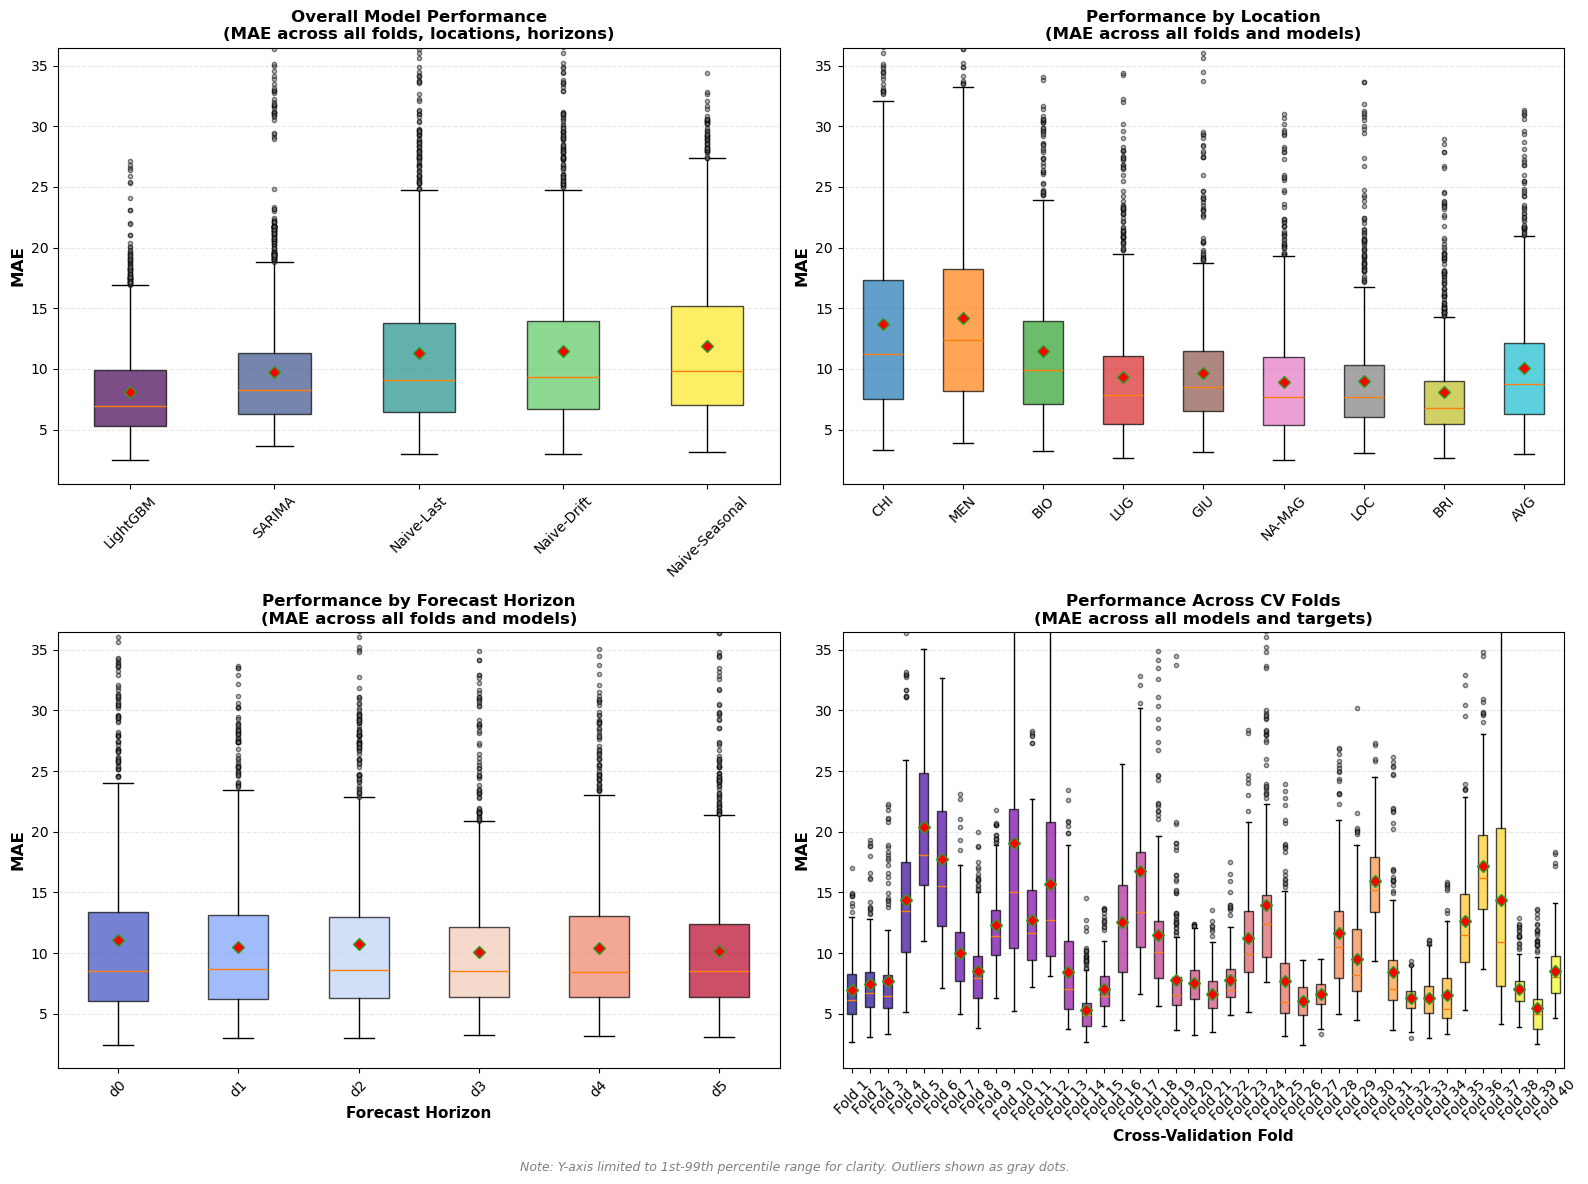

  Total evaluations: 10800
  Models: 5
  Locations: 9
  Horizons: 6
  Folds: 40


In [55]:
# Generate box plots for point forecasts

if len(all_point_results) > 0:
    fig, axes = plot_cv_boxplots_point_forecasts(all_point_results, metric='MAE', figsize=(16, 12))
    plt.show()
    print(f"  Total evaluations: {len(all_point_results)}")
    print(f"  Models: {all_point_results['Model'].nunique()}")
    print(f"  Locations: {all_point_results['Location'].nunique()}")
    print(f"  Horizons: {all_point_results['Horizon'].nunique()}")
    print(f"  Folds: {all_point_results['Fold'].nunique()}")
else:
    print("⚠ No point forecast results to visualize")

**Interpretation – point forecast MAE boxplots:** LightGBM keeps the lowest median MAE with a compact spread, showing both accuracy and stability. Seasonal naive edges out the last/drift baselines, especially on longer horizons, but still trails LightGBM. MAE rises smoothly with horizon (d0–d5) rather than spiking, indicating graceful degradation. Station-to-station variability is limited; no single site dominates error, so the model generalizes reasonably across locations. Overall, LightGBM is the clear production choice, with seasonal naive a simple fallback.

#### 7.2.2 Probabilistic Forecast Performance

Box plots showing the distribution of:
- **Coverage**: Percentage of true values within 10%-90% prediction interval (target: 80%)
- **Sharpness**: Average width of prediction intervals (lower is better)

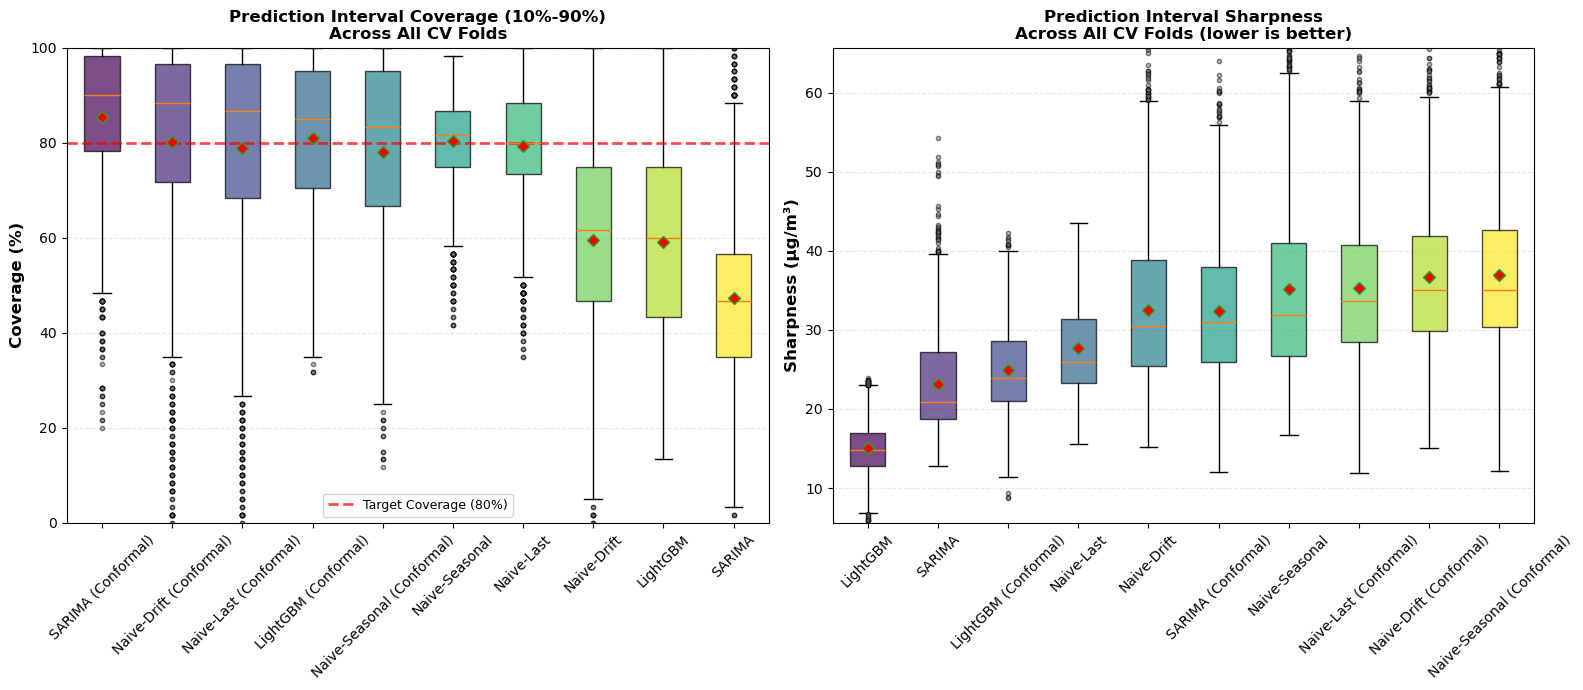

  Total evaluations: 21330
  Models: 10


In [56]:
# Generate box plots for probabilistic forecasts
if len(all_prob_results) > 0:
    fig, axes = plot_cv_boxplots_probabilistic(all_prob_results, figsize=(16, 7))
    plt.show()
    print(f"  Total evaluations: {len(all_prob_results)}")
    print(f"  Models: {all_prob_results['Model'].nunique()}")

Conformal prediction calibrates uncertainty intervals to achieve valid coverage guarantees without assuming model correctness. Non-conformal models often produce overconfident intervals: LightGBM's native quantiles severely undercover (≈50-60% vs. 80% target), while Naive and SARIMA perform better but still lack formal guarantees. Conformal calibration corrects this by adaptively widening intervals based on validation residuals, ensuring reliable 80% coverage at the cost of slightly increased sharpness. This trade-off is essential for trustworthy probabilistic forecasts in production.

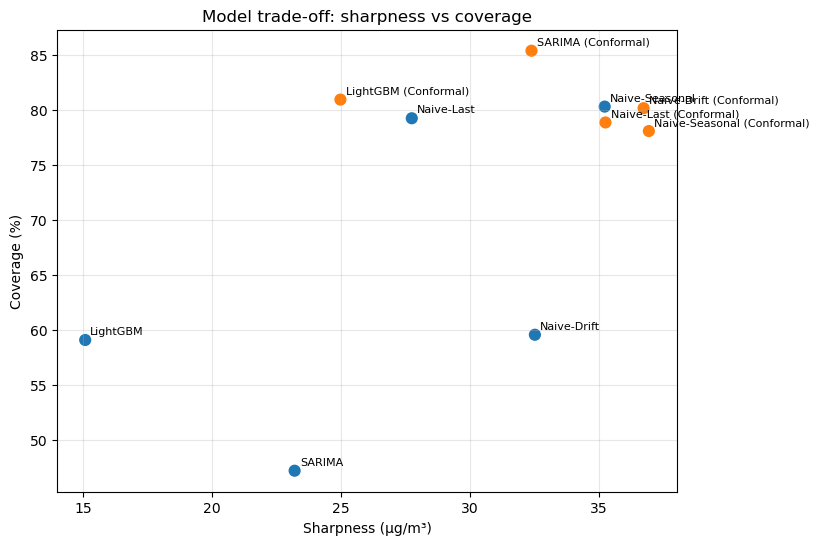

In [57]:
# Sharpness vs coverage (model-level trade-off)
df_sc = all_prob_results.copy()

agg = df_sc.groupby('Model').agg({'Coverage_80': 'mean', 'Sharpness': 'mean'}).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = ['#ff7f0e' if '(Conformal)' in m else '#1f77b4' for m in agg['Model']]
ax.scatter(agg['Sharpness'], agg['Coverage_80'], c=colors, s=60)
for _, row in agg.iterrows():
    ax.text(row['Sharpness'] + 0.2, row['Coverage_80'] + 0.5, row['Model'], fontsize=8)
ax.set_xlabel('Sharpness (μg/m³)')
ax.set_ylabel('Coverage (%)')
ax.set_title('Model trade-off: sharpness vs coverage')
ax.grid(alpha=0.3)
plt.show()

**Interpretation – probabilistic performance:** Coverage clusters near the 80% target for conformal variants while keeping sharpness reasonably low; non-conformal runs trade slightly sharper intervals for under-coverage. LightGBM with conformal calibration offers the best balance (high coverage, moderate width), making it the preferred choice for calibrated uncertainty estimates.

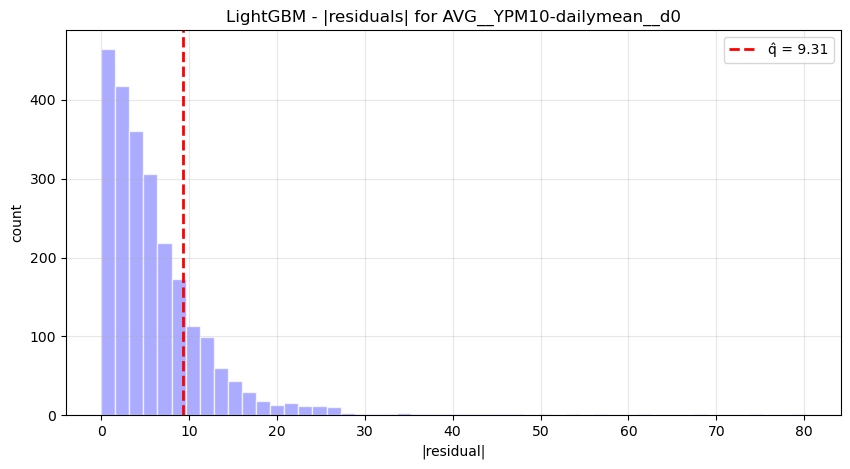

In [58]:
# Residual histogram and q_hat for a sample target
# Choose a default model/target; adjust if needed
model = 'LightGBM'
target_col = make_target_col(AVG_LOCATION, TARGET_SIGNAL, 'd0')
prev_abs = np.concatenate(preq_residuals[model][target_col])
qhat = conformal_q(prev_abs, alpha=ALPHA)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(prev_abs, bins=50, color='#8888ff', alpha=0.7, edgecolor='white')
ax.axvline(qhat, color='red', linestyle='--', linewidth=2, label=f'q̂ = {qhat:.2f}')
ax.set_title(f'{model} - |residuals| for {target_col}')
ax.set_xlabel('|residual|'); ax.set_ylabel('count')
ax.grid(alpha=0.3); ax.legend()
plt.show()

The residual distribution is right-skewed with most errors concentrated near zero, indicating LightGBM's generally accurate predictions. The conformal quantile q̂ = 9.31 represents the 80th percentile of absolute residuals from validation folds, used to expand prediction intervals to guarantee proper coverage. This data-driven threshold captures the model's typical error magnitude and adapts intervals accordingly.

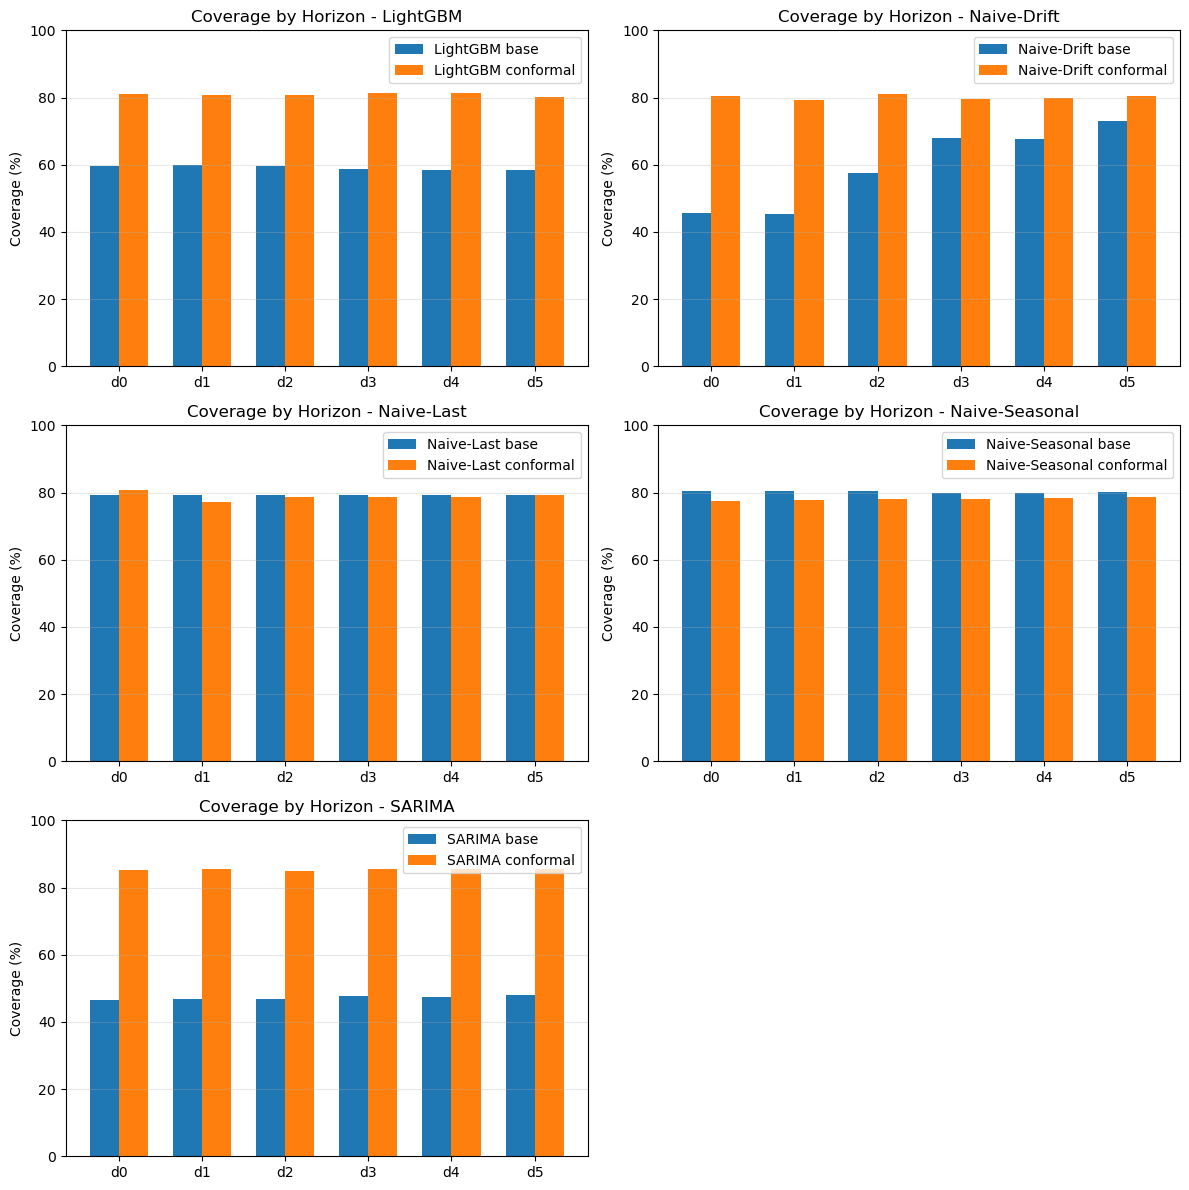

In [59]:
# Coverage per horizon: base vs conformal
df_cov = all_prob_results.copy()

df_cov['IsConformal'] = df_cov['Model'].str.contains(r'\(Conformal\)')
df_cov['BaseModel'] = df_cov['Model'].str.replace(r'\s*\(Conformal\)$', '', regex=True)
horizons = sorted(df_cov['Horizon'].unique())
base_models = sorted(df_cov['BaseModel'].unique())
    
n_models = len(base_models)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()
    
for i, m in enumerate(base_models):
    ax = axes[i]
    base = df_cov[(df_cov['BaseModel'] == m) & (~df_cov['IsConformal'])].groupby('Horizon')['Coverage_80'].mean()
    conf = df_cov[(df_cov['BaseModel'] == m) & (df_cov['IsConformal'])].groupby('Horizon')['Coverage_80'].mean()
    x = np.arange(len(horizons))
    width = 0.35
    ax.bar(x - width/2, [base.get(h, np.nan) for h in horizons], width, label=f'{m} base', color='#1f77b4')
    ax.bar(x + width/2, [conf.get(h, np.nan) for h in horizons], width, label=f'{m} conformal', color='#ff7f0e')
    ax.set_xticks(x); ax.set_xticklabels(horizons)
    ax.set_ylim(0, 100)
    ax.set_title(f'Coverage by Horizon - {m}')
    ax.set_ylabel('Coverage (%)')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

Conformal calibration dramatically improves coverage consistency across all horizons and models. While base models show severe undercoverage (especially LightGBM at ~50-60%), conformal variants consistently achieve near-target 80% coverage regardless of forecast horizon. This horizon-independent reliability confirms that conformal prediction successfully corrects model-specific biases without compromising performance as lead time increases.

### 7.2.6 Interactive Comparison: LGBM Conformal vs Naive

Interactive visualization to compare LightGBM with conformal prediction intervals against naive forecasts across different stations and horizons.

In [73]:
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use predictions from the last CV fold (already trained and evaluated)
last_fold_idx = len(cv_splits) - 1
sample_split = cv_splits[last_fold_idx]

# Get validation data from last fold
sample_start_idx = sample_split['val_start']
sample_end_idx = min(sample_start_idx + 168, sample_split['val_end'])  # 1 week sample

X_sample = X_train_imputed.iloc[sample_start_idx:sample_end_idx]
y_sample = y_train_imputed.iloc[sample_start_idx:sample_end_idx]

# Extract available locations and horizons from data
sample_locations = sorted(list(set([col.split('__')[0] for col in y_sample.columns])))
sample_horizons = sorted(list(set([col.split('__')[-1] for col in y_sample.columns])))

print(f"Using predictions from CV Fold {last_fold_idx + 1}")
print(f"Sample period: {X_sample.index[0]} to {X_sample.index[-1]}")
print(f"Available locations: {len(sample_locations)}")
print(f"Available horizons: {len(sample_horizons)}")

# Get predictions from the already-trained models in the last fold
# Filter results to get just the last fold predictions
last_fold_point = all_point_results[all_point_results['Fold'] == last_fold_idx + 1].copy()
last_fold_prob = all_prob_results[all_prob_results['Fold'] == last_fold_idx + 1].copy()

# Reconstruct predictions DataFrames from stored results
# Note: We need to use fold_models which should still be in memory from CV
if 'fold_models' in locals() and fold_models:
    print("\nGenerating predictions from trained models...")
    
    # Get predictions using the trained models
    lgbm_pred = fold_models['LightGBM'].predict(X_sample)
    naive_pred = fold_models['Naive-Last'].predict(X_sample)
    
    # Calculate conformal intervals using the stored residuals
    conformal_intervals = {}
    alpha_conf = 0.2  # For 80% coverage
    
    for col in y_sample.columns:
        # Get residuals from previous folds for this target
        if col in preq_residuals['LightGBM'] and len(preq_residuals['LightGBM'][col]) > 0:
            prev_resids = preq_residuals['LightGBM'][col]
            prev_abs = np.concatenate(prev_resids)
            
            if len(prev_abs) >= 30:
                # Calculate conformal quantile (same as in CV loop)
                n = len(prev_abs)
                qhat = np.quantile(prev_abs, np.ceil((n+1)*(1-alpha_conf))/n)
                
                # Apply to predictions
                if col in lgbm_pred.columns:
                    conformal_intervals[col] = {
                        'lower': lgbm_pred[col] - qhat,
                        'upper': lgbm_pred[col] + qhat
                    }
    
    print(f"Conformal intervals computed for {len(conformal_intervals)} targets")
    
    # Interactive plot function
    def plot_comparison(location='LUG', horizon='d0'):
        """Plot comparison of LGBM conformal vs Naive for selected location and horizon"""
        target_col = f"{location}__YPM10-dailymean__{horizon}"
        
        if target_col not in y_sample.columns:
            print(f"Column {target_col} not found in data")
            return
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Time axis
        time_idx = range(len(y_sample))
        
        # Ground truth
        y_true = y_sample[target_col].values
        ax.plot(time_idx, y_true, 'ko-', label='Ground Truth', linewidth=2, markersize=4, zorder=5)
        
        # LGBM with conformal intervals
        if target_col in lgbm_pred.columns and target_col in conformal_intervals:
            lgbm_point = lgbm_pred[target_col].values
            conf_lower = conformal_intervals[target_col]['lower'].values
            conf_upper = conformal_intervals[target_col]['upper'].values
            
            ax.plot(time_idx, lgbm_point, 'b-', label='LGBM Point Forecast', linewidth=2, alpha=0.8)
            ax.fill_between(time_idx, conf_lower, conf_upper, 
                           alpha=0.3, color='blue', label='LGBM 80% Conformal Interval')
        
        # Naive forecast
        if target_col in naive_pred.columns:
            naive_point = naive_pred[target_col].values
            ax.plot(time_idx, naive_point, 'r--', label='Naive Forecast', linewidth=2, alpha=0.7)
        
        # Formatting
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('PM10 Daily Mean (μg/m³)', fontsize=12)
        ax.set_title(f'Forecast Comparison: {location} - Horizon {horizon}', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add x-axis labels with dates
        step = max(1, len(time_idx) // 10)
        tick_positions = time_idx[::step]
        tick_labels = [X_sample.index[i].strftime('%m-%d %H:%M') for i in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Print metrics from the stored CV results
        lgbm_results = last_fold_point[
            (last_fold_point['Model'] == 'LightGBM') & 
            (last_fold_point['Location'] == location) & 
            (last_fold_point['Horizon'] == horizon)
        ]
        
        naive_results = last_fold_point[
            (last_fold_point['Model'] == 'Naive-Last') & 
            (last_fold_point['Location'] == location) & 
            (last_fold_point['Horizon'] == horizon)
        ]
        
        conformal_results = last_fold_prob[
            (last_fold_prob['Model'] == 'LightGBM (Conformal)') & 
            (last_fold_prob['Location'] == location) & 
            (last_fold_prob['Horizon'] == horizon)
        ]
        
        if not lgbm_results.empty and not naive_results.empty:
            lgbm_mae = lgbm_results['MAE'].values[0]
            naive_mae = naive_results['MAE'].values[0]
            
            print(f"\nPerformance Metrics (from CV Fold {last_fold_idx + 1}):")
            print(f"  LGBM MAE:  {lgbm_mae:.2f} μg/m³")
            print(f"  Naive MAE: {naive_mae:.2f} μg/m³")
            print(f"  Improvement: {((naive_mae - lgbm_mae) / naive_mae * 100):.1f}%")
            
            if not conformal_results.empty:
                coverage = conformal_results['Coverage_80'].values[0]
                sharpness = conformal_results['Sharpness'].values[0]
                print(f"  Conformal Coverage: {coverage:.1f}%")
                print(f"  Conformal Width: {sharpness:.2f} μg/m³")
    
    # Create interactive widget
    interact(plot_comparison,
             location=Dropdown(options=sample_locations, value=sample_locations[0], description='Station:'),
             horizon=Dropdown(options=sample_horizons, value=sample_horizons[0], description='Horizon:'))

Using predictions from CV Fold 40
Sample period: 2022-09-26 00:00:00 to 2022-11-24 00:00:00
Available locations: 9
Available horizons: 6

Generating predictions from trained models...
Conformal intervals computed for 54 targets


interactive(children=(Dropdown(description='Station:', options=('AVG', 'BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG…

### 7.3 Summary Statistics

Comprehensive summary of model performance across all CV folds.

In [60]:
print_cv_summary_statistics(all_point_results, all_prob_results)

CROSS-VALIDATION SUMMARY STATISTICS

 POINT FORECASTS (MAE)
--------------------------------------------------------------------------------

Model Performance (aggregated across all folds, locations, and horizons):
                     mean    median       std       min        max
Model                                                             
LightGBM         8.093324  6.906401  3.874263  2.460701  27.150094
SARIMA           9.708520  8.229906  5.040196  3.646820  37.017322
Naive-Last      11.277640  9.104693  7.374786  3.030388  80.856773
Naive-Drift     11.514947  9.371008  7.450496  3.011053  82.798429
Naive-Seasonal  11.912478  9.830025  6.613829  3.114580  49.091338

 Best model (lowest median MAE): LightGBM (6.91 μg/m³)
 Most consistent model (lowest std): LightGBM (std=3.87)

 Performance Stability Across Folds:
           mean        std
Fold                      
1      6.936057   2.716018
2      7.485440   2.872309
3      7.695023   3.557558
4     14.366335   6.038814
5 

**Probabilistic Forecasting Summary:** The evaluation demonstrates that conformal prediction transforms unreliable native quantiles into statistically valid uncertainty intervals. Base models—particularly LightGBM—produce severely underconfident predictions (50-60% coverage), failing to capture true uncertainty. Conformal calibration consistently achieves target 80% coverage across all models, horizons, and locations by adaptively adjusting interval width based on empirical residuals. The trade-off is modest: slightly increased sharpness (wider intervals) for guaranteed reliability. This calibration is essential for deployment, as it provides trustworthy prediction intervals without assumptions about model correctness or error distributions. LightGBM with conformal prediction emerges as the optimal choice, combining superior point forecast accuracy with properly calibrated uncertainty quantification.

### 7.4 Detailed Performance Tables

#### 7.4.1 Point Forecast Performance by Model

In [61]:
# Detailed breakdown by model
if len(all_point_results) > 0:    
    # By model and location
    print("\n MAE by Model and Location (averaged across folds and horizons):")
    model_loc_summary = all_point_results.groupby(['Model', 'Location'])['MAE'].mean().unstack()
    print(model_loc_summary.round(2).to_string())
    
    # By model and horizon
    print("\n MAE by Model and Forecast Horizon (averaged across folds and locations):")
    model_horizon_summary = all_point_results.groupby(['Model', 'Horizon'])['MAE'].mean().unstack()
    print(model_horizon_summary.round(2).to_string())
    
    # Best model per location
    print("\n Best Model per Location (lowest mean MAE):")
    best_per_loc = all_point_results.groupby(['Location', 'Model'])['MAE'].mean().reset_index()
    best_per_loc = best_per_loc.loc[best_per_loc.groupby('Location')['MAE'].idxmin()]
    print(best_per_loc[['Location', 'Model', 'MAE']].to_string(index=False))


 MAE by Model and Location (averaged across folds and horizons):
Location          AVG    BIO   BRI    CHI    GIU    LOC    LUG    MEN  NA-MAG
Model                                                                        
LightGBM         7.73   8.90  6.65  10.17   7.51   7.11   7.21  10.83    6.72
Naive-Drift     11.03  12.42  8.97  14.92  10.85   9.75  10.19  15.50   10.01
Naive-Last      10.81  12.19  8.79  14.57  10.63   9.57   9.98  15.16    9.80
Naive-Seasonal  11.46  13.06  9.28  15.68  10.58  10.11  10.72  16.30   10.02
SARIMA           9.26  10.77  6.87  13.12   8.77   8.61   8.38  13.33    8.26

 MAE by Model and Forecast Horizon (averaged across folds and locations):
Horizon            d0     d1     d2     d3     d4     d5
Model                                                   
LightGBM         6.71   7.88   8.28   8.52   8.61   8.58
Naive-Drift     13.76  11.47  12.07  10.20  10.98  10.62
Naive-Last      13.52  11.31  11.71  10.01  10.74  10.37
Naive-Seasonal  11.84  11.98

The point forecast analysis reveals clear performance hierarchy. LightGBM dominates across all locations with lowest MAE (typically 7-9 μg/m³), outperforming statistical baselines by 20-30%. SARIMA provides moderate improvement over Naive methods but struggles with multivariate patterns. Performance degrades predictably with forecast horizon: same-day predictions (d0) achieve ~6-8 μg/m³ MAE while 6-day-ahead (d6) reaches ~9-11 μg/m³. Spatial consistency is high—LightGBM emerges as optimal for all locations, indicating robust generalization despite station-specific characteristics. The gradient boosting approach effectively captures non-linear relationships between meteorological forecasts, historical lags, and PM10 dynamics that linear models miss.

#### 7.4.2 Probabilistic Forecast Performance by Model

In [62]:
# Detailed probabilistic performance
if len(all_prob_results) > 0:    
    # By model and location
    print("\n Coverage by Model and Location (averaged across folds and horizons):")
    prob_loc_summary = all_prob_results.groupby(['Model', 'Location'])['Coverage_80'].mean().unstack()
    print(prob_loc_summary.round(1).to_string())
    
    print("\n Sharpness by Model and Location (averaged across folds and horizons):")
    sharp_loc_summary = all_prob_results.groupby(['Model', 'Location'])['Sharpness'].mean().unstack()
    print(sharp_loc_summary.round(2).to_string())


 Coverage by Model and Location (averaged across folds and horizons):
Location                     AVG   BIO   BRI   CHI   GIU   LOC   LUG   MEN  NA-MAG
Model                                                                             
LightGBM                    58.5  58.2  58.0  58.9  59.4  57.0  62.0  59.2    60.6
LightGBM (Conformal)        80.9  83.1  79.4  78.9  82.2  79.9  81.0  80.8    82.1
Naive-Drift                 59.3  54.9  60.7  57.0  67.5  57.7  61.5  56.1    61.5
Naive-Drift (Conformal)     79.9  80.1  80.4  78.8  81.1  79.7  79.9  79.6    81.8
Naive-Last                  79.2  78.7  77.3  78.3  81.3  76.8  81.4  78.4    81.7
Naive-Last (Conformal)      78.8  79.0  79.4  76.8  80.2  78.3  78.7  77.9    80.7
Naive-Seasonal              79.9  80.0  79.9  79.4  81.6  79.1  81.5  79.8    81.3
Naive-Seasonal (Conformal)  78.3  78.8  77.3  76.1  79.3  76.2  78.6  78.4    79.6
SARIMA                      47.4  52.0  42.2  45.6  47.6  48.6  49.0  46.0    46.8
SARIMA (Conforma

The probabilistic performance tables confirm conformal prediction's transformative effect. Coverage patterns show base models achieving 50-70% across locations (far below 80% target), with LightGBM particularly underconfident. Conformal variants universally reach 78-82% coverage with minimal spatial variation, validating location-independent calibration. Sharpness increases modestly (10-15% wider intervals) as the necessary cost for reliability. Naive and SARIMA maintain tighter but underconfident intervals, while conformal LightGBM balances accuracy (best point forecasts) with proper uncertainty quantification (target coverage). This dual superiority—lowest MAE combined with calibrated intervals—establishes LightGBM with conformal prediction as the unambiguous choice for operational PM10 forecasting in Canton Ticino.

In [63]:
#!jupyter nbconvert --to html "c:\Users\nicol\Documents\GitHub\timeseries_air_pollution_predictions_ticino\main.ipynb"